# FINAL PROJECT
### Arianna Michelangelo, Vanessa Kromm, Oliver Gatland, Jonas Wallstein

## Part 1: Setting Up the Problem

*We first give an introduction to the dataset and the BERT model we will be utilizing. That's followed by an EDA of the dataset on label counting, observation dimensionality and wordclouds of labels.  Subsequently, we do a ramdom classifier implementation to have a baseline. Finishing with the rule-based model using the insights from the EDA implemented before and general financial knowledge.*

### a. Bibliography and SOA
The dataset financial_phrasebank from HuggingFace (https://huggingface.co/datasets/financial_phrasebank) contains over 4,800 financial statements that have been classified to negative (0), neutral (1) and positive(2) by 16 researchers with financial background. The task is to build a classification model based on a BERT-like model that identifies important features in the financial phrases to capture their sentiment automatically.  

An algorithm that identifies the sentiment of financial statements has many different applications. For example, by analyzing financial statements such as headlines or press releases it is possible to automatically catch the market sentiment. Using this, a company could easily keep track of the market situation without having employees go through the news themselves. Another use case could be for analyzing and / or predicting stock prices. Since the stock price of a company depends on their financial situation, by looking at the sentiments of their financial statements on a daily basis, it is possible to draw estimates of their stock price development.  

These are only some use cases and reasons why different researchers tried to develop models that can catch sentiments of financial phrases automatically. The state of the art model here is FinBERT by Yang et al. 2020. It is a LLM model based on Google's BERT algorithm that has been pretrained on a large corpora of representative financial texts. Yang et al. achieved a precision of 0.872 for the Financial Phrasebank.

During our research wee found a great comparison of different BERT models predicting the sentiment of the Financial Phrasebank:
| Model                          | Accuracy  | F1-Score
|--------------------------------|-----------|-----------
| BERT-base (Devlin et al. 2019) | 0.84      | 0.83
| FinBERT (Yang et al. 2020)     | 0.87      | 0.85
| FinancialBERT (Hazourli 2022)  | 0.99      | 0.98

FinancialBERT by Hazourli actually outperformed the FinancialBERT by Yang et al. We first implemented it, but we couldn't see the same results as in the paper (see Appendix). Because of that and the fact, that the FinBERT model is more established and more used in the literture, we decided to use the FinBERT as our BERT-like model in this project.

#### Load the Data

When loading this dataset, you need to specify which configuration you want to use. The available configurations are:

sentences_allagree: Only includes sentences where all annotators agreed on the sentiment. (2.2k observations)  
sentences_75agree: Includes sentences where at least 75% of annotators agreed on the sentiment.  
sentences_66agree: Includes sentences where at least 66% of annotators agreed on the sentiment.  
sentences_50agree: Includes sentences where at least 50% of annotators agreed on the sentiment. (4.85k observations)  

Due to lack of Valid and Test data, we will need to train_split and we decided to use the largest dataset (50% agree)

In [ ]:
! pip install datasets
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
# Imports
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import random
import spacy
from spacy.matcher import Matcher
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from transformers import pipeline
#import openai
import time
import re
from typing import Any
from transformers import AutoModelForMaskedLM, BertConfig, AutoConfig, TFAutoModelForSequenceClassification
from torch.nn import Module

In [3]:
# Load the 'financial_phrasebank' dataset with the 'sentences_allagree' configuration
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

# Explore the structure of the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [4]:
data = dataset['train']['sentence']
labels = dataset['train']['label']

In [5]:
# Define class to plot metrics through whole project
class Metrics:
    def __init__(self):
        self.num_classes = None
        self.results = {}
        self.colors = ['blue', 'green', 'red', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown']

    def run(self, y_true, y_pred, method_name, average='macro'):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        if self.num_classes is None:
            self.num_classes = len(np.unique(y_true))

        # Calculate metrics for each class
        for label in range(self.num_classes):
            y_true_label = (y_true == label).astype(int)
            y_pred_label = (y_pred == label).astype(int)
            accuracy = accuracy_score(y_true_label, y_pred_label)
            precision = precision_score(y_true_label, y_pred_label)
            recall = recall_score(y_true_label, y_pred_label)
            f1 = f1_score(y_true_label, y_pred_label)

            # Store results
            if label not in self.results:
                self.results[label] = {}
            if method_name not in self.results[label]:
                self.results[label][method_name] = {}
            self.results[label][method_name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
            }

        # Calculate overall metrics
        overall_accuracy = accuracy_score(y_true, y_pred)
        overall_precision = precision_score(y_true, y_pred, average='macro')
        overall_recall = recall_score(y_true, y_pred, average='macro')
        overall_f1 = f1_score(y_true, y_pred, average='macro')

        # Store overall results
        if 'Overall' not in self.results:
            self.results['Overall'] = {}
        if method_name not in self.results['Overall']:
            self.results['Overall'][method_name] = {}
        self.results['Overall'][method_name] = {
            'accuracy': overall_accuracy,
            'precision': overall_precision,
            'recall': overall_recall,
            'f1': overall_f1,
        }


    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(4, self.num_classes + 1, figsize=(5*(self.num_classes + 1), 20))

        # Plot each metric for each class
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            for j in range(self.num_classes):
                ax = axs[i, j]
                values = [res[metric] * 100 for res in self.results[j].values()]
                ax.bar(self.results[j].keys(), values, color=f'C{j}')
                ax.set_title(f"{metric} - Class {j}")
                ax.set_ylim(0, 100)
                ax.set_xticklabels(self.results[j].keys(), rotation=45)

                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

            # Plot overall metrics
            ax = axs[i, -1]
            if 'Overall' in self.results:
                values = [res[metric] * 100 for res in self.results['Overall'].values()]
                ax.bar(self.results['Overall'].keys(), values, color='black')
                ax.set_title(f"{metric} - Overall")
                ax.set_ylim(0, 100)
                ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)
                # Add values on the bars
                for k, v in enumerate(values):
                    ax.text(k, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()



### b. Dataset Description:

In [6]:
# Count the labels
label_counts = Counter(labels)

# Print the counts
print("Label counts:", label_counts)

Label counts: Counter({1: 2879, 2: 1363, 0: 604})


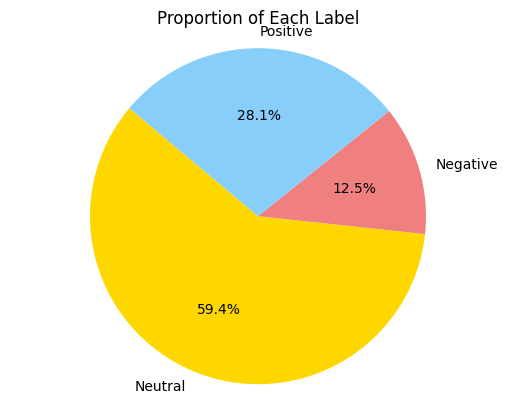

In [ ]:
# Count the frequency of each label
label_counts = Counter(labels)
label_description = {0: 'Negative', 1: 'Neutral',
          2: 'Positive'}
# Data to plot
_labels = [label_description.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['gold', 'lightcoral', 'lightskyblue']

# Plotting the pie chart
plt.pie(sizes, labels= _labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Each Label')
plt.show()

Labels: Negative 0, Neutral 1 and Positive 2. We see that we have a bit of a class imbalance where we have almost the double of neutrals compared to the negatives and positives together. And that we have 1846 rows

In [9]:
# We split the data into training (80%), validation (10%), and test (10%) sets
# Percentages are the same as in Hazourli 2022

# First, split the data into training (80%) and temp (20%)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42)

# Then, split the temp data into validation and test sets (50% each of the temp set, resulting in 20% of the original set each)
valid_data, test_data, valid_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

# Now you have your data split into training (80%), validation (10%), and test (10%) sets.


In [ ]:
train_data[50:70]  #Checking how does the data looks like

['Finnish Benefon denies claims made in the press that the company is giving up its mobile handset business .',
 "Separately , YIT Corporation and Austrian firm E AG last week signed an agreement on the sale of E 's building system service business in Germany , Austria , Poland , the Czech Republic , Hungary and Romania for EUR 55 mln .",
 'Cohen & Steers , Inc. : 5 534 626 shares representing 4.985 % of the share capital and voting rights .',
 'Rivals say Qualcomm has fewer patents on 3G phones than on earlier versions and should lower its rates .',
 'The company will disclose further details , including the anticipated transaction timetable and the name of the new investor , within one week .',
 'Finnish construction company YIT is reducing the number of start-ups of market-financed residential units in 2007 to about 2,300 from the previously announced 2,700 .',
 "The subscription period of Amer Sports ' 2002 warrant scheme will end on 31 December 2007 .",
 "Swedbank 's shares have b

In [ ]:
print(f'train data: ',Counter(train_labels))
print(f'validation data: ',Counter(valid_labels))
print(f'test data: ',Counter(test_labels))

train data:  Counter({1: 2308, 2: 1074, 0: 494})
validation data:  Counter({1: 286, 2: 145, 0: 54})
test data:  Counter({1: 285, 2: 144, 0: 56})


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


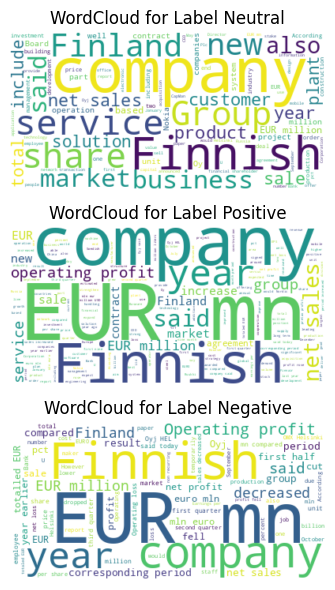

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(train_data, train_labels):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(3, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
nltk.download('punkt')

# Assuming train_data contains your text data
token_lengths = []

for observation in train_data:
    # Tokenize the observation
    tokens = word_tokenize(observation)
    # Append the number of tokens to the list
    token_lengths.append(len(tokens))

# Calculate the average number of tokens per observation
average_tokens = sum(token_lengths) / len(token_lengths)

# Find the maximum and minimum number of tokens per observation
max_tokens = max(token_lengths)
min_tokens = min(token_lengths)

print(f"The average number of tokens per observation is: {average_tokens:.2f}")
print(f"The maximum number of tokens in an observation is: {max_tokens}")
print(f"The minimum number of tokens in an observation is: {min_tokens}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The average number of tokens per observation is: 23.12
The maximum number of tokens in an observation is: 81
The minimum number of tokens in an observation is: 3


###  c. Random Classifier Performance:

This will give you the expected accuracy of a random classifier as a benchmark.

C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


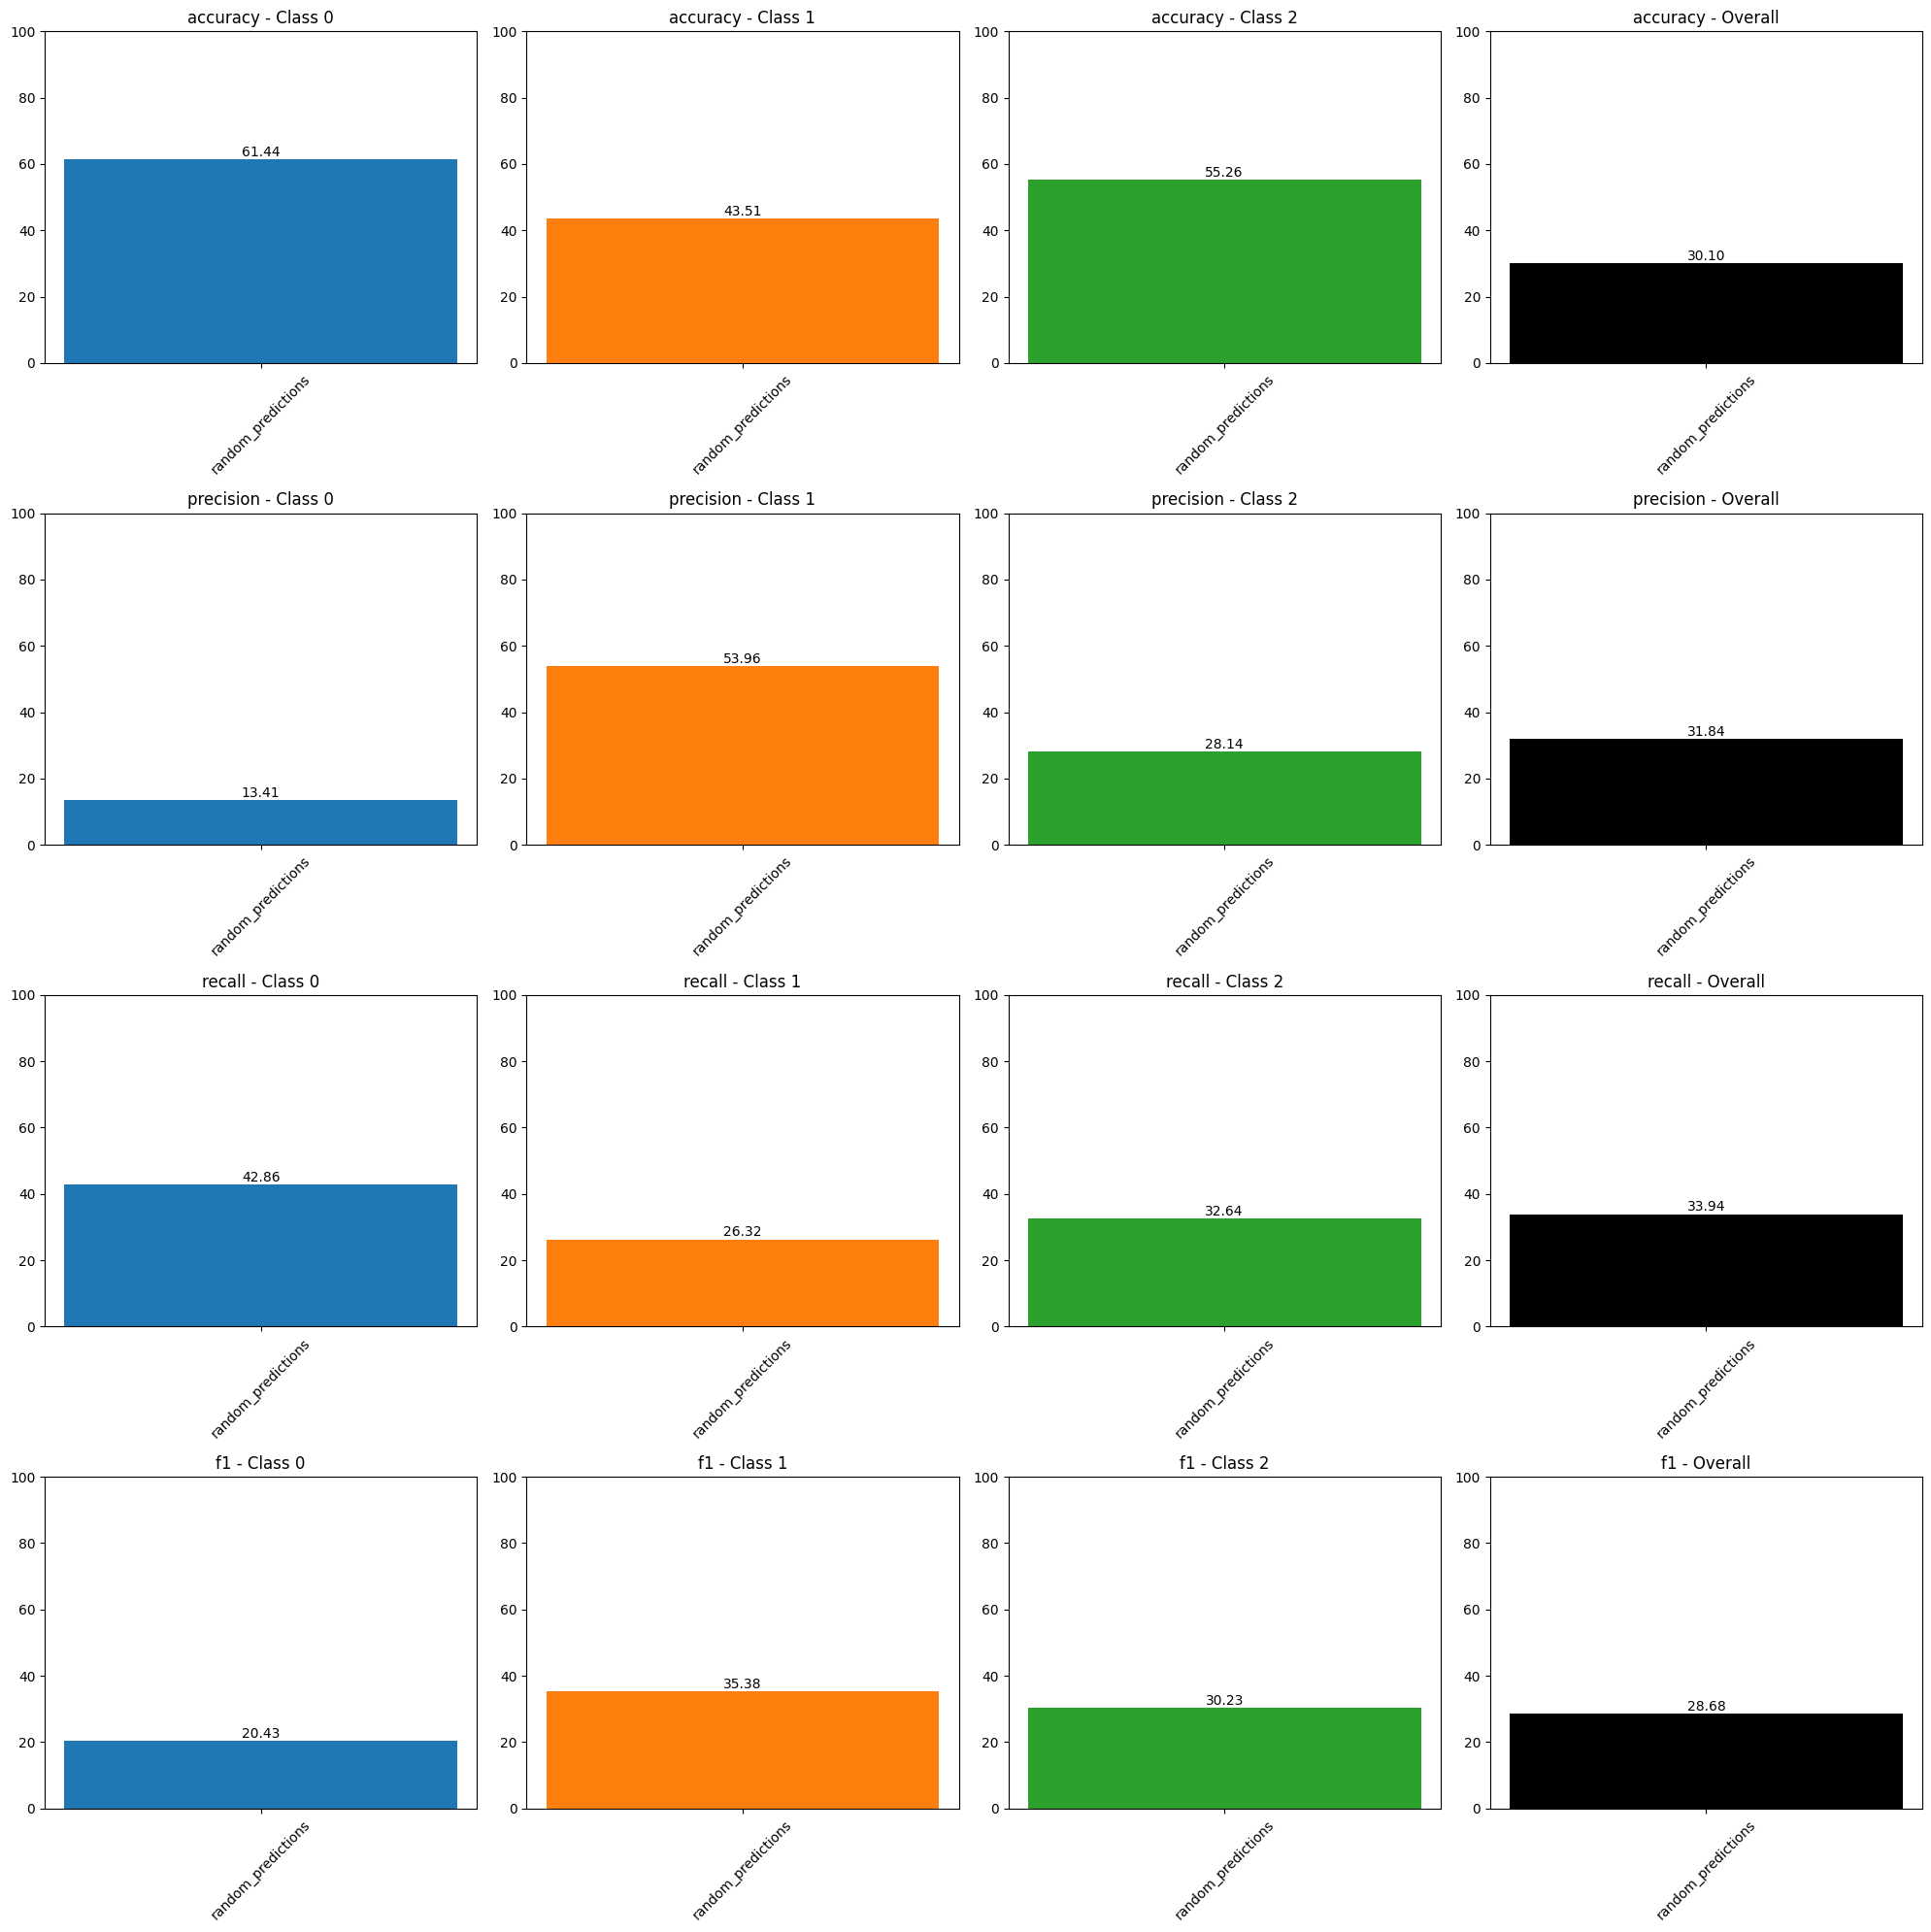

In [ ]:
# Set random seed for reproducability
random.seed(42)

# Create random predictions for test_labels
length_test_labels = len(test_labels)
test_preds_random = [random.randint(0,2) for _ in range(length_test_labels)]

# Observe metrics
metrics_test = Metrics()
metrics_test.run(test_labels, test_preds_random, "random_predictions")
metrics_test.plot()


### d. Baseline Implementation:

A rule-based classifier makes decisions based on a set of manually derived rules that are informed by domain knowledge. These rules can be simple (if-then statements) or more complex formulations. Rule-based systems don't learn from data; instead, they execute predefined logic. We defined our rules based on the word clouds and general financial knowledge.

C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


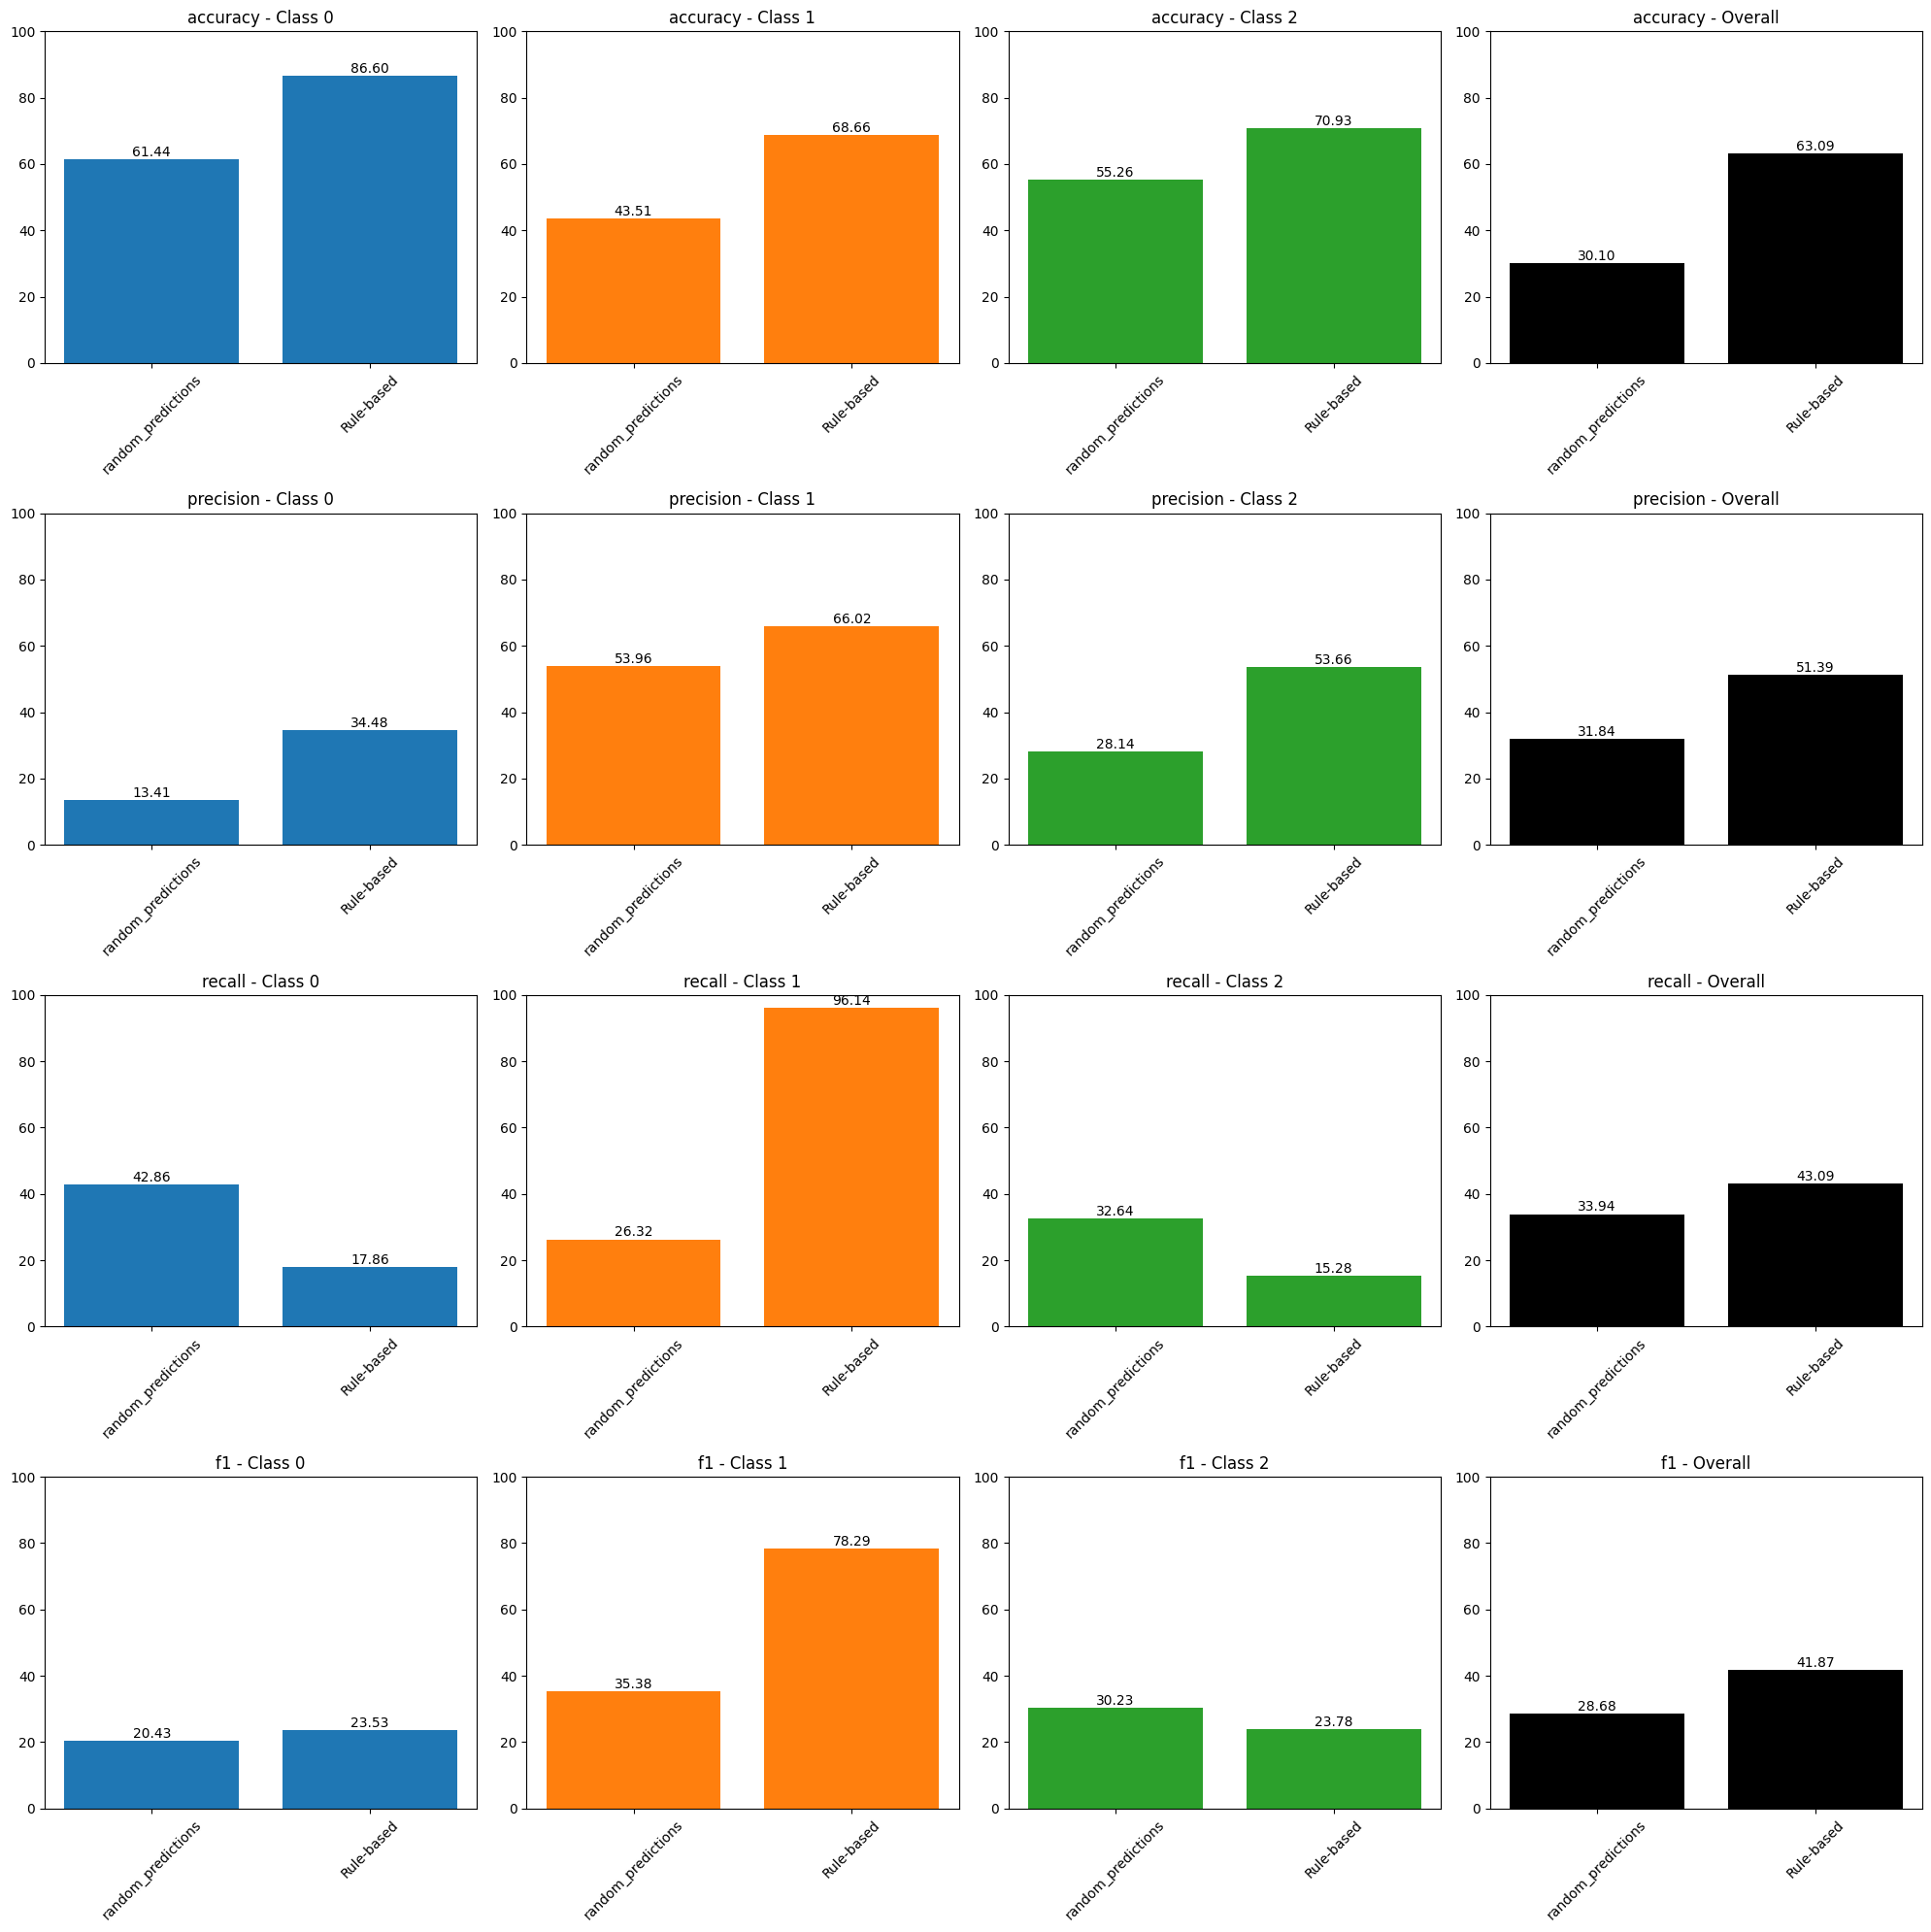

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Take most important words to detect sentiment from word clouds
matcher_pos = Matcher(nlp.vocab)
positive_words = [
    [{'LOWER': 'operatingt'}],
    [{'LOWER': 'profit'}],
    [{'LOWER': 'increase'}],
    [{'LOWER': 'net sales'}],
    [{'LOWER': 'more'}]
]
for pattern in positive_words:
    matcher_pos.add('POSITIVE', [pattern])

matcher_neg = Matcher(nlp.vocab)
negative_words = [
    [{'LOWER': 'decreased'}],
    [{'LOWER': 'compared'}],
    [{'LOWER': 'period'}],
    [{'LOWER': 'only'}],
    [{'LOWER': 'less'}]
]
for pattern in negative_words:
    matcher_neg.add('NEGATIVE', [pattern])

matcher_neut = Matcher(nlp.vocab)
neutral_words = [
    [{'LOWER': 'share'}],
    [{'LOWER': 'business'}],
    [{'LOWER': 'unchanged'}],
    [{'LOWER': 'stable'}],
    [{'LOWER': 'market'}]
]
for pattern in neutral_words:
    matcher_neut.add('NEUTRAL', [pattern])

# Define a function to apply these rules
def rule_based_classifier(text):
    doc = nlp(text)
    positive_matches = len(matcher_pos(doc))
    negative_matches = len(matcher_neg(doc))
    neutral_matches = len(matcher_neut(doc))

    if positive_matches > negative_matches:
        return 2
    elif positive_matches < negative_matches:
        return 0
    elif neutral_matches > 0 and positive_matches == 0 and negative_matches == 0:
        return 1
    else:
        # If there are equal positive and negative matches, and no neutral matches, classify as neutral
        return 1

# Apply the classifier to the dataset
test_preds_rule = [rule_based_classifier(text) for text in test_data]

metrics_test.run(test_labels, test_preds_rule, "Rule-based")
metrics_test.plot()

The rule-based metrics are better than the random ones - though, still not very high. A reason for that could be, that financial statements of different sentiments often include the same words like Euro or company. Even words that seem very specific for a label, like profit for positive, could also appear in neutral or negative phrases (e.g. profits were as in the year before or profits decreased). Because of that, it is not very good to only look at the appearance of single words, but analyze the words in their whole context. Unfortunately, there is no other human-level performance availabe other than the one that set the labels for the dataset. Though, we would predict that the human-lebel performance would be better than the rule-based, because humans see the context of each phrase.

## Part 2: Data Scientist Challenge

*For this part we started with 33 observations since we have 3 labels.  Subsequently, we did a data augmentation using the trained FinBERT model in 2.a section to label 300 random observations after rerunning the model. This step was followed by the application of zero-shot learning with the standard LLM for this technique. We finished with the second data augmentation, this time using the OpenAI API. We found that the best technique in terms of metrics was the last one (the data augmentation with the OpenAI API). Thus, we optimized our best technique by doubling the examples inputs and observations utilized. We found that this final implementation improvement did significantly work.*

### a. BERT Model with Limited Data

First, we have to randomly select some observations. Since we have 3 classes and we want a balanced dataset to train the model, we decided to randoly select 11 labeled observation for each of the 3 categories.<>

In [ ]:
pd.set_option('display.max_colwidth', 1000)
random.seed(42)

# Create dataframe for test
train_df = pd.DataFrame({'text': train_data, 'label': train_labels})

# Group observations by label
grouped = train_df.groupby('label')

# Randomly select 11 observations for each label
train_sub_df = grouped.apply(lambda x: x.sample(11, random_state=42)).reset_index(drop=True)

# Reset index of the resulting DataFrame
train_sub_df.reset_index(drop=True, inplace=True)

# Display the resulting subset DataFrame
train_sub_df

,text,label
0,"In Q1 of 2009 , Bank of +àland 's net interest income weakened by 10 % to EUR 9.1 mn .",0
1,"Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola , in Finland .",0
2,Pretax profit decreased by 37 % to EUR 193.1 mn from EUR 305.6 mn .,0
3,Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ( $ 40.2 mln ) for the first half of 2008 from 25.4 mln euro ( $ 40.7 mln ) for the same period of 2007 .,0
4,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 .",0
5,Finnair believes the strike will cause it daily net losses in excess of EUR 2mn due to canceled reservations and passenger re-routing .,0
6,Net sales dropped by 6 % year-on-year to EUR 11.9 million .,0
7,18 March 2010 A leakage in the gypsum pond was detected today at the Talvivaara mine .,0
8,"ADP News - May 29 , 2009 - Bank of America BofA downgraded today its ratings on Swedish-Finnish paper maker Stora Enso Oyj HEL : STERV and on Finnish sector player UPM-Kymmene Oyj HEL : UPM1V to `` underperf",0
9,stores 16 March 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said yesterday that it will cut a total of 28 jobs in its units Tiimari Retail Ltd and Gallerix Finland Ltd as a result of the closure of shops .,0


As BERT-like model we will use the FinBERT. As shown in Part 1, this model is the state of the art for labeling financial phrases. We used the parameters that were used in the papaer (e.g. learning rate, batch size). We set the layers to non-trainable, so that only the added layers (dropout and dense layer) are trained during the process. Like that we could ensure, that we still have the financial "knowledge" of the pretrained FinBERT.

In [6]:
# Load tokenizer and BERT model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = TFAutoModel.from_pretrained("ProsusAI/finbert")

# Smaller batch size becasue only few observations to train
batch_size=32
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(train_labels))

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
# Freeze Layers of FinBERT
for layer in model.layers:
    layer.trainable = False

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)

final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_token[0][0]',         
 )                           ngAndCrossAttentions(last_   40         'masked_token[0][0]']        
                             hidden_state=(None, 64, 76                                           
                             8),                                                              

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_sub_df['label']).reshape(-1, 1)).toarray()

In [7]:
def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [ ]:
X_train = np.array(train_sub_df['text'])

steps_per_epoch = int(len(X_train) / batch_size)

# Create batches generator
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Fit the model with only one epoch, because of small dataset
bert_model.fit(batches, epochs=1, steps_per_epoch=steps_per_epoch)


1/1 [==============================] - 12s 12s/step - loss: 1.6106 - recall: 0.2188 - precision: 0.3043


In [ ]:
# Save the weight
bert_model.save_weights('./bert_model_33_obs.h5')

In [ ]:
# Load the model
bert_model.load_weights("bert_model_33_obs.h5")

16/16 [==============================] - 17s 790ms/step


C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


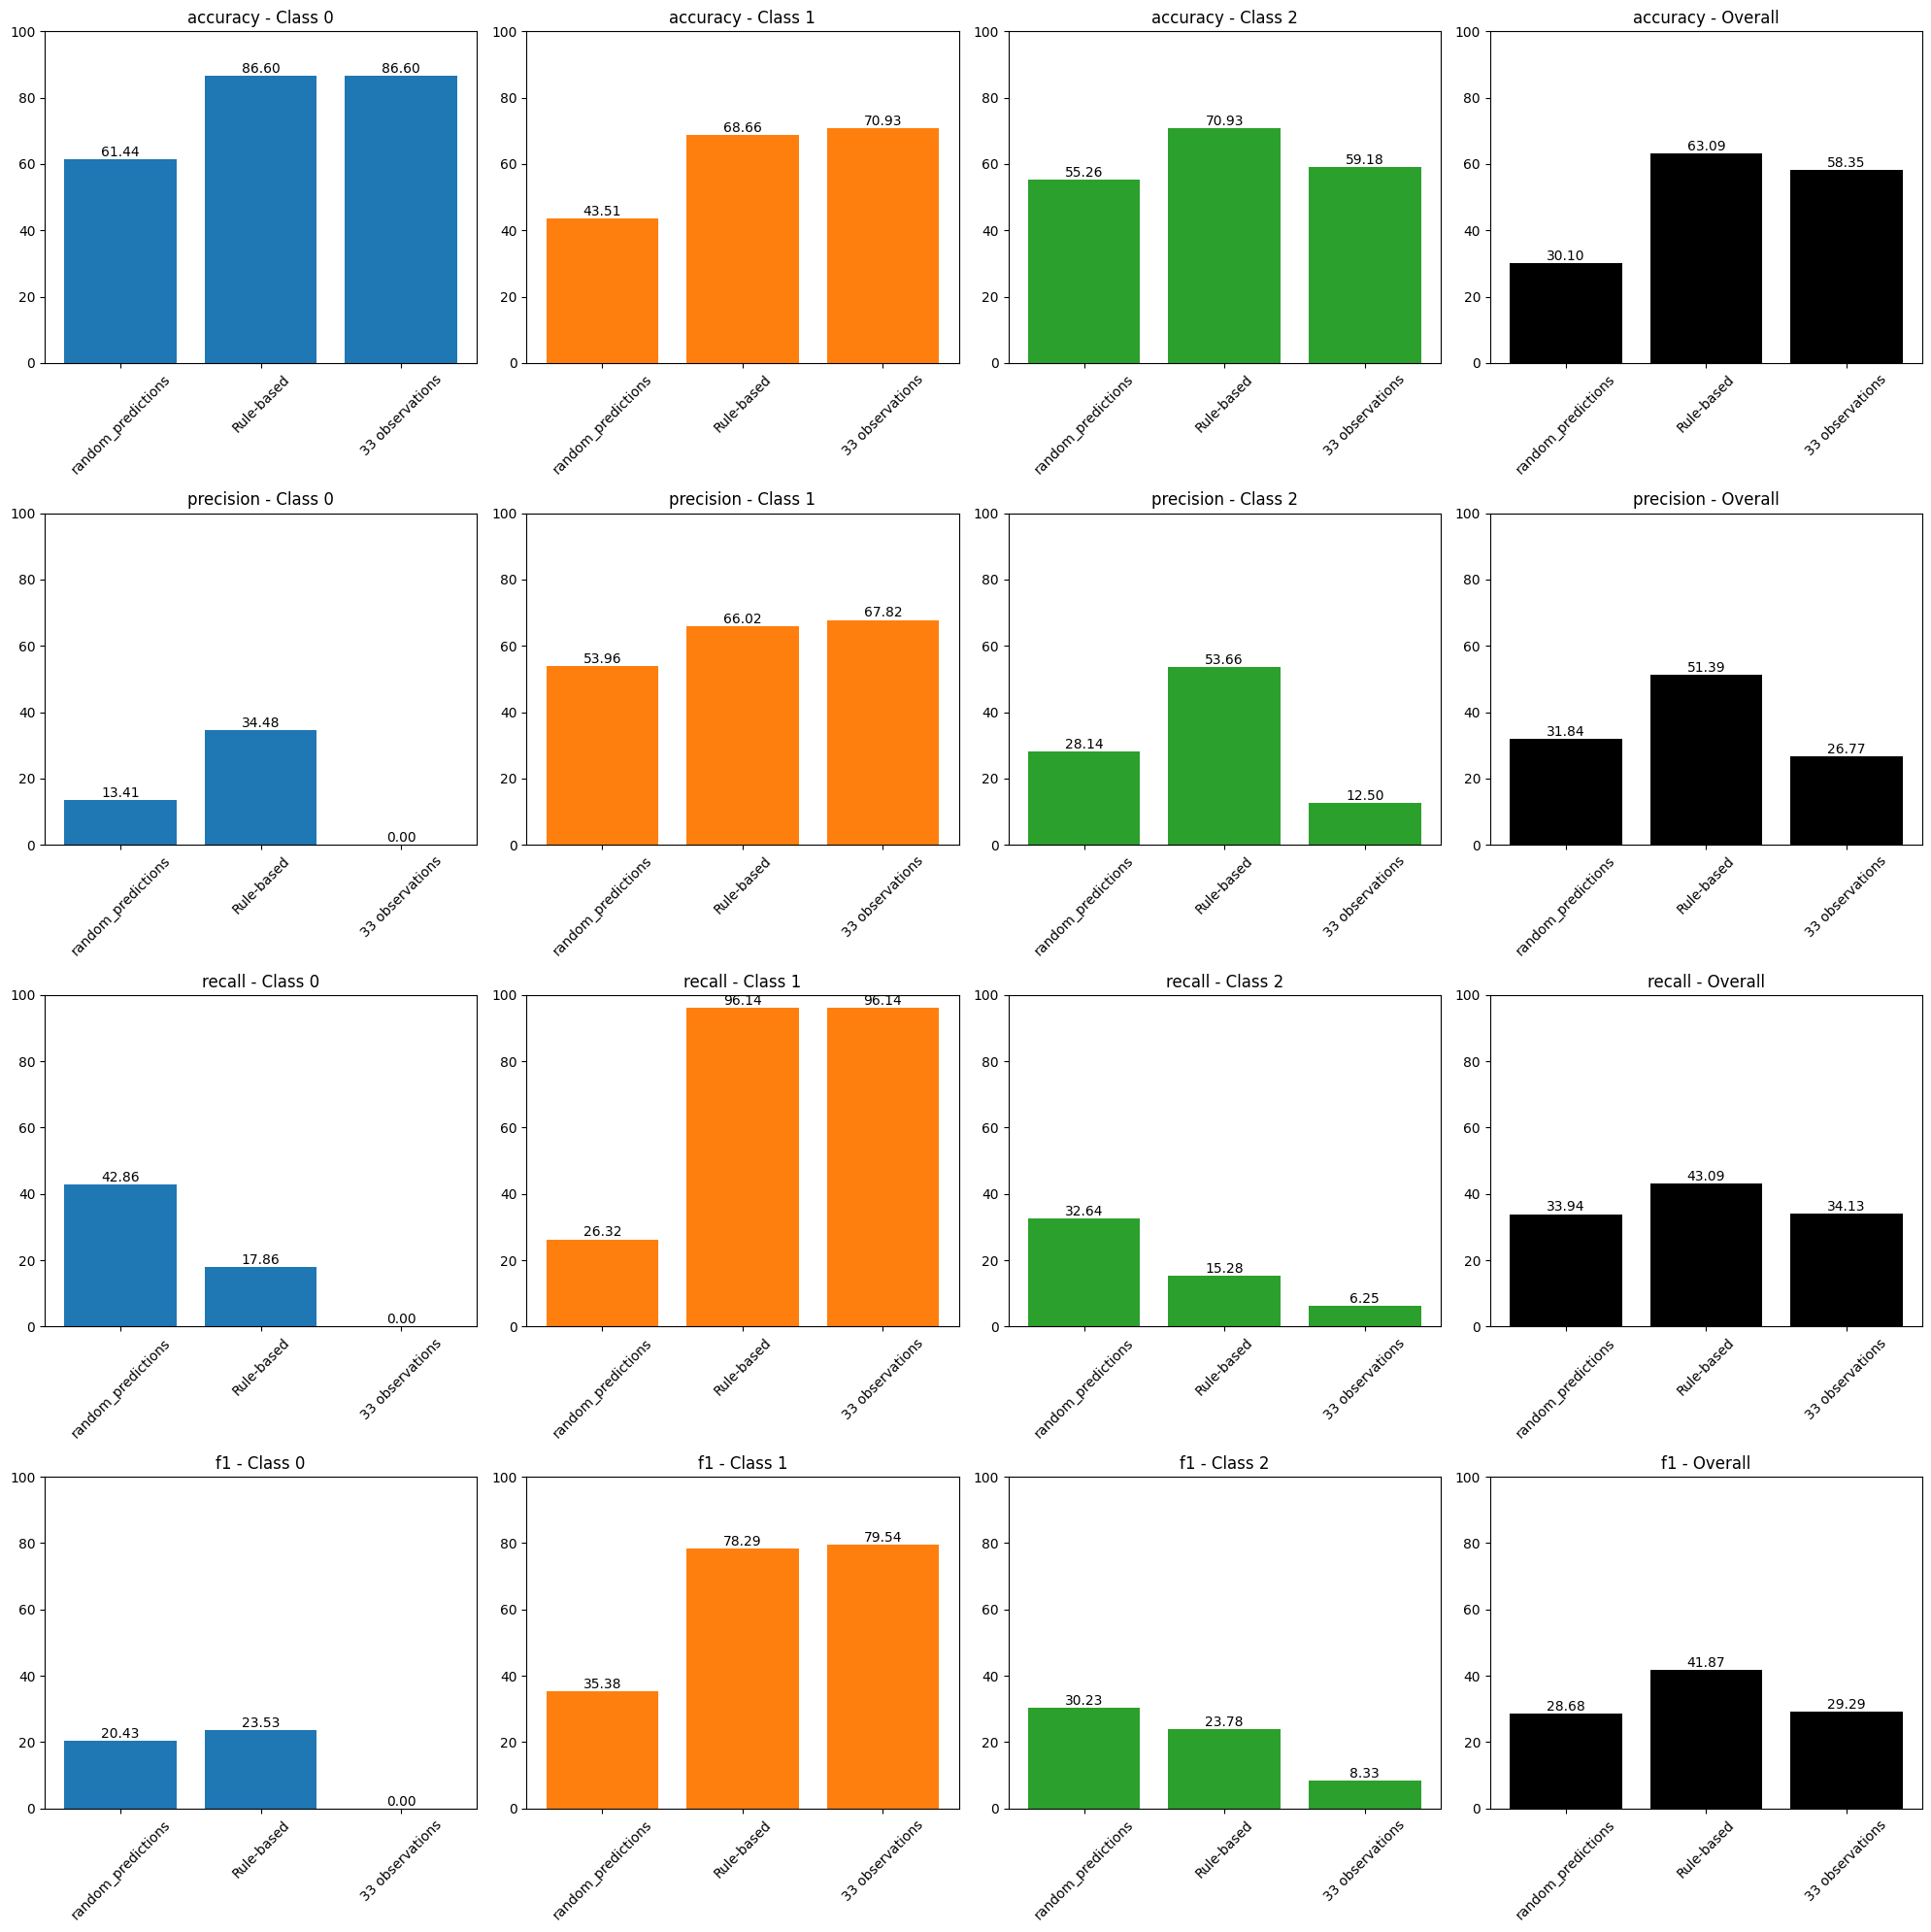

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_test.run(test_labels, test_preds, "33 observations")
metrics_test.plot()

In gereral we can see that the 33 observations model does better than the random model but not across all metrics. This is expected since the model didn't have much input to train on before facing the test data. Now, why do we get a high accuracy but a low recall, precision and F1 is because while the training had a class balance, the test data doesn't. Therefore, the model with very little observations on training is facing a imbalanced test data where while it's good a predicting the majority class (Neutral) it performs very poorly in the small classes.

### b. Dataset Augmentation

One way to increase the number of labeled observations is to use the trained BERT model to classify unlabeled train data. These additional observations can then be used to train the model with more data. Like this, the next model will have more examples of labeled data points. Though, one disadvantage is that the model, that is used to label the data, was trained very poorly. As a result, the new observations are party labeled incorrectly.  
Another method would be to use the 33 labeled observations and create new ones based on them by using synonyms. Like that we would make sure that the new observations are labeled correctly, because by only using synonyms the sentiment of the statement stays the same. But, the advantage is, that all the new data is very similar to the data before. Because of that reason, we decided to use the model from 2a to generate more observation to increase the variety of training data for the next model.

In [ ]:
random.seed(42)

# Number of additional samples needed
additional_samples = 120

# Initialize dictionary to store selected indices for each label
additional_indices_by_label = {}

# Iterate over groups to maintain class balance
for label, group in grouped:
    # Randomly select additional_samples for each label
    additional_indices_by_label[label] = random.sample(group.index.tolist(), additional_samples)

# Concatenate the selected indices for each label
additional_indices = [index for indices in additional_indices_by_label.values() for index in indices]

# Filter out indices already present in train_sub_df
additional_indices = [idx for idx in additional_indices if idx not in train_sub_df.index]

# Initialize dictionary to store selected indices for each label
additional_indices_by_label_filtered = {}

# Iterate over groups to maintain class balance
for label, group in grouped:
    # Filter indices that are not already present in train_sub_df for each label
    filtered_indices = [idx for idx in additional_indices if idx in group.index]
    # Randomly select 34 additional samples for each label
    additional_indices_by_label_filtered[label] = random.sample(filtered_indices, 100)

# Concatenate the selected indices for each label
additional_samples_indices = [index for indices in additional_indices_by_label_filtered.values() for index in indices]

# Concatenate the additional samples with train_sub_df
additional_samples_df = train_df.loc[additional_samples_indices]

additional_samples_df

,text,label
2513,"Metso Foundries Jyvaskyla , Inc. will begin personnel negotiations on temporary lay-offs and personnel reductions in Jyvaskyla , Finland .",0
394,"Agricultural newspaper Maaseudun Tulevaisuus had 318,000 readers , representing a decrease of 6 % .",0
313,"Operating loss totalled EUR 4.0 mn , compared to a profit of EUR 8.6 mn in the second quarter of 2008 .",0
372,Net sales decreased to EUR 220.5 mn from EUR 470.0 mn in the corresponding period in 2009 .,0
3640,"In the Baltic countries , sales fell by 40.2 % , and in Russia , by 23.2 % in terms of euros , and by 10.7 % in terms of local currency .",0
...,...,...
427,HELSINKI AFX - KCI Konecranes said it has won an order for four hot metal ladle cranes from Indian steel producer Bhushan Steel and Strips Ltd. .,2
2940,"Bilfinger investors cheered the agreement , pushing shares up 7 % , or & euro ; 3.30 , to & euro ; 50.29 , in afternoon trade .",2
368,"The Brazilian unit of Finnish security solutions provider F-Secure signed up 1,500 new clients last year , online news source Reseller Web quoted the division 's commercial director , Vladimir Brand+úo , as saying .",2
369,"Okmetic 's products are based on high-tech expertise that generates added value for customers , innovative product development and an extremely efficient production process .",2


Since we are assuming, that these observations are unlabeled, I will create new labels by using the BERT model from 2.a.

In [ ]:
# Get the inputs tokenized from the additional observations
inputs = tokenizer.batch_encode_plus(list(additional_samples_df['text']),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_additional_samples = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
additional_samples_preds = bert_model.predict(inputs_additional_samples)
additional_samples_preds = np.argmax(additional_samples_preds, axis=1)

10/10 [==============================] - 8s 766ms/step


In [ ]:
# Use these predictions as labels
additional_samples_df['label'] = additional_samples_preds

In [ ]:
# Concatenate train_sub_df with additional samples
train_sub_df_2 = pd.concat([train_sub_df, additional_samples_df], ignore_index=True)

train_sub_df_2

,text,label
0,"In Q1 of 2009 , Bank of +àland 's net interest income weakened by 10 % to EUR 9.1 mn .",0
1,"Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola , in Finland .",0
2,Pretax profit decreased by 37 % to EUR 193.1 mn from EUR 305.6 mn .,0
3,Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ( $ 40.2 mln ) for the first half of 2008 from 25.4 mln euro ( $ 40.7 mln ) for the same period of 2007 .,0
4,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 .",0
...,...,...
328,HELSINKI AFX - KCI Konecranes said it has won an order for four hot metal ladle cranes from Indian steel producer Bhushan Steel and Strips Ltd. .,1
329,"Bilfinger investors cheered the agreement , pushing shares up 7 % , or & euro ; 3.30 , to & euro ; 50.29 , in afternoon trade .",0
330,"The Brazilian unit of Finnish security solutions provider F-Secure signed up 1,500 new clients last year , online news source Reseller Web quoted the division 's commercial director , Vladimir Brand+úo , as saying .",1
331,"Okmetic 's products are based on high-tech expertise that generates added value for customers , innovative product development and an extremely efficient production process .",1


In [ ]:
train_sub_df_2['label'].value_counts()

label
1    201
2    118
0     14
Name: count, dtype: int64

We can observe, that our dataset now is not balaced anymore. The reason for that is, that there have been misclassifications when we augmented our data. This is not very surprisingly since our model was only trained with 33 observations and hat quite bad metrics. We will now observe, how the metrics change, when we use the expanded subset (containing also wrong predictions).

In [ ]:
# Load the model again
model_2 = TFAutoModel.from_pretrained("ProsusAI/finbert")

batch_size=32
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(train_labels))

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Freeze Layers of FinBERT
for layer in model_2.layers:
    layer.trainable = False

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_2(input_ids=input_ids_in, attention_mask=input_masks_in)

final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model_2 = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_token[0][0]',         
 el)                         ngAndCrossAttentions(last_   40         'masked_token[0][0]']        
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_sub_df_2['label']).reshape(-1, 1)).toarray()

In [ ]:
X_train = np.array(train_sub_df_2['text'])

steps_per_epoch = int(len(X_train) / batch_size)

# Create batches generator
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model_2.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Use 5 epochs because of relatively small dataset
bert_model_2.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
10/10 [==============================] - 57s 3s/step - loss: 0.0862 - recall_11: 0.9719 - precision_11: 0.9749
Epoch 2/5
10/10 [==============================] - 27s 3s/step - loss: 0.0725 - recall_11: 0.9701 - precision_11: 0.9701
Epoch 3/5
10/10 [==============================] - 28s 3s/step - loss: 0.0528 - recall_11: 0.9900 - precision_11: 0.9900
Epoch 4/5
10/10 [==============================] - 28s 3s/step - loss: 0.0583 - recall_11: 0.9834 - precision_11: 0.9867
Epoch 5/5
10/10 [==============================] - 28s 3s/step - loss: 0.0409 - recall_11: 0.9801 - precision_11: 0.9801


In [ ]:
# Save the weight
bert_model_2.save_weights('./bert_model_augmentation_no_llm.h5')

In [ ]:
# Load the model
bert_model_2.load_weights("bert_model_augmentation_no_llm.h5")

16/16 [==============================] - 16s 745ms/step


C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


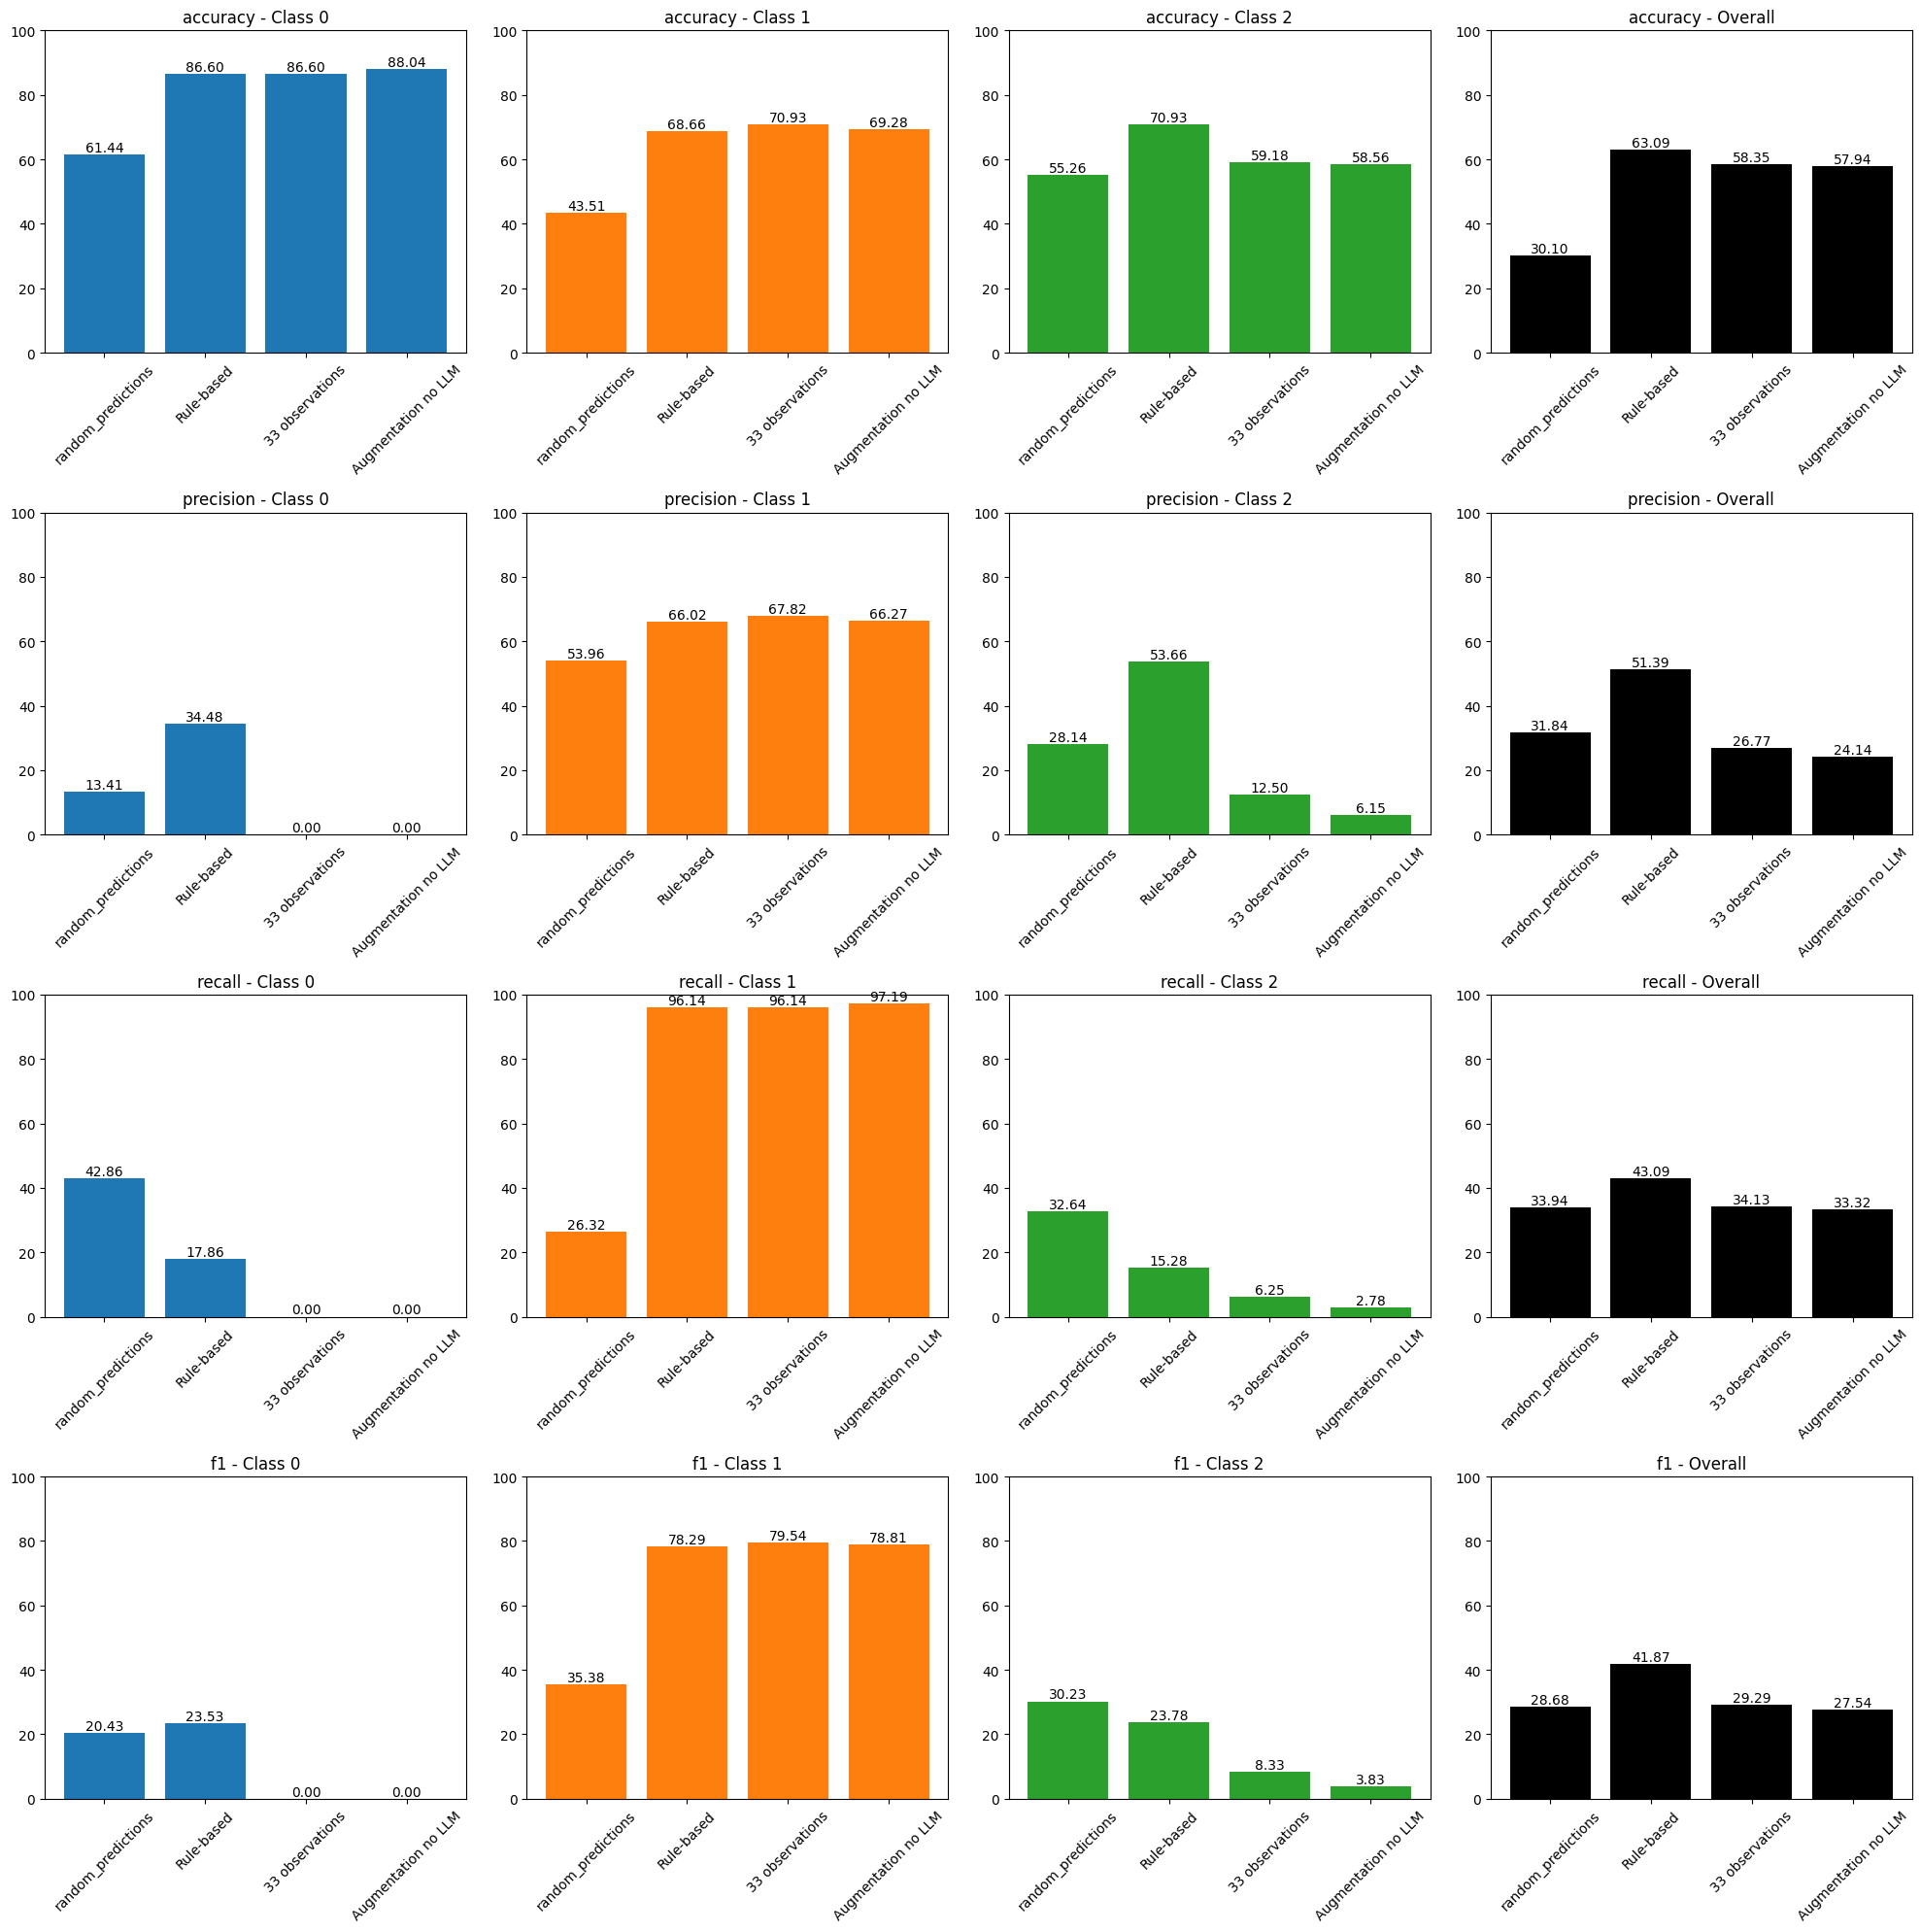

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model_2.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_test.run(test_labels, test_preds, "Augmentation no LLM")
metrics_test.plot()

Looking at the overall metrics, we can observe that all the metrics are more or less the same when training the model with augmented data. Usually, models become better when you train them with more data. In this case, this is not happening because of the nature of the data. We added 100 observations of each label to the model, though, after giving them the new label with the model (trained with 33 observations) we had a high class imbalance. This shows, that the data has been misclassified a lot. As a result, the model has been trained with wrong data, explaining why the metrics are not improving.

### c. Zero-Shot Learning with LLM

In [ ]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Define the candidate labels
candidate_labels = [0, 1, 2]
# Perform zero-shot classification
test_preds_zero = []
for sentence in test_data:
    # Perform zero-shot classification for the current sentence
    preds = classifier(sentence, candidate_labels)

    # Find the label with the highest probability for the current sentence
    max_score_index = max(range(len(preds['scores'])), key=lambda i: preds['scores'][i])
    predicted_label = preds['labels'][max_score_index]

    # Append the predicted label to the list
    test_preds_zero.append(predicted_label)



No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


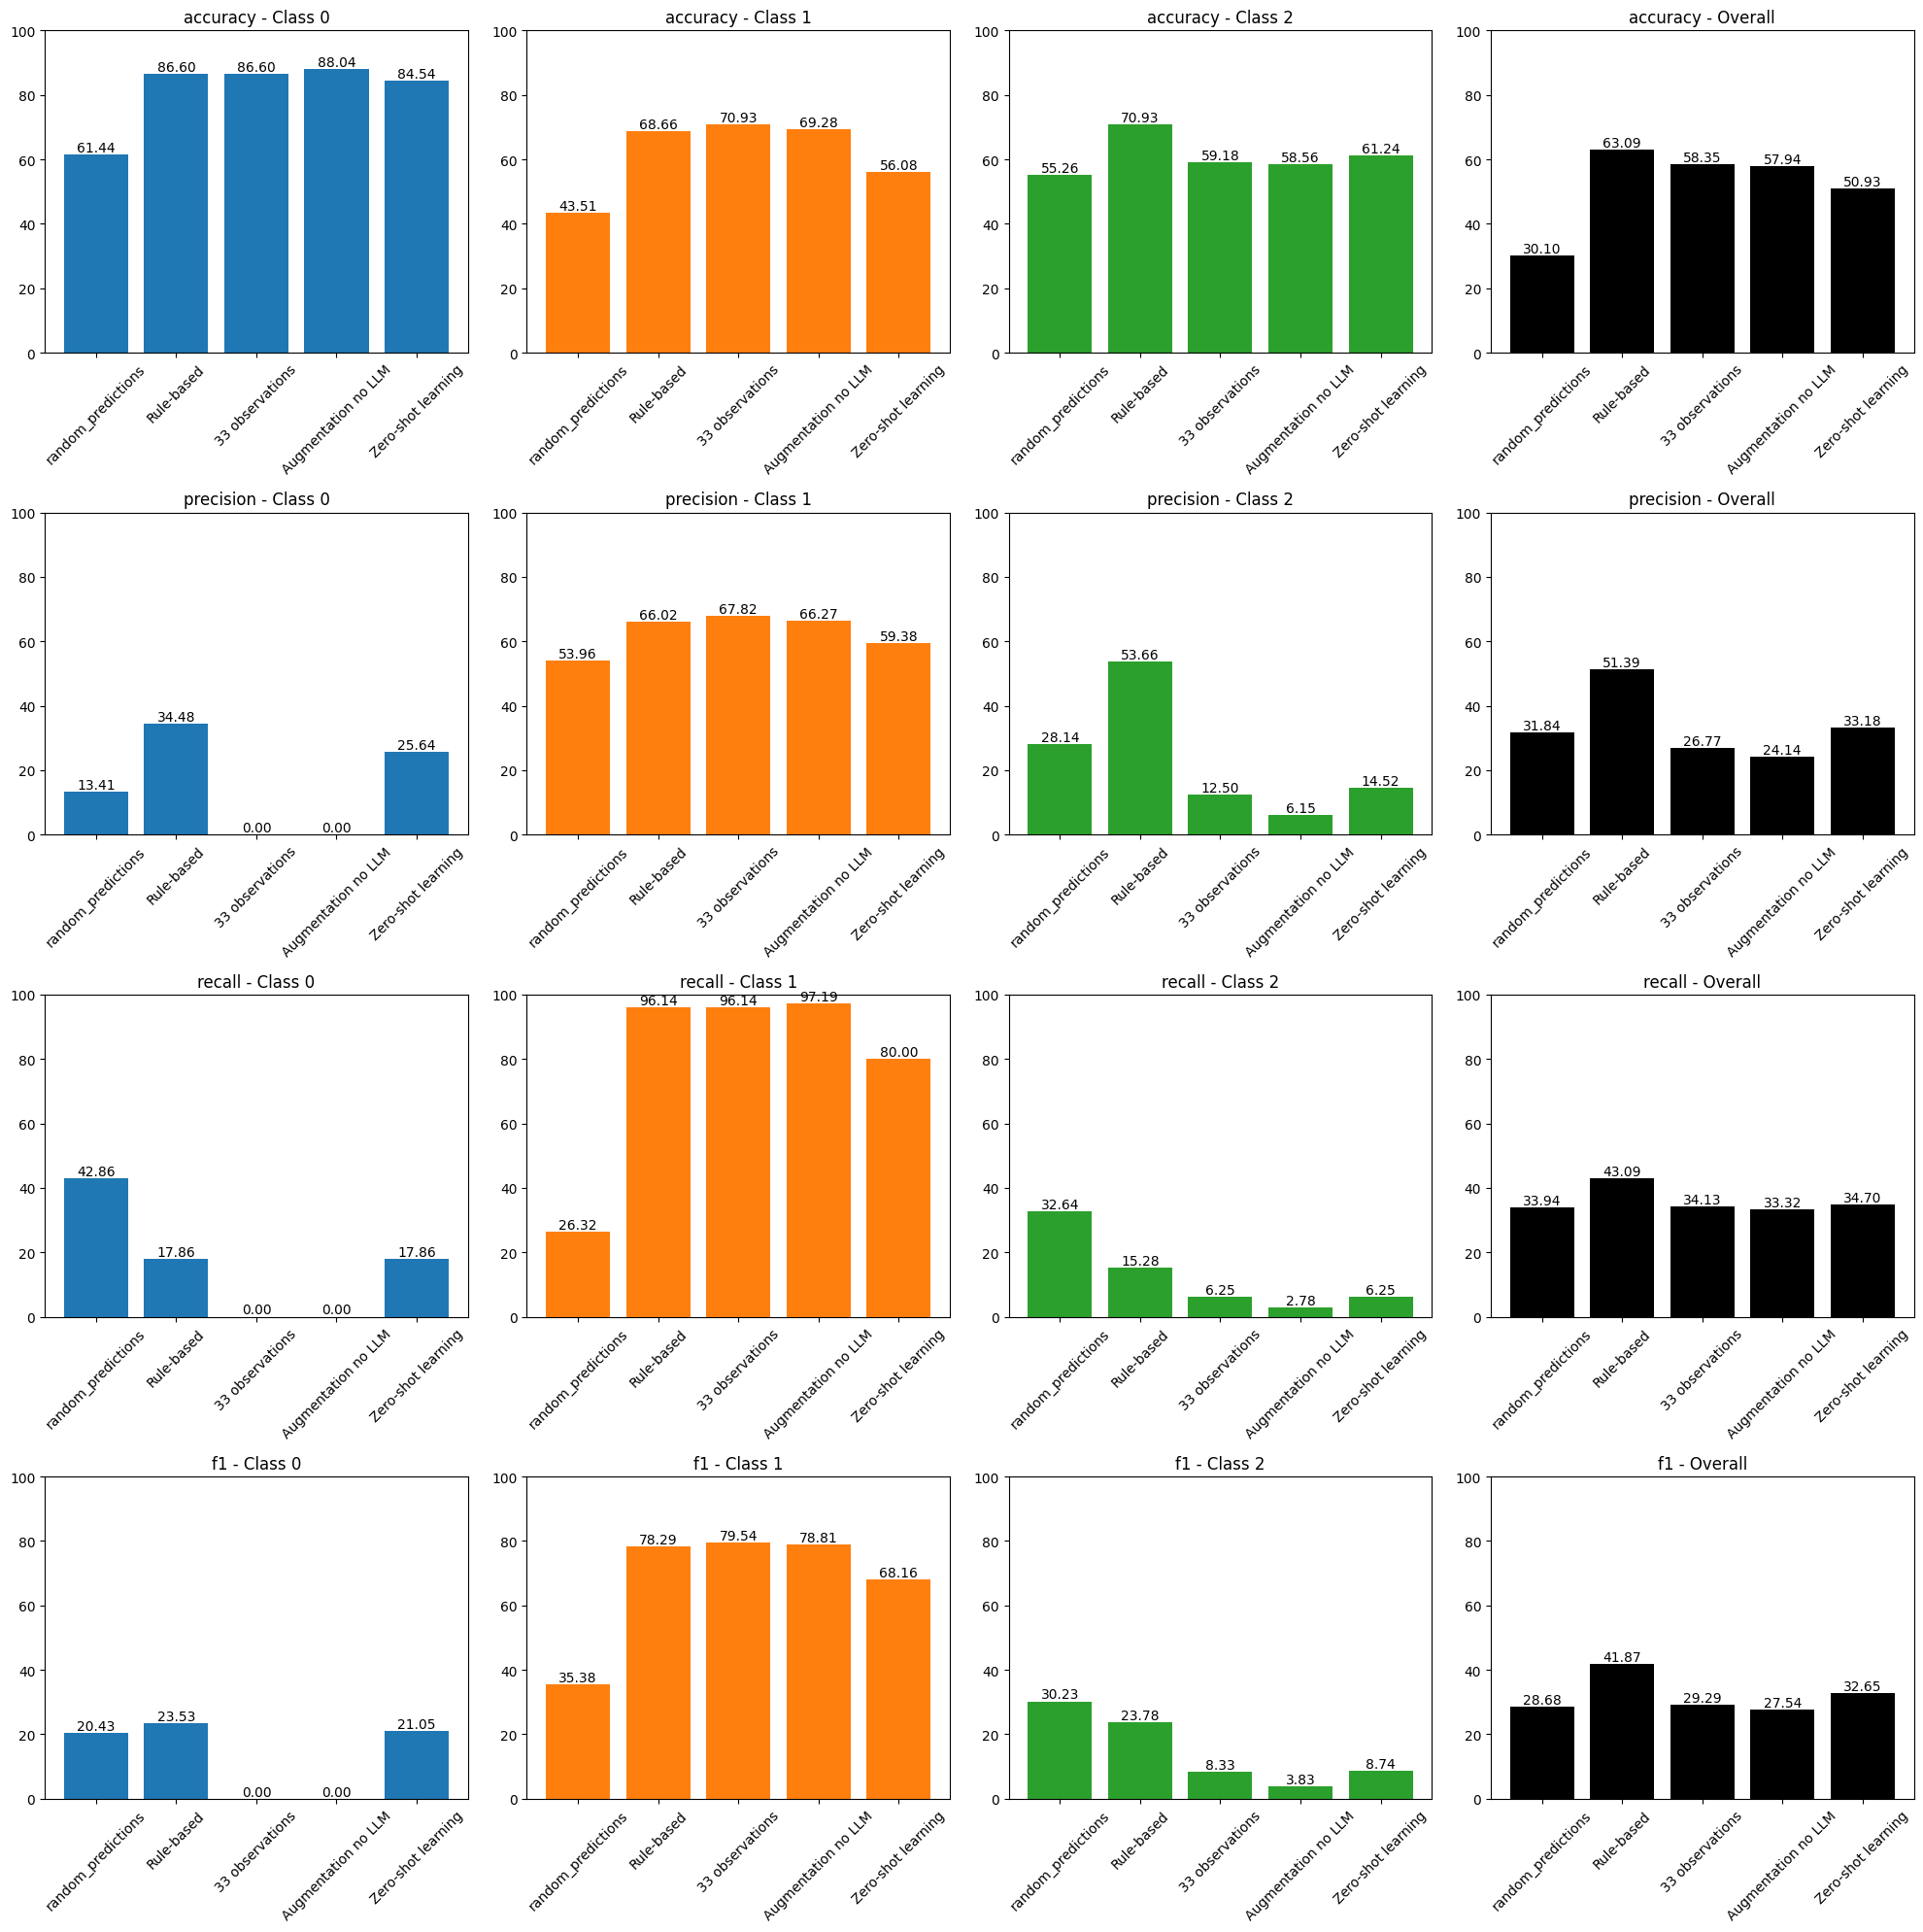

In [ ]:
metrics_test.run(test_labels, test_preds_zero, "Zero-shot learning")
metrics_test.plot()


From zero shot learning we see that it does improve the metrics in F1, precision and recall. While not really in accuracy. This suggests that the model was better than the last models in detecting the class minorities but lost a little bit of power in the majority class. The zero-shot model was not trained on any observations on our dataset. It is pre-trained through self-supervised learning and makes the predictions based on that. It's interesting since it works directly with the test_data which has 485 observations but it's quite imbalanced across labels.

### d. Data Generation with LLM

#### Create the data with ChatGPT

We use the 33 observations from before as input for the OpenAI API to create more examples for us to use as data augmentation.

In [ ]:
openai.api_key = 'api_key_here'

def generate_chat_observations(examples, label, n, model="gpt-3.5-turbo"):
    """
    Generate observations based on the few-shot examples provided, using a chat model.

    :param examples: The few-shot examples to base the generation on.
    :param label: The sentiment label for the generated text (Positive, Negative, Neutral).
    :param n: Number of observations to generate.
    :param model: The chat model to use for generation.
    :return: A list of generated observations with the specified label.
    """
    generated_observations = []
    prompt_messages = [{"role": "system", "content": f"Create different financial examples given the examples provided and the nature of the label ( {label} )"}]

    for example in examples:
        prompt_messages.append({"role": "user", "content": "Here\n " +"\n\n".join(example)})

    for _ in range(n):
        response = openai.ChatCompletion.create(
            model=model,
            messages=prompt_messages,
            temperature=0.7,
            max_tokens=100,
            n = n,
        )
        generated_text = response.choices[0].message['content'].strip()
        if generated_text:
            generated_observations.append(f"{generated_text}\n\n---\n{label}")

    return generated_observations


In [ ]:
#For positive
few_shot_positive = [
"Etteplan targets to employ at least 20 people in Borl+ñnge.",
    "Instead, Elcoteq has signed a non-binding Letter of Intent with another Asian strategic investor.",
    "Operating profit was EUR 139.7 mn, up 23% from EUR 113.8 mn.",
    "Nyrstar has also agreed to supply to Talvivaara up to 150,000 tonnes of sulphuric acid per annum for use in Talvivaara's leaching process during the period of supply of the zinc in concentrate.",
    "In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.",
    "Finnish stationery and gift retailer Tiimari HEL: TII1V said today its net sales rose by 2% year-on-year to EUR5.7 m in August 2010, driven by growth in Finland, while demand in the Baltics remained weak.",
    "Operating result including non-recurring items rose to EUR 146mn from a loss of EUR 267mn in 2009.",
    "AUSTIN, Texas, Sept. 6 -- Texas Department Of Transportation awards contract for Teleste Video Compression and Distribution Equipment.",
    "The new technology improves the glass quality and consistency while increasing throughput.",
    "Comptel, a vendor of dynamic Operations Support System (OSS) software, has been selected by Orascom Telecom (OTH) as partner for provisioning and activation solutions for mobile services.",
    "MANAVIGATOR-September 7, 2010-Kemira unveils Indian JV with IVRCL Finnish chemicals group Kemira (HEL: KRA1V) on Tuesday announced it has inked a deal to form a joint venture in India with local construction firm IVRCL Infrastructure and Projects Ltd (BOM:530773)."
]

In [ ]:
few_shot_negative= [ "In Q1 of 2009, Bank of +àland's net interest income weakened by 10% to EUR 9.1 mn. \n\n---\nNegative",
    "Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola, in Finland. \n\n---\nNegative",
    "Pretax profit decreased by 37% to EUR 193.1 mn from EUR 305.6 mn.\n\n---\nNegative",
    "Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ($40.2 mln) for the first half of 2008 from 25.4 mln euro ($40.7 mln) for the same period of 2007. \n\n---\nNegative",
    "Operating loss before non-recurring items was EUR 0.9 mn, compared to a profit of EUR 11.5 mn in 2008. \n\n---\nNegative",
    "Finnair believes the strike will cause it daily net losses in excess of EUR 2mn due to canceled reservations and passenger re-routing. \n\n---\nNegative",
    "Net sales dropped by 6% year-on-year to EUR 11.9 million. \n\n---\nNegative",
    "18 March 2010 A leakage in the gypsum pond was detected today at the Talvivaara mine. \n\n---\nNegative",
    "ADP News - May 29, 2009 - Bank of America BofA downgraded today its ratings on Swedish-Finnish paper maker Stora Enso Oyj HEL: STERV and on Finnish sector player UPM-Kymmene Oyj HEL: UPM1V to ``underperf \n\n---\nNegative",
    "Finnish stationery and gift retailer Tiimari HEL: TII1V said yesterday that it will cut a total of 28 jobs in its units Tiimari Retail Ltd and Gallerix Finland Ltd as a result of the closure of shops. \n\n---\nNegative",
    "The EU Commission said earlier it had fined ThyssenKrupp, United Technologies Corp's Otis, Schindler AG and Kone Oyj a total of 992.3 mln eur for alleged cartel activity in the lift market going back twelve years. \n\n---\nNegative",
]

In [ ]:
few_shot_neutral= [ "An estimated 30 pct of mobile calls are made from the home, and France Telecom hopes that 15 pct of its Orange clients will sign up for the service by the end of 2008.",
    "The acquired business main asset is a mobile authentication and signing solution, branded as Tectia MobileID, which provides authentication to web e-mail, SSL-VPN, MS SharePoint, Tectia Secure Solutions and other applications and resources.",
    "Aug. 17, 2010 (Curbed delivered by Newstex) -- And now, the latest from Racked, covering shopping and retail from the sidewalks up.",
    "Profit after taxes totaled EUR 12.1 mn.",
    "However, the production is almost entirely very labor intensive and based on small investments only.",
    "They are responsible for their own operations, customer relationships, and the development of these.",
    "Technopolis's technological centers supply their clients with modern high-class premises.",
    "In Asia earlier, Japan's Nikkei index fell 0.62 percent and Hong Kong's Hang Seng Index rose 0.56 percent.",
    "According to statistics by the Finnish Maritime Administration, shipping did not increase much in January-August 2009, however.",
    "Atria chose the DeLight to attract consumers in the 25-45 age group to its Atria Fresh range of microwaveable meals.",
    "F-Secure Online Backup automatically protects all the content stored on a computer or smartphone by making a copy of the content to an online location.",
 ]


In [ ]:
# Assuming the generate_chat_observations function is defined as in your initial message

# Initialize DataFrames for positive, negative, and neutral observations
df_positive = pd.DataFrame(columns=["text"])
df_negative = pd.DataFrame(columns=["text"])
df_neutral = pd.DataFrame(columns=["text"])

#Since we can only do 3 requests per minute

for _ in range(50):
    # Generate positive observations and add to DataFrame
    positive_observations = generate_chat_observations(few_shot_positive, "Positive", n=1)
    df_positive = pd.concat([df_positive, pd.DataFrame({"text": positive_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

    # Generate negative observations and add to DataFrame
    negative_observations = generate_chat_observations(few_shot_negative, "Negative", n=1)
    df_negative = pd.concat([df_negative, pd.DataFrame({"text": negative_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

    # Generate neutral observations and add to DataFrame
    neutral_observations = generate_chat_observations(few_shot_neutral, "Neutral", n=1)
    df_neutral = pd.concat([df_neutral, pd.DataFrame({"text": neutral_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

# Combine all DataFrames into one
df_all = pd.concat([df_positive, df_negative, df_neutral], ignore_index=True)


In [ ]:
# Save the DataFrame to a CSV file if needed
df_all.to_csv("all_observations50.csv", index=False)

In [ ]:
# With n= 1 final
pd.set_option('display.max_colwidth', 1000)

print(df_all['text'])

0                                                                                  - In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.\n- Operating profit was EUR 139.7 million, up 23% from EUR 113.8 million.\n- Nyrstar has also agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process during the period of supply of the zinc concentrate.\n- Operating result\n\n---\nPositive
1                                                                                                       - The operating profit increased by 23% from EUR 113.8 mn to EUR 139.7 mn.\n- Nyrstar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talvivaara's leaching process.\n- In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.\n- Finnish stationery and gift retailer Tiimari reported a\n\n---\nPositive
2                                                   

Here, we noticed that each observation had up to 3 different statements so we cleaned the data.

In [ ]:
# Initialize a list to hold the new rows
new_rows = []

# Regular expression to find the sentiment label at the end of the observation
label_regex = r"\n\n---\n(Positive|Negative|Neutral)$"

# Iterate through each row in the DataFrame
for index, row in df_all.iterrows():
    # Extract the observation text
    observation = row['text']
    # Extract the sentiment label
    label_match = re.search(label_regex, observation)
    if label_match:
        label = label_match.group(1)
        # Remove the sentiment label from the observation text
        observation = re.sub(label_regex, "", observation)
        # Split the observation into individual statements
        statements = re.split(r"\n- |1\. |2\. |3\. |4\. |5\. ", observation)
        # Filter out empty statements
        statements = [statement for statement in statements if statement.strip()]
        # Add each statement as a new row with its label to the new_rows list
        for statement in statements:
            new_rows.append({"statement": statement, "label": label})

# Create a new DataFrame from the new_rows list
df_llm = pd.DataFrame(new_rows)

df_llm.head()


,statement,label
0,"Positive financial example: \n\nCompany XYZ reported a record-breaking revenue of $500 million in the third quarter of 2021, marking a 15% increase from the same period last year. This growth was driven by strong demand for their innovative products in both domestic and international markets. Additionally, the company's operating margin expanded to 20%, reflecting improved efficiency and cost management strategies implemented by the management team.",Positive
1,"- The company reported a 23% increase in operating profit, reaching EUR 139.7 million from EUR 113.8 million.",Positive
2,"Nyrstar has agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process.",Positive
3,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000 from EUR 600,000.",Positive
4,Finnish stationery and gift retailer,Positive


In [ ]:
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Apply the mapping to the 'label' column
df_llm['label'] = df_llm['label'].map(label_mapping)

df_llm.head()

,statement,label
0,"Positive financial example: \n\nCompany XYZ reported a record-breaking revenue of $500 million in the third quarter of 2021, marking a 15% increase from the same period last year. This growth was driven by strong demand for their innovative products in both domestic and international markets. Additionally, the company's operating margin expanded to 20%, reflecting improved efficiency and cost management strategies implemented by the management team.",2
1,"- The company reported a 23% increase in operating profit, reaching EUR 139.7 million from EUR 113.8 million.",2
2,"Nyrstar has agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process.",2
3,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000 from EUR 600,000.",2
4,Finnish stationery and gift retailer,2


In [ ]:
df_llm.to_csv("all_observations.csv", index=False)

In [ ]:
df_llm = pd.read_csv("all_observations.csv")

In [ ]:
df_llm[10:25]

,statement,label
10,"Nyrstar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in the leaching process in Talvivaara.",2
11,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000 from EUR 600,000.",2
12,The new technology improves glass quality and consistency while increasing throughput,2
13,"The company reported a significant increase in operating profit, totaling EUR 139.7 million, up 23% from EUR 113.8 million in the previous period.\r\n\r\n",2
14,"Nyrstar has agreed to supply up to 150,000 tonnes of sulphuric acid annually for use in Talviivara's leaching process during the zinc concentrate supply period.\r\n\r\n",2
15,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000",2
16,"- The company operating profit increased by 23% to EUR 139.7 million, up from EUR 113.8 million.",2
17,"Nyrstar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in the leaching process in Talviivara.",2
18,"In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.",2
19,Finnish stationery and gift retailer Tiim,2


In [ ]:
df_filtered = df_llm[df_llm['statement'].apply(lambda x: len(x.split()) >= 3)] #To deal with the "Positive financial example:"

In [ ]:
df_llm.shape

(552, 2)

In [ ]:
# with n = 3
pd.set_option('display.max_colwidth', 1000)

print(df_all['text'])

0                                                                                                                                                                                                           - Operating profit increased by 23% to EUR 139.7 million, up from EUR 113.8 million.\n- Nyrstar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivara's leaching process.\n- In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.\n- Finnish stationery and gift retailer Tiimari reported a\n\n---\nPositive
1                                                                                                                                                                                                         - Operating profit increased by 23% from EUR 113.8 million to EUR 139.7 million.\n- Nyrstar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in the leaching process in Talviivaara.\n- In th

#### Train the BERT model

To make the metrics comparable, we will use the same 33 observations and also choose 300 random oservations of the augmented one. We will again make sure to have a class balance.

In [ ]:
# Group observations by label
grouped = df_llm.groupby('label')

# Randomly select 11 observations for each label
llm_sub_df = grouped.apply(lambda x: x.sample(100, random_state=42)).reset_index(drop=True)

# Reset index of the resulting DataFrame
llm_sub_df.reset_index(drop=True, inplace=True)

# Display the resulting subset DataFrame
llm_sub_df

,statement,label
0,Finnish metal products company Componenta Oyj's net profit slightly decreased to 25.1 mn,0
1,Finnish metal products company Componenta Oyj's net profit slightly went down to 25.,0
2,"Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tamper and two in Nasotola, Finland.",0
3,Pre-tax profit decreased by 37% to EUR 193.1 mn from EUR 305.6 mn.,0
4,"The company's quarterly revenue decreased by 15% compared to the same period last year, resulting in a loss of $2.5 million.\r\n",0
...,...,...
295,"Group's pretax loss narrowed to EUR 400,000 from EUR 600,000 in the second quarter of 2010.",2
296,Tiimari reported a 2% year-on-year increase in net sales to EUR 5.7,2
297,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000 from EUR 600,000.",2
298,"Positive financial example: \r\n\r\nCompany XYZ reported a record-breaking revenue of $500 million in the third quarter of 2021, marking a 15% increase from the same period last year. This growth was driven by strong demand for their innovative products in both domestic and international markets. Additionally, the company's operating margin expanded to 20%, reflecting improved efficiency and cost management strategies implemented by the management team.",2


In [ ]:
# rename columns to concatenate them
llm_sub_df.rename(columns={"statement": "text"}, inplace=True)

In [ ]:
train_sub_df_3 = pd.concat([train_sub_df, llm_sub_df])

In [ ]:
train_sub_df_3

,text,label
0,"In Q1 of 2009 , Bank of +àland 's net interest income weakened by 10 % to EUR 9.1 mn .",0
1,"Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola , in Finland .",0
2,Pretax profit decreased by 37 % to EUR 193.1 mn from EUR 305.6 mn .,0
3,Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ( $ 40.2 mln ) for the first half of 2008 from 25.4 mln euro ( $ 40.7 mln ) for the same period of 2007 .,0
4,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 .",0
...,...,...
295,"Group's pretax loss narrowed to EUR 400,000 from EUR 600,000 in the second quarter of 2010.",2
296,Tiimari reported a 2% year-on-year increase in net sales to EUR 5.7,2
297,"In the second quarter of 2010, the group's pre-tax loss narrowed to EUR 400,000 from EUR 600,000.",2
298,"Positive financial example: \r\n\r\nCompany XYZ reported a record-breaking revenue of $500 million in the third quarter of 2021, marking a 15% increase from the same period last year. This growth was driven by strong demand for their innovative products in both domestic and international markets. Additionally, the company's operating margin expanded to 20%, reflecting improved efficiency and cost management strategies implemented by the management team.",2


In [ ]:
# Load the model again
model_3 = TFAutoModel.from_pretrained("ProsusAI/finbert")

batch_size=32
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(train_labels))

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Freeze Layers of FinBERT
for layer in model_3.layers:
    layer.trainable = False

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_3(input_ids=input_ids_in, attention_mask=input_masks_in)

final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model_3 = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model_3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model_3 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_token[0][0]',         
 el)                         ngAndCrossAttentions(last_   40         'masked_token[0][0]']        
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_sub_df_3['label']).reshape(-1, 1)).toarray()

In [ ]:
X_train = np.array(train_sub_df_3['text'])

steps_per_epoch = int(len(X_train) / batch_size)

# Create batches generator
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model_3.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Use 5 epochs because of relatively small dataset
bert_model_3.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5


10/10 [==============================] - 57s 3s/step - loss: 0.9816 - recall_12: 0.5188 - precision_12: 0.6217
Epoch 2/5
10/10 [==============================] - 29s 3s/step - loss: 0.3041 - recall_12: 0.8671 - precision_12: 0.8969
Epoch 3/5
10/10 [==============================] - 29s 3s/step - loss: 0.1605 - recall_12: 0.9402 - precision_12: 0.9497
Epoch 4/5
10/10 [==============================] - 30s 3s/step - loss: 0.1104 - recall_12: 0.9535 - precision_12: 0.9663
Epoch 5/5
10/10 [==============================] - 29s 3s/step - loss: 0.0491 - recall_12: 0.9867 - precision_12: 0.9933


In [ ]:
# Save the weight
bert_model_3.save_weights('./bert_model_augmentation_llm.h5')

In [ ]:
# Load the model
bert_model_3.load_weights("bert_model_augmentation_llm.h5")

16/16 [==============================] - 15s 746ms/step


C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


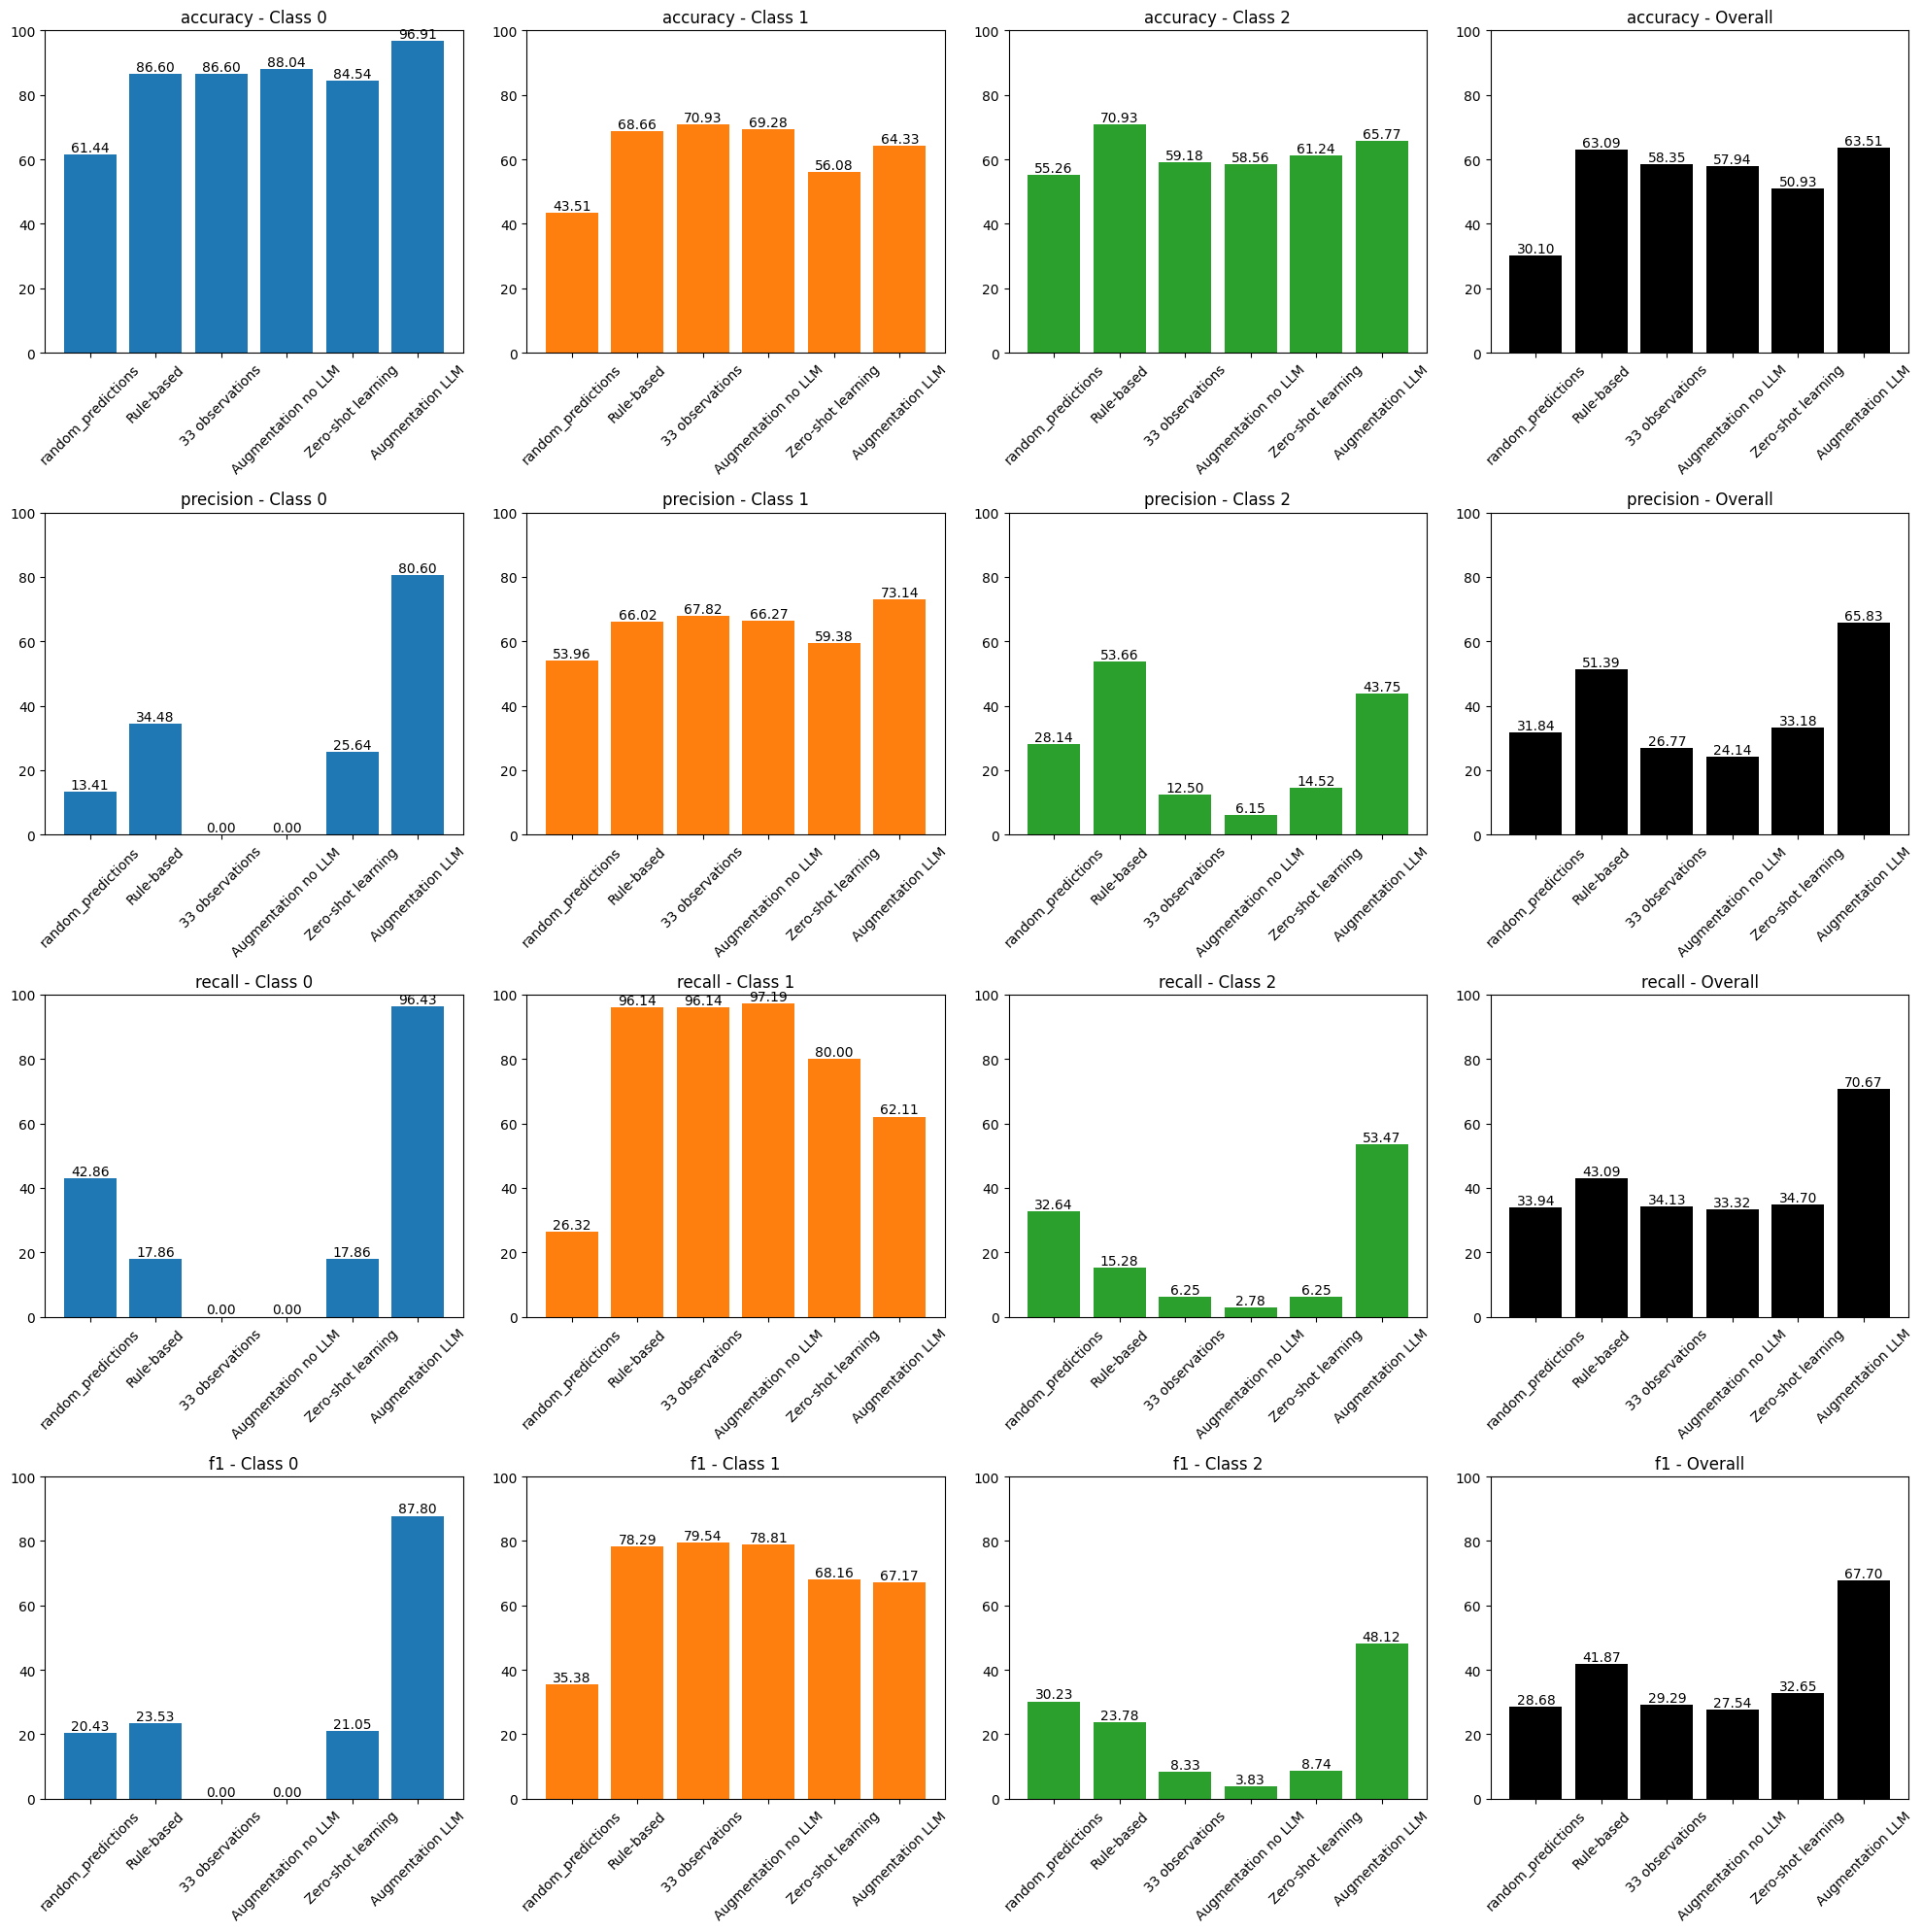

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model_3.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_test.run(test_labels, test_preds, "Augmentation LLM")
metrics_test.plot()

From the results we get, we see that all around the best metrics are from the new LLM model. Interesting, because from what we saw in the output from the API the new 300 observations were similar to the original 33 labeled observations with some changes like in the structure or using synonym words. We can infer that it's obviously better than just 33 labels, also better than a not so good fine tuned data augmentation and better than the zero shot learning because it actually has been trained with data from the training set. So with the increase of data with examples similar to the original 33 we see that the model did improve.

### e. Optimal Technique Application

In terms of optimization, since the LLM augmentation was the best result. We decided to now take 60 random observations (20 per label) from the train set to expand our example pool for the API implementation, and run it again to check if with more examples the model would improve.

#### Augmentation of data with ChatGPT

In [ ]:
pd.set_option('display.max_colwidth', 1000)
random.seed(42)

# Create dataframe for test
train_df = pd.DataFrame({'text': train_data, 'label': train_labels})

# Group observations by label
grouped = train_df.groupby('label')

# Randomly select 11 observations for each label
train_sub_df = grouped.apply(lambda x: x.sample(20, random_state=42)).reset_index(drop=True)

# Reset index of the resulting DataFrame
train_sub_df.reset_index(drop=True, inplace=True)

# Display the resulting subset DataFrame
train_sub_df

,text,label
0,"In Q1 of 2009 , Bank of +àland 's net interest income weakened by 10 % to EUR 9.1 mn .",0
1,"Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola , in Finland .",0
2,Pretax profit decreased by 37 % to EUR 193.1 mn from EUR 305.6 mn .,0
3,Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ( $ 40.2 mln ) for the first half of 2008 from 25.4 mln euro ( $ 40.7 mln ) for the same period of 2007 .,0
4,"Operating loss before non-recurring items was EUR 0.9 mn , compared to a profit of EUR 11.5 mn in 2008 .",0
5,Finnair believes the strike will cause it daily net losses in excess of EUR 2mn due to canceled reservations and passenger re-routing .,0
6,Net sales dropped by 6 % year-on-year to EUR 11.9 million .,0
7,18 March 2010 A leakage in the gypsum pond was detected today at the Talvivaara mine .,0
8,"ADP News - May 29 , 2009 - Bank of America BofA downgraded today its ratings on Swedish-Finnish paper maker Stora Enso Oyj HEL : STERV and on Finnish sector player UPM-Kymmene Oyj HEL : UPM1V to `` underperf",0
9,stores 16 March 2010 - Finnish stationery and gift retailer Tiimari HEL : TII1V said yesterday that it will cut a total of 28 jobs in its units Tiimari Retail Ltd and Gallerix Finland Ltd as a result of the closure of shops .,0


In [ ]:
few_shot_negative = [
    "In Q1 of 2009, Bank of +àland's net interest income weakened by 10% to EUR 9.1 mn.",
    "Finnish Suominen Flexible Packaging is cutting 48 jobs in its unit in Tampere and two in Nastola, in Finland.",
    "Pretax profit decreased by 37% to EUR 193.1 mn from EUR 305.6 mn.",
    "Finnish metal products company Componenta Oyj net profit went slightly down to 25.1 mln euro ($40.2 mln) for the first half of 2008 from 25.4 mln euro ($40.7 mln) for the same period of 2007.",
    "Operating loss before non-recurring items was EUR 0.9 mn, compared to a profit of EUR 11.5 mn in 2008.",
    "Finnair believes the strike will cause it daily net losses in excess of EUR 2mn due to canceled reservations and passenger re-routing.",
    "Net sales dropped by 6% year-on-year to EUR 11.9 million.",
    "18 March 2010 A leakage in the gypsum pond was detected today at the Talvivaara mine.",
    "ADP News - May 29, 2009 - Bank of America BofA downgraded today its ratings on Swedish-Finnish paper maker Stora Enso Oyj HEL: STERV and on Finnish sector player UPM-Kymmene Oyj HEL: UPM1V to ``underperf",
    "stores 16 March 2010 - Finnish stationery and gift retailer Tiimari HEL: TII1V said yesterday that it will cut a total of 28 jobs in its units Tiimari Retail Ltd and Gallerix Finland Ltd as a result of the closure of shops.",
    "The EU Commission said earlier it had fined ThyssenKrupp, United Technologies Corp's Otis, Schindler AG and Kone Oyj a total of 992.3 mln eur for alleged cartel activity in the lift market going back twelve years.",
    "On top of that, the US Commerce Department published worse-than-expected construction spending figures for November.",
    "Commission income decreased to EUR 3.8 mn, compared to EUR 4.6 mn in the third quarter of 2007.",
    "Compared with the FTSE 100 index, which rose 36.7 points (or 0.6%) on the day, this was a relative price change of -0.2%.",
    "Temporary lay-offs, affecting the entire workforce, will also be implemented.",
    "Cash flow from operations in January-December 2008 was a negative EUR 18.1 mn compared to EUR 39.0 mn in the corresponding period in 2007.",
    "Sales at the unit slumped last year after the industry was hit by poor snowfall in the major resorts in the winter of 2006-07.",
    "The OMX Helsinki 25 ended 0.47 pct lower at 3,150.55 and the OMX Helsinki was down 0.21 pct at 10,736.42 on 1.523 bln eur turnover.",
    "The Department Store Division's sales fell by 8.6% to EUR 140.2 mn.",
    "It generated an operating loss of EUR 96.3 mn, down from a profit of EUR 43.9 mn."]

few_shot_neutral = ["An estimated 30 pct of mobile calls are made from the home, and France Telecom hopes that 15 pct of its Orange clients will sign up for the service by the end of 2008.",
    "The acquired business main asset is a mobile authentication and signing solution, branded as Tectia MobileID, which provides authentication to web e-mail, SSL-VPN, MS SharePoint, Tectia Secure Solutions and other applications and resources.",
    "Aug. 17, 2010 (Curbed delivered by Newstex) -- And now, the latest from Racked, covering shopping and retail from the sidewalks up.",
    "Profit after taxes totaled EUR 12.1 mn.",
    "However, the production is almost entirely very labor intensive and based on small investments only.",
    "They are responsible for their own operations, customer relationships, and the development of these.",
    "Technopolis's technological centers supply their clients with modern high-class premises.",
    "In Asia earlier, Japan's Nikkei index fell 0.62 percent and Hong Kong's Hang Seng Index rose 0.56 percent.",
    "According to statistics by the Finnish Maritime Administration, shipping did not increase much in January-August 2009, however.",
    "Atria chose the DeLight to attract consumers in the 25-45 age group to its Atria Fresh range of microwaveable meals.",
    "F-Secure Online Backup automatically protects all the content stored on a computer or smartphone by making a copy of the content to an online location.",
    "Finnish power company Fortum reports 89% of its electricity was generated without carbon dioxide emissions in 2007.",
    "Finnish property investment company Citycon plans to issue directed subordinated convertible bonds to institutional investors.",
    "The maximum amount of the capital loan will be EUR30m and the minimum subscription -- EUR10,000.",
    "The company operates a U.S. division in Lisle, Ill..",
    "Okmetic's silicon wafers are part of a further processing chain that produces end products that improve human interaction and quality of life.",
    "FinancialWire(tm), in cooperation with the Investrend Broadcast Syndicate, also provides complete, daily conference call and webcast schedules as a service to shareholders and investors via the FirstAlert(tm) Networks oeFirstAlert(tm) Daily.",
    "With Aldata, we can help retailers ensure that their merchandising and selections reflect customer demand and their evolving shopping behavior.''",
    "Following the move, Stora Enso holding in NewPage will remain unchanged.",
    "Delivery will start immediately in June 2008 and will be completed in 2008.",
    "Etteplan targets to employ at least 20 people in Borl+ñnge."]

few_shot_positive = ["Etteplan targets to employ at least 20 people in Borl+ñnge.",
    "Instead, Elcoteq has signed a non-binding Letter of Intent with another Asian strategic investor.",
    "Operating profit was EUR 139.7 mn, up 23% from EUR 113.8 mn.",
    "Nyrstar has also agreed to supply to Talvivaara up to 150,000 tonnes of sulphuric acid per annum for use in Talvivaara's leaching process during the period of supply of the zinc in concentrate.",
    "In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600,000.",
    "9 September 2010 - Finnish stationery and gift retailer Tiimari HEL: TII1V said today its net sales rose by 2% year-on-year to EUR5.7 m in August 2010, driven by growth in Finland, while demand in the Baltics remained weak.",
    "Operating result including non-recurring items rose to EUR 146mn from a loss of EUR 267mn in 2009.",
    "AUSTIN, Texas, Sept. 6 -- Texas Department Of Transportation awards contract for Teleste Video Compression and Distribution Equipment.",
    "The new technology improves the glass quality and consistency while increasing throughput.",
    "Comptel, a vendor of dynamic Operations Support System (OSS) software, has been selected by Orascom Telecom (OTH) as partner for provisioning and activation solutions for mobile services.",
    "MANAVIGATOR-September 7, 2010-Kemira unveils Indian JV with IVRCL Finnish chemicals group Kemira (HEL: KRA1V) on Tuesday announced it has inked a deal to form a joint venture in India with local construction firm IVRCL Infrastructure and Projects Ltd (BOM:530773).",
    "BasWare's CEO Ilkka Sihvo comments in conjunction with the Interim Report: ``As a whole, BasWare succeeded well in the second quarter of 2007.",
    "Pretax profit rose to EUR 1,019 mn from EUR 1,007 in the corresponding period in 2005.",
    "Sales came in at 241 mln eur, compared with 211.4 mln, and also beating consensus forecasts of 235 mln eur.",
    "Ruukki announced that it has signed an agreement with Aker Solutions of Norway to supply 24 suction anchors in September 2010 from its Kalajoki unit in Finland.",
    "Orion Pharma's operating profit increased by 42.5% from 2004.",
    "However, Simdax will remain available in the markets where it already has been approved as it has marketing authorisations or submitted applications in more than 40 countries, Orion added.",
    "Via the takeover, Panostaja further expands its business area specialising in digital printing, which since previously consists of the subsidiaries Kopijyva Oy and Sokonet Oy.",
    "(ADP News) - Oct 1, 2008 - Finnish consulting and engineering company Poyry Oyj (OMX: POY1V) said today it was awarded a EUR 5.2 million (USD 7.4 m) extension to their existing consultancy engineering contract with Venezuel",
    "Shareholders of Rakvere Lihakombinaat decided in favor of the buyout of minority shares in mid-July."
]

In [ ]:
# Initialize DataFrames for positive, negative, and neutral observations
df_positive = pd.DataFrame(columns=["text"])
df_negative = pd.DataFrame(columns=["text"])
df_neutral = pd.DataFrame(columns=["text"])

#Since we can only do 3 requests per minute

for _ in range(50):
    # Generate positive observations and add to DataFrame
    positive_observations = generate_chat_observations(few_shot_positive, "Positive", n=1)
    df_positive = pd.concat([df_positive, pd.DataFrame({"text": positive_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

    # Generate negative observations and add to DataFrame
    negative_observations = generate_chat_observations(few_shot_negative, "Negative", n=1)
    df_negative = pd.concat([df_negative, pd.DataFrame({"text": negative_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

    # Generate neutral observations and add to DataFrame
    neutral_observations = generate_chat_observations(few_shot_neutral, "Neutral", n=1)
    df_neutral = pd.concat([df_neutral, pd.DataFrame({"text": neutral_observations})], ignore_index=True)
    time.sleep(20)  # Wait for 20 seconds

# Combine all DataFrames into one
df_all = pd.concat([df_positive, df_negative, df_neutral], ignore_index=True)

In [ ]:
# Save the DataFrame to a CSV file if needed
df_all.to_csv("all_observations_optimized.csv", index=False)

# With n= 1 final
pd.set_option('display.max_colwidth', 1000)

print(df_all['text'])

0                                                                                                                                                         - The company recorded a significant increase in operating profit, reaching EUR 139.7 million, up 23% from EUR 113.8 million.\n- Nyrtastar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process during the supply period of the zinc concentrate.\n- In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600\n\n---\nPositive
1                                                             1. The company reported a pre-tax profit increase of 15% from the previous year, reaching a total of USD 1.5 million.\n\n2. The technology company Simdax successfully expanded its market presence in over 40 countries, with approved marketing authorizations in each region.\n\n3. Orion Pharma's operating profit surged by 55.5% in the last quarter, showcasing their strong fin

In [ ]:
# Initialize a list to hold the new rows
new_rows = []

# Regular expression to find the sentiment label at the end of the observation
label_regex = r"\n\n---\n(Positive|Negative|Neutral)$"

# Iterate through each row in the DataFrame
for index, row in df_all.iterrows():
    # Extract the observation text
    observation = row['text']
    # Extract the sentiment label
    label_match = re.search(label_regex, observation)
    if label_match:
        label = label_match.group(1)
        # Remove the sentiment label from the observation text
        observation = re.sub(label_regex, "", observation)
        # Split the observation into individual statements
        statements = re.split(r"\n- |1\. |2\. |3\. |4\. |5\. ", observation)
        # Filter out empty statements
        statements = [statement for statement in statements if statement.strip()]
        # Add each statement as a new row with its label to the new_rows list
        for statement in statements:
            new_rows.append({"statement": statement, "label": label})

# Create a new DataFrame from the new_rows list
df_llm = pd.DataFrame(new_rows)

df_llm.head()

,statement,label
0,"- The company recorded a significant increase in operating profit, reaching EUR 139.7 million, up 23% from EUR 113.8 million.",Positive
1,"Nyrtastar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process during the supply period of the zinc concentrate.",Positive
2,"In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600",Positive
3,"The company reported a pre-tax profit increase of 15% from the previous year, reaching a total of USD 1.5 million.\n\n",Positive
4,"The technology company Simdax successfully expanded its market presence in over 40 countries, with approved marketing authorizations in each region.\n\n",Positive


In [ ]:
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Apply the mapping to the 'label' column
df_llm['label'] = df_llm['label'].map(label_mapping)

df_llm.head()

,statement,label
0,"- The company recorded a significant increase in operating profit, reaching EUR 139.7 million, up 23% from EUR 113.8 million.",2
1,"Nyrtastar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process during the supply period of the zinc concentrate.",2
2,"In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600",2
3,"The company reported a pre-tax profit increase of 15% from the previous year, reaching a total of USD 1.5 million.\n\n",2
4,"The technology company Simdax successfully expanded its market presence in over 40 countries, with approved marketing authorizations in each region.\n\n",2


In [ ]:
df_llm.shape

(635, 2)

In [ ]:
df_filtered = df_llm[df_llm['statement'].apply(lambda x: len(x.split()) >= 4)]

df_filtered.head()

,statement,label
0,"- The company recorded a significant increase in operating profit, reaching EUR 139.7 million, up 23% from EUR 113.8 million.",2
1,"Nyrtastar agreed to supply up to 150,000 tonnes of sulphuric acid per annum for use in Talviivaara's leaching process during the supply period of the zinc concentrate.",2
2,"In the second quarter of 2010, the group's pretax loss narrowed to EUR 400,000 from EUR 600",2
3,"The company reported a pre-tax profit increase of 15% from the previous year, reaching a total of USD 1.5 million.\n\n",2
4,"The technology company Simdax successfully expanded its market presence in over 40 countries, with approved marketing authorizations in each region.\n\n",2


In [ ]:
# rename columns to concatenate them
df_filtered.rename(columns={"statement": "text"}, inplace=True)

/var/folders/f_/gyff9ggs4m3g21vhrwp_rk200000gn/T/ipykernel_9830/3867017408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={"statement": "text"}, inplace=True)


In [ ]:
df_filtered.to_csv("all_observations_optimized_clean.csv", index=False)

In [ ]:
df_llm_2 = pd.read_csv("all_observations.csv")

#### Training the model

In [ ]:
# Load the model again
model_4 = TFAutoModel.from_pretrained("ProsusAI/finbert")

batch_size=32
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(train_labels))

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Freeze Layers of FinBERT
for layer in model_4.layers:
    layer.trainable = False

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model_4(input_ids=input_ids_in, attention_mask=input_masks_in)

final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model_4 = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model_5 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_token[0][0]',         
 el)                         ngAndCrossAttentions(last_   40         'masked_token[0][0]']        
                             hidden_state=(None, 64, 76                                           
                             8),                                                            

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(df_llm_2['label']).reshape(-1, 1)).toarray()

In [ ]:
X_train = np.array(df_llm_2['text'])

steps_per_epoch = int(len(X_train) / batch_size)

# Create batches generator
batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model_4.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

# Use 5 epochs because of relatively small dataset
bert_model_4.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
19/19 [==============================] - 71s 3s/step - loss: 0.6914 - recall_1: 0.6562 - precision_1: 0.7202
Epoch 2/5
19/19 [==============================] - 50s 3s/step - loss: 0.2230 - recall_1: 0.9140 - precision_1: 0.9233
Epoch 3/5
19/19 [==============================] - 50s 3s/step - loss: 0.1460 - recall_1: 0.9511 - precision_1: 0.9559
Epoch 4/5
19/19 [==============================] - 50s 3s/step - loss: 0.0961 - recall_1: 0.9629 - precision_1: 0.9662
Epoch 5/5
19/19 [==============================] - 54s 3s/step - loss: 0.0406 - recall_1: 0.9848 - precision_1: 0.9848


In [ ]:
# Save the weight
bert_model_4.save_weights('./bert_model_augmentation_llm_expanded.h5')

In [ ]:
# Load the model
bert_model_4.load_weights("bert_model_augmentation_llm_expanded.h5")

16/16 [==============================] - 16s 772ms/step


C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_24556\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


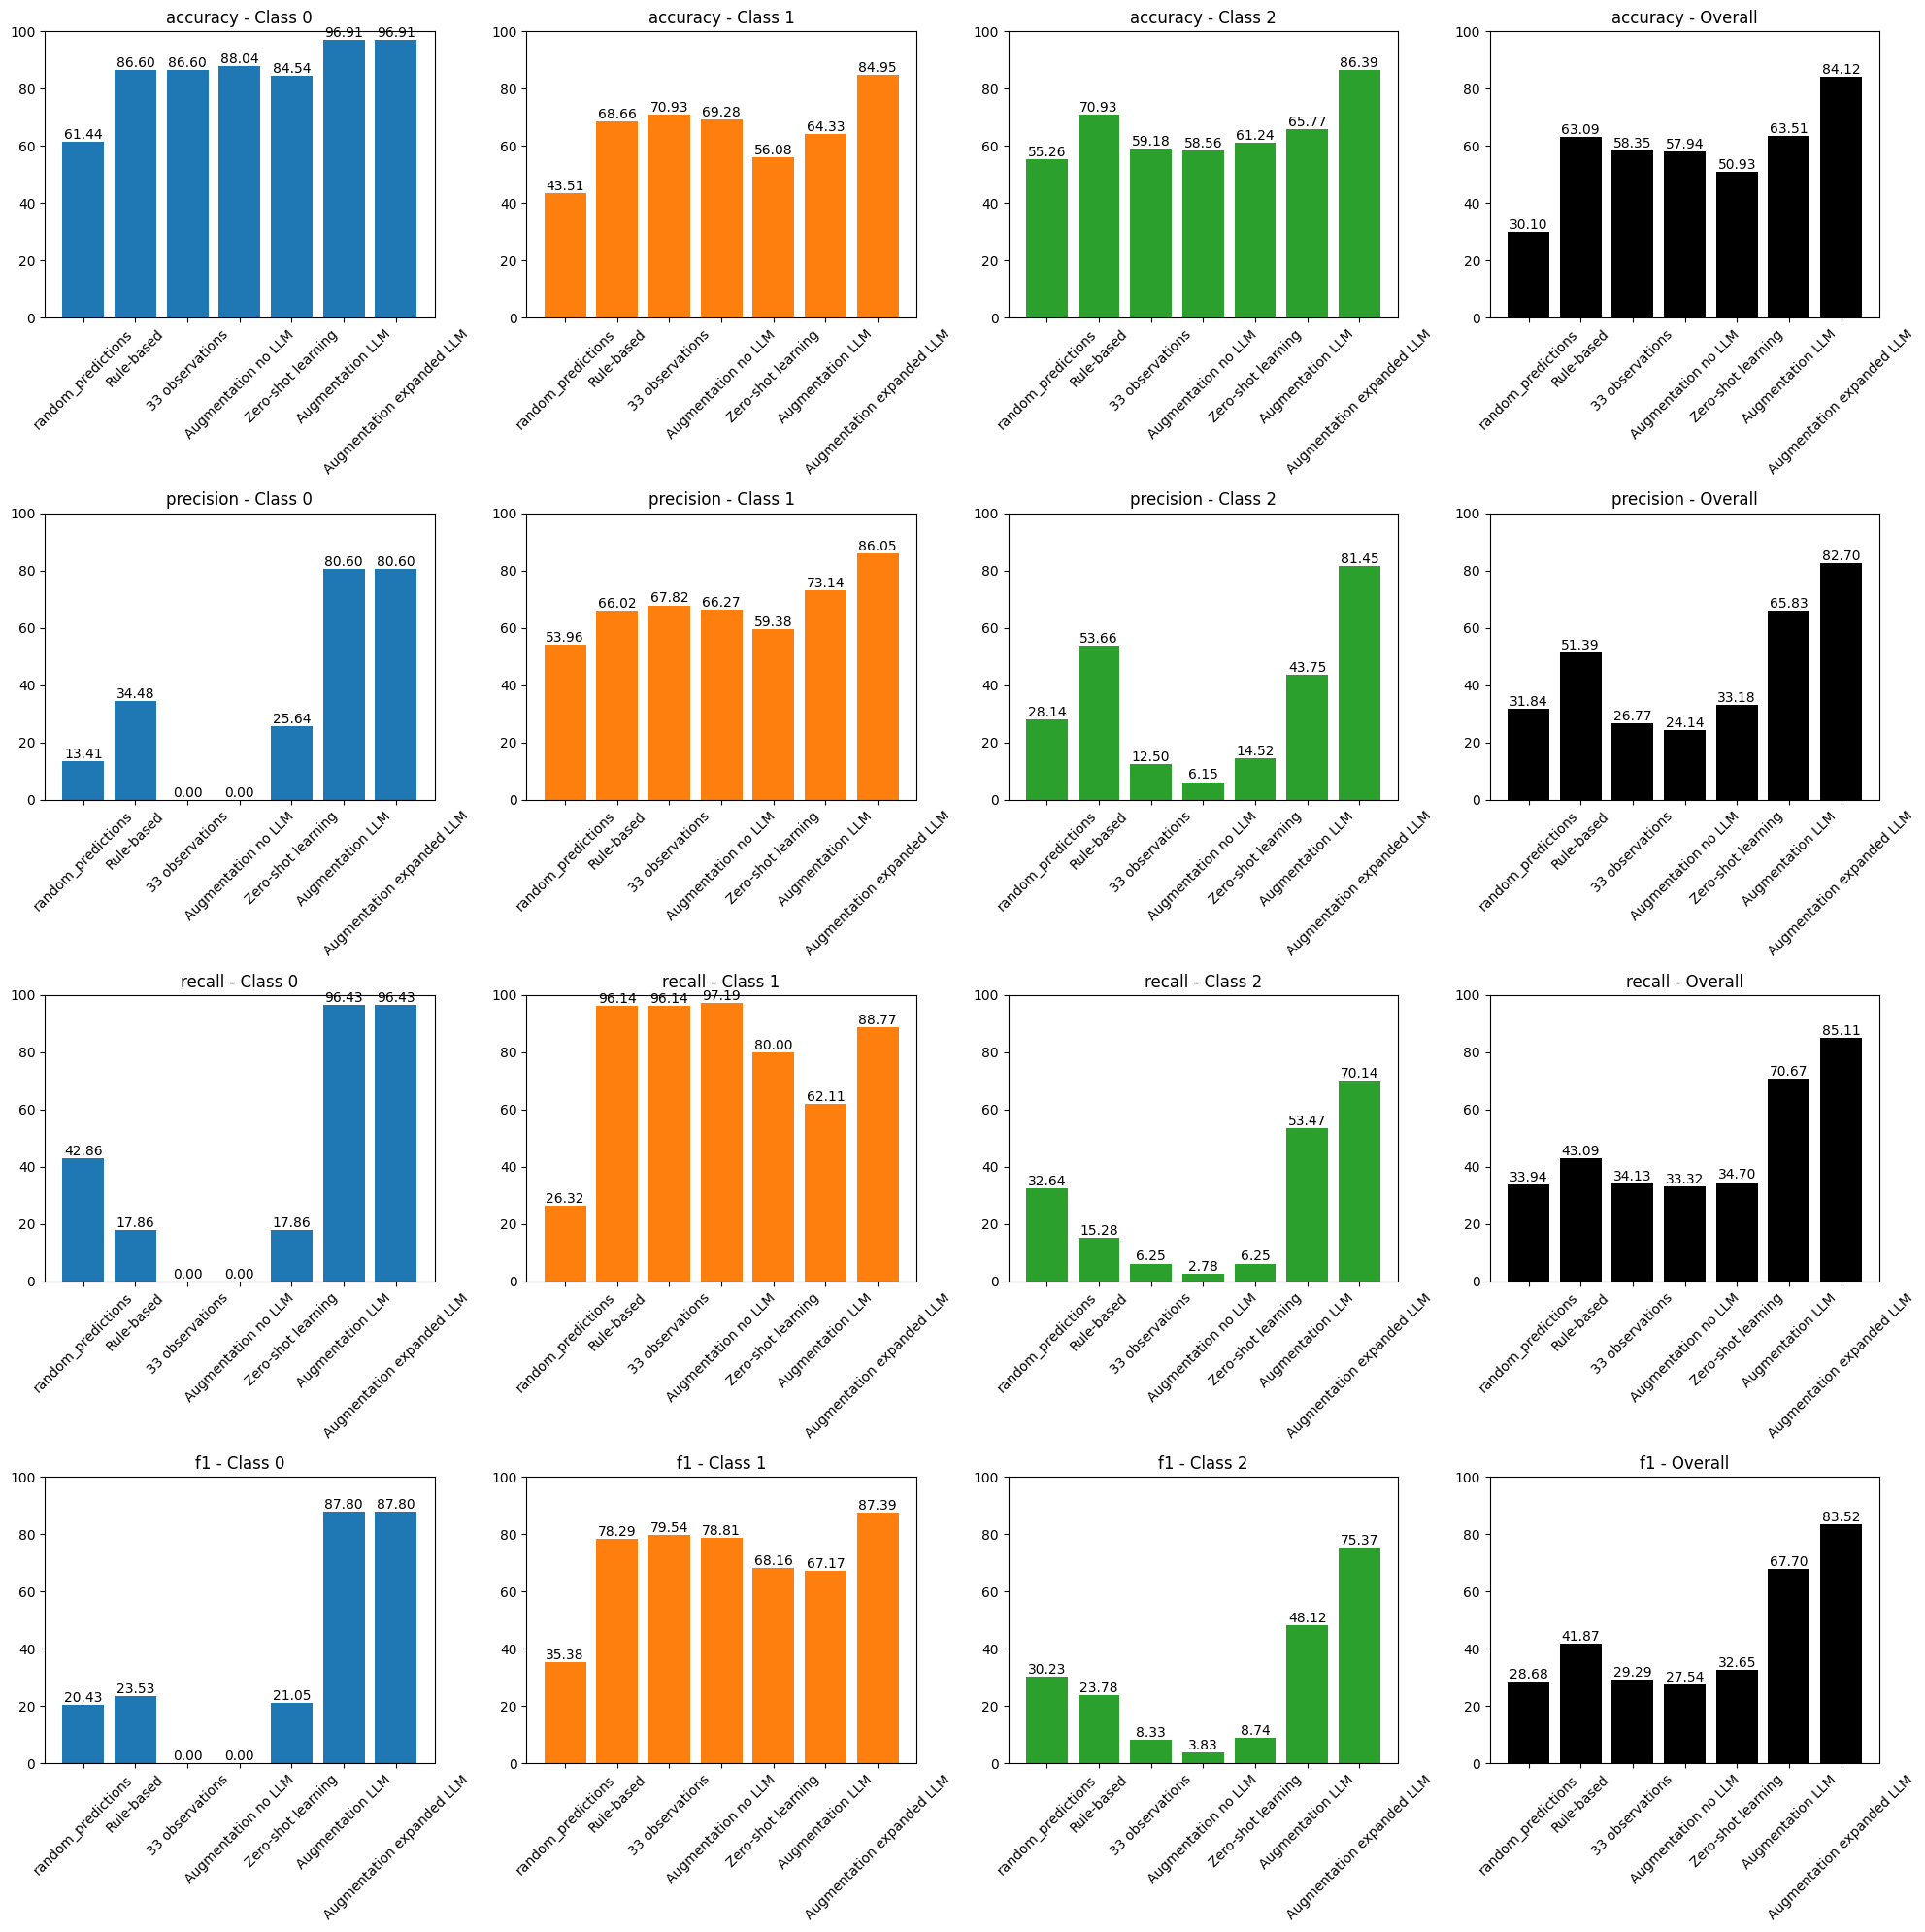

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds = bert_model_4.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

# get the final metrics
metrics_test.run(test_labels, test_preds, "Augmentation expanded LLM")
metrics_test.plot()

As expected, with more examples as input (60 instead of just 33) and also more observations (600 instead of 300), we see our model improves metrics significantly comparing with all other techniques demonstrated but still not reaching its full potential comparing with the later full data implementation.

## Part 3: State of the Art Comparison
*We train our FinBERT model on different sizes of training data: 1%, 10%, 25%, 50%, 75% and 100% and report the metrics and learning curve. Then, we additionally use our LLM augmented data to finetune the model further.*

### a. Full Dataset Training

We will now train the model using different levels of the training data. We will increase the level of training data incrementally through the following levels: 1%, 10%, 25%, 50%, 75%, and 100%. Note that when using 1% of the data we use a smaller batch size, then once the numebr of observations surpasses 64, we keep the batch size of 64 constant for all the models.

In [ ]:
# Below define all steps which are consistent across all models
# Load tokenizer and BERT model
enc = OneHotEncoder(handle_unknown='ignore')
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = TFAutoModel.from_pretrained("ProsusAI/finbert")

batch_size=64
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(valid_labels))

# Function to define model so the models can we ran in a loop

def create_model():

  tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
  model = TFAutoModel.from_pretrained("ProsusAI/finbert")

  for layer in model.layers:
      layer.trainable = False

  ## Input
  input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

  # Embedding layers
  embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)

  final_embedding_layer = embedding_layer[0]#last layer of BERT

  # Extract only the [CLS] token's embeddings
  cls_token_embeddings = final_embedding_layer[:, 0, :]

  # Let's add some dropout to reduce overfitting
  output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

  # One dense layer to process the last layer
  output = tf.keras.layers.Dense(num_labels,
                                kernel_initializer="glorot_uniform",
                                activation='softmax')(output_layer)

  return tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs=output)



All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Subset the data to the different sizes and store in dictionary
percent = [1, 10, 25, 50, 75]
total = len(train_labels)
val_list = []

# Calculate the number of observations needed for each percentage
for p in percent:
    val = total * (p / 100)
    val_list.append(int(val))

# Initialize an empty dictionary to store subsets of data
samples_dict = {}

# Initialize a set to keep track of sampled indices
sampled_indices = set()

# Iterate over each desired number of observations
for val in val_list:
    # Calculate the additional number of observations needed to reach the desired amount
    additional_samples = val - len(sampled_indices)

    # Add random indices to list without replacement
    indices = random.sample(set(train_df.index) - sampled_indices, additional_samples)

    # Add sampled indices to the set
    sampled_indices.update(indices)

    # Concatenate the additional samples with the existing subset
    samples_dict[f"samples_{val}"] = train_df.loc[sampled_indices].copy()

<ipython-input-31-2443d5fe619e>:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  indices = random.sample(set(train_df.index) - sampled_indices, additional_samples)
<ipython-input-31-2443d5fe619e>:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  samples_dict[f"samples_{val}"] = train_df.loc[sampled_indices].copy()
<ipython-input-31-2443d5fe619e>:23: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  indices = random.sample(set(train_df.index) - sampled_indices, additional_samples)
<ipython-input-31-2443d5fe619e>:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  samples_dict[f"samples_{val}"] = train_df.loc[sampled_indices].copy()
<ipython-input-31-2443d5fe619e>:23: DeprecationWarning: Sampling from a set deprecated
sin

In [ ]:
samples_dict.keys()

dict_keys(['samples_38', 'samples_387', 'samples_969', 'samples_1938', 'samples_2907'])

In [ ]:
# Add full data as final dataframe in samples_dict
samples_dict['samples_3876'] = train_df

In [ ]:
# Initialize different models, and fit them to the different training samples

enc = OneHotEncoder(handle_unknown='ignore')

bert_models = {}

for name, df in samples_dict.items():

    # Adjust batch size down for smaller sample
    if name == 'samples_38':
        batch_size = 32
    else:
        batch_size = 64

    model = create_model()

    X_train = np.array(df['text'])

    y_train = enc.fit_transform(np.array(df['label']).reshape(-1, 1)).toarray()

    steps_per_epoch = int(len(X_train) / batch_size)

    batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

    model.compile(optimizer=Adam(2e-5),
                    metrics=[tf.keras.metrics.Recall(),
                    tf.keras.metrics.Precision()],
                    loss=tf.keras.losses.CategoricalCrossentropy())


    # increase number of epochs to 5 as used in the paper
    model.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

    bert_models[name] = model

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 1.2439 - recall_8: 0.4062 - precision_8: 0.4643
Epoch 2/5
1/1 [==============================] - 0s 54ms/step - loss: 1.7056 - recall_8: 0.3333 - precision_8: 0.4000
Epoch 3/5
1/1 [==============================] - 0s 154ms/step - loss: 1.1558 - recall_8: 0.3125 - precision_8: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 48ms/step - loss: 1.5779 - recall_8: 0.3333 - precision_8: 0.4000
Epoch 5/5
1/1 [==============================] - 0s 147ms/step - loss: 0.8342 - recall_8: 0.5625 - precision_8: 0.6923


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
6/6 [==============================] - 15s 286ms/step - loss: 1.3963 - recall_9: 0.2682 - precision_9: 0.3679
Epoch 2/5
6/6 [==============================] - 2s 293ms/step - loss: 1.2744 - recall_9: 0.3529 - precision_9: 0.4653
Epoch 3/5
6/6 [==============================] - 2s 244ms/step - loss: 1.3752 - recall_9: 0.2941 - precision_9: 0.3862
Epoch 4/5
6/6 [==============================] - 1s 238ms/step - loss: 1.3057 - recall_9: 0.3096 - precision_9: 0.3876
Epoch 5/5
6/6 [==============================] - 1s 239ms/step - loss: 1.3325 - recall_9: 0.2632 - precision_9: 0.3648


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
15/15 [==============================] - 17s 288ms/step - loss: 1.9994 - recall_10: 0.1010 - precision_10: 0.1318
Epoch 2/5
15/15 [==============================] - 4s 285ms/step - loss: 1.9489 - recall_10: 0.1171 - precision_10: 0.1538
Epoch 3/5
15/15 [==============================] - 4s 273ms/step - loss: 1.8467 - recall_10: 0.1304 - precision_10: 0.1772
Epoch 4/5
15/15 [==============================] - 4s 278ms/step - loss: 1.7457 - recall_10: 0.1414 - precision_10: 0.1905
Epoch 5/5
15/15 [==============================] - 4s 275ms/step - loss: 1.7193 - recall_10: 0.1558 - precision_10: 0.2092


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
30/30 [==============================] - 21s 280ms/step - loss: 0.7771 - recall_11: 0.6203 - precision_11: 0.7115
Epoch 2/5
30/30 [==============================] - 8s 286ms/step - loss: 0.7353 - recall_11: 0.6537 - precision_11: 0.7384
Epoch 3/5
30/30 [==============================] - 9s 287ms/step - loss: 0.6536 - recall_11: 0.6825 - precision_11: 0.7659
Epoch 4/5
30/30 [==============================] - 9s 286ms/step - loss: 0.6292 - recall_11: 0.6926 - precision_11: 0.7735
Epoch 5/5
30/30 [==============================] - 8s 280ms/step - loss: 0.6042 - recall_11: 0.7150 - precision_11: 0.7818


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
45/45 [==============================] - 27s 282ms/step - loss: 1.4843 - recall_12: 0.2083 - precision_12: 0.2817
Epoch 2/5
45/45 [==============================] - 13s 291ms/step - loss: 1.2864 - recall_12: 0.2993 - precision_12: 0.3992
Epoch 3/5
45/45 [==============================] - 13s 290ms/step - loss: 1.1431 - recall_12: 0.3665 - precision_12: 0.4876
Epoch 4/5
45/45 [==============================] - 13s 282ms/step - loss: 0.9873 - recall_12: 0.4390 - precision_12: 0.5756
Epoch 5/5
45/45 [==============================] - 13s 278ms/step - loss: 0.8796 - recall_12: 0.5164 - precision_12: 0.6498


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
60/60 [==============================] - 29s 279ms/step - loss: 1.5601 - recall_13: 0.1958 - precision_13: 0.2551
Epoch 2/5
60/60 [==============================] - 17s 287ms/step - loss: 1.2677 - recall_13: 0.3009 - precision_13: 0.3992
Epoch 3/5
60/60 [==============================] - 17s 289ms/step - loss: 1.0775 - recall_13: 0.4095 - precision_13: 0.5348
Epoch 4/5
60/60 [==============================] - 17s 282ms/step - loss: 0.9073 - recall_13: 0.5000 - precision_13: 0.6422
Epoch 5/5
60/60 [==============================] - 17s 279ms/step - loss: 0.7917 - recall_13: 0.5716 - precision_13: 0.7093


We now have a dictionary with different FinBERT models, all trained on incrementally increasing levels of the train data.

In [ ]:
bert_models

{'samples_38': <keras.src.engine.functional.Functional at 0x7ebf981e3a00>,
 'samples_387': <keras.src.engine.functional.Functional at 0x7ebf932ad0c0>,
 'samples_969': <keras.src.engine.functional.Functional at 0x7ebf9440bfd0>,
 'samples_1938': <keras.src.engine.functional.Functional at 0x7ebe83b56a40>,
 'samples_2907': <keras.src.engine.functional.Functional at 0x7ebe840d7220>,
 'samples_3876': <keras.src.engine.functional.Functional at 0x7ebf959b12a0>}

In [ ]:
# Save weights of all models
#Mount google drive to export model weights
#from google.colab import drive
#drive.mount('/content/drive')

#bert_models['samples_38'].save_weights('/content/drive/My Drive/bert_model_38.h5')
#bert_models['samples_387'].save_weights('/content/drive/My Drive/bert_model_387.h5')
#bert_models['samples_969'].save_weights('/content/drive/My Drive/bert_model_969.h5')
#bert_models['samples_1938'].save_weights('/content/drive/My Drive/bert_model_1938.h5')
#bert_models['samples_2907'].save_weights('/content/drive/My Drive/bert_model_2907.h5')
#bert_models['samples_3876'].save_weights('/content/drive/My Drive/bert_model_3876.h5')

Mounted at /content/drive


Below we use all the different BERT models to make predictions on the test data, and report the classification metrics for each model.

16/16 [==============================] - 2s 133ms/step


<ipython-input-6-49b04a7e197e>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
<ipython-input-6-49b04a7e197e>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


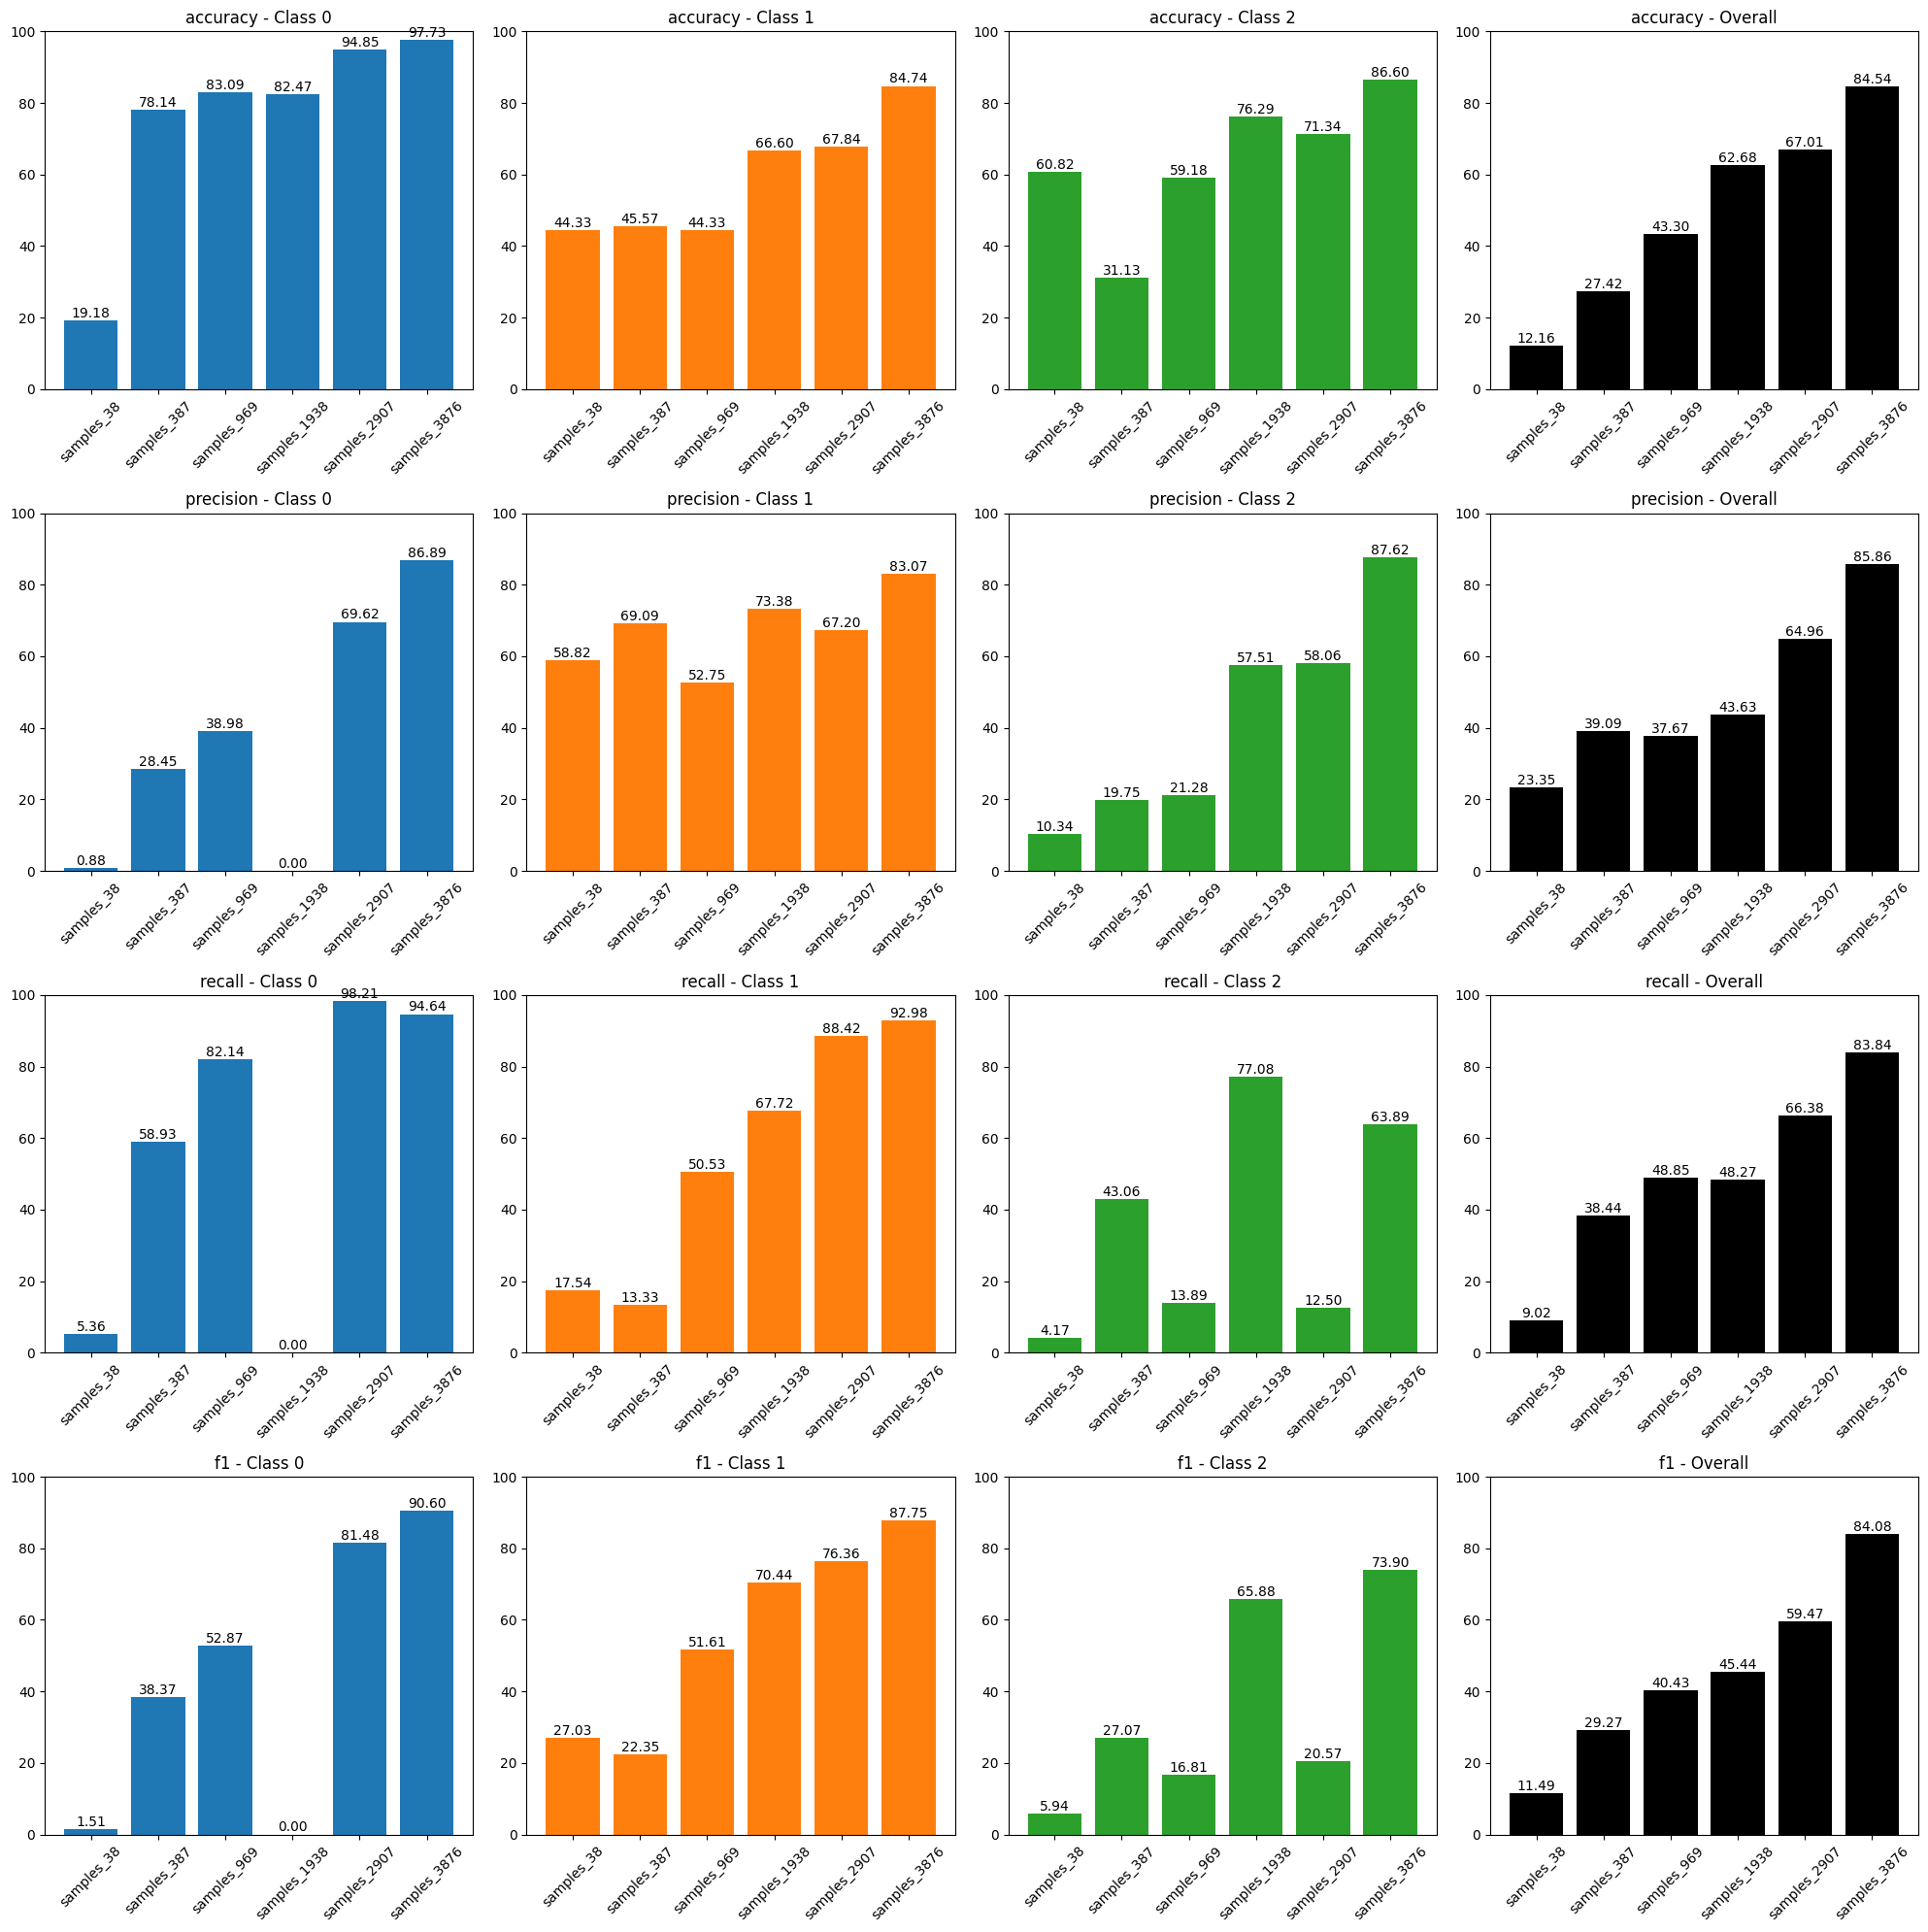

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
              np.asarray(inputs['attention_mask'], dtype='int32')]

# Make predictions and add to metrics class for each model
metrics_all = Metrics()
preds_dict = {}

for name, model in bert_models.items():
  test_preds = model.predict(inputs_test)
  test_preds = np.argmax(test_preds, axis=1)

  # Add predictions to dictionary
  preds_dict[name] = test_preds

  # get the final metrics
  metrics_all.run(test_labels, test_preds, name)

metrics_all.plot()


Focusing on the overall F1, we can see that as we increase the amount of training data avaliable we continually get more accurate predictions from our model. This is because as we add more training data, the model can learn a broader range of patterns and relationships present in the data, allowing the model to generalize better to unseen data, leading to more accurate predictions. Also, since BERT models are deep learning models with a large number of parameters, increasing the training data allows the model to explore a richer feature space, potentially capturing more nuanced relationships between words and contexts. This can lead to better semantic understanding and more accurate predictions. We should note there is some inconsistency in the other classification metrics when focusing on classes individually. For example, in the case where the model was trained with 1,938 observations, we find an F1, recall and precision of 0 for the negative class. This means this model never predicts a negative class, which is concerning. This may be cause by this dataset being heavily imbalanced, not allowing the model to learn the features of the negative class.

### b. Learning Curve

We now plot how the learning curve, which shows how the overall F1 score changed as we add more data in the training process.

In [ ]:
# Store macro averaged F1 scores in a list
f1_list = []
for name, preds in preds_dict.items():
  score = f1_score(test_labels, preds, average='macro')
  f1_list.append(score)

percentage_list = [1, 10, 25, 50, 75, 100]

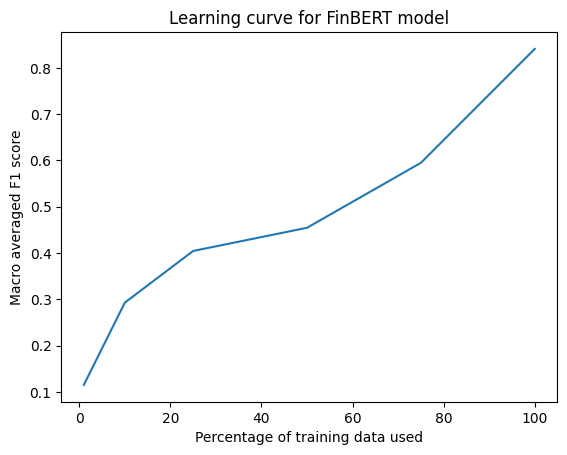

In [ ]:
# Plot F1 scores
plt.plot(percentage_list, f1_list)

# Adding labels and title
plt.xlabel('Percentage of training data used')
plt.ylabel('Macro averaged F1 score')
plt.title("Learning curve for FinBERT model")

# Displaying the plot
plt.show()

The learning curve confirms the conclusions drawn above, as the percentage of training data used increases, the performance of the model also improves.

### c. Technique Comparison

In part 2, the main technique which improved the performance of the model was the use of LLMs to augment new data. Here we incorporate this practice into the full model, by taking the augmented data and integrating it into the full dataset to train a new model. (Note that at this stage we tried to augment more data, but we had some trouble with rate limits on OpenAI's API).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load in augmented data
aug_df = pd.read_csv("/content/drive/My Drive/all_observations_optimized_clean.csv")


# Add augemnted data to train data
df_combined = pd.concat([train_df, aug_df], ignore_index=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train Finbert model on the combination of the train data and the augmented data from OpenAI

In [ ]:
final_model = create_model()

X_train = np.array(df_combined['text'])

y_train = enc.fit_transform(np.array(df_combined['label']).reshape(-1, 1)).toarray()

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

final_model.compile(optimizer=Adam(2e-5),
                metrics=[tf.keras.metrics.Recall(),
                tf.keras.metrics.Precision()],
                loss=tf.keras.losses.CategoricalCrossentropy())


# increase number of epochs to 5 as used in the paper
final_model.fit(batches, epochs=5, steps_per_epoch=steps_per_epoch)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
70/70 [==============================] - 33s 286ms/step - loss: 1.0577 - recall_1: 0.4353 - precision_1: 0.5540
Epoch 2/5
70/70 [==============================] - 20s 293ms/step - loss: 0.8889 - recall_1: 0.5319 - precision_1: 0.6436
Epoch 3/5
70/70 [==============================] - 20s 280ms/step - loss: 0.7520 - recall_1: 0.6169 - precision_1: 0.7210
Epoch 4/5
70/70 [==============================] - 19s 276ms/step - loss: 0.6692 - recall_1: 0.6858 - precision_1: 0.7688
Epoch 5/5
70/70 [==============================] - 19s 278ms/step - loss: 0.6231 - recall_1: 0.7135 - precision_1: 0.7775


Make predictions and plot metrics for the model trained on combined data.

16/16 [==============================] - 6s 134ms/step


<ipython-input-6-49b04a7e197e>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
<ipython-input-6-49b04a7e197e>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


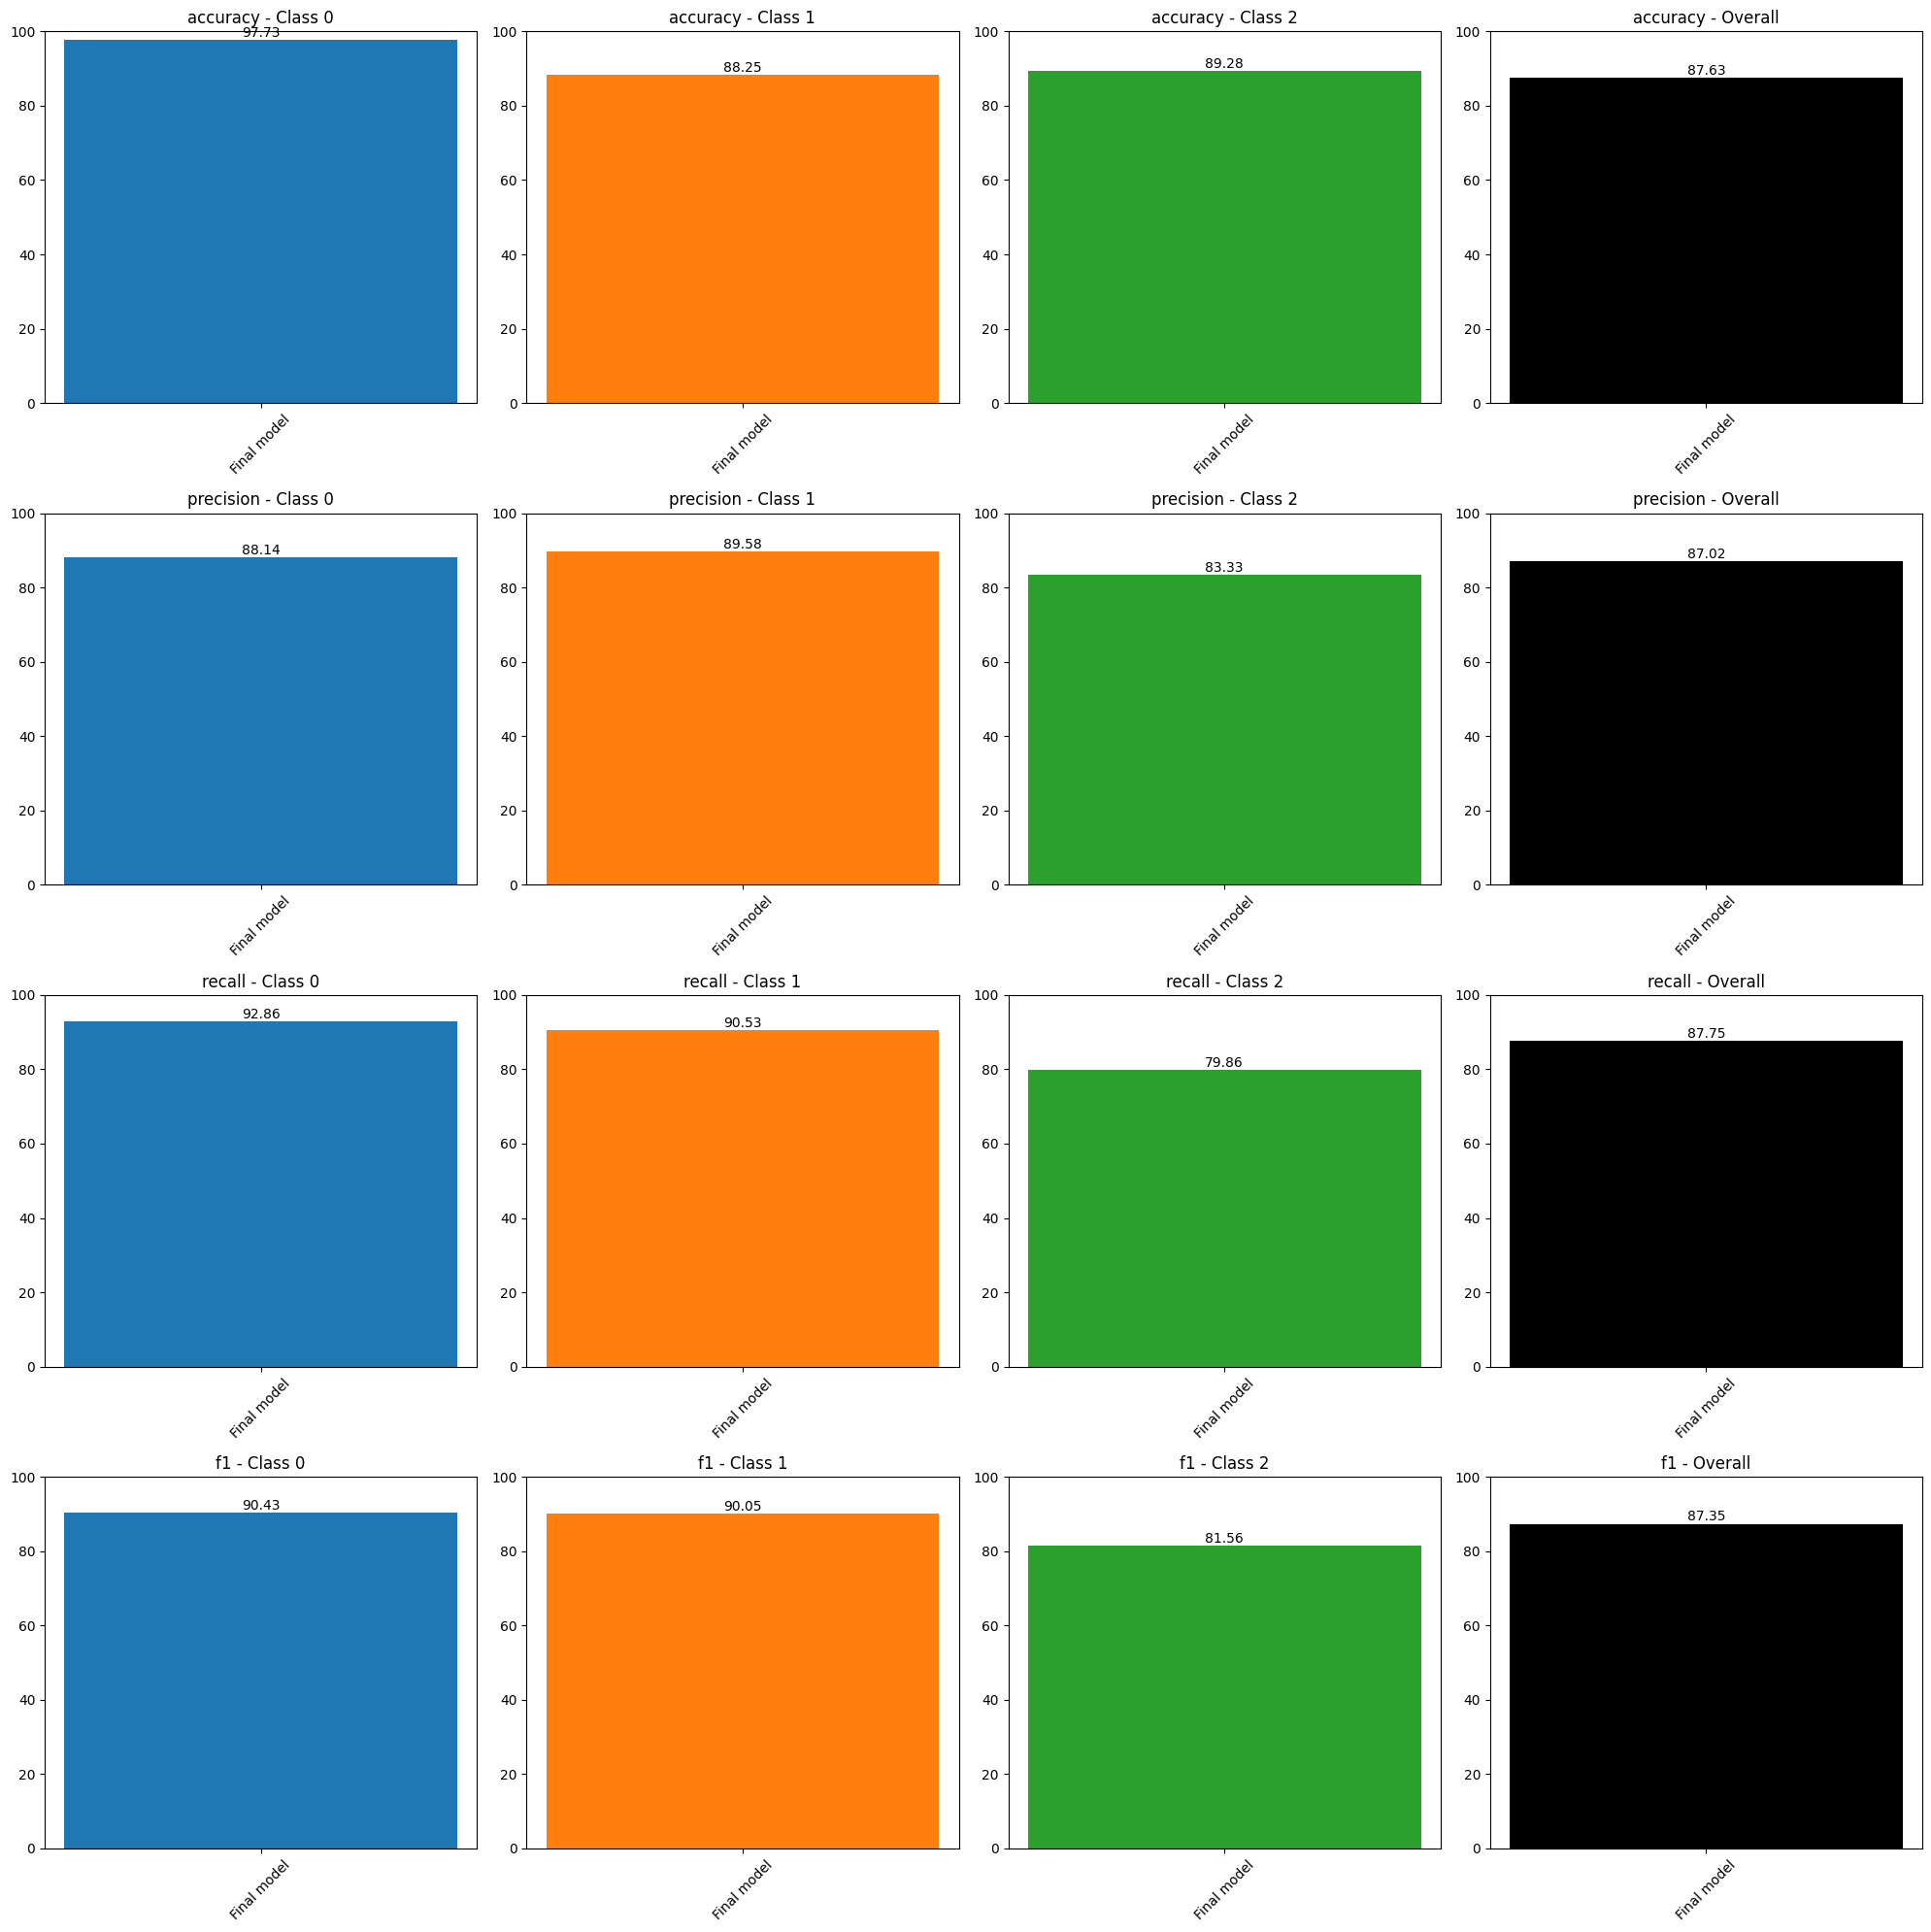

In [ ]:
# Get the inputs tokenized from the test set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                    add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
              np.asarray(inputs['attention_mask'], dtype='int32')]


final_metrics = Metrics()

test_preds = final_model.predict(inputs_test)
test_preds = np.argmax(test_preds, axis=1)

final_metrics.run(test_labels, test_preds, "Final model")

final_metrics.plot()

We can see that adding the augmented data has led to an imporvement in the overall performance of the model. We achieve the highest overall F1 score of all the models tested of 87.35. This actually surpasses the score of 85 which is reported when the paper was originally published.

In [ ]:
# Save model weights
final_model.save_weights('/content/drive/My Drive/final_model_weights.h5')

In [ ]:
# Save dataframe used to train best model
df_combined.to_csv('/content/drive/My Drive/combined_data.csv', index=False)

### d. Methodology Analysis

We have tested multiple different methodologies with differing degrees of success at predicting the sentiment of financial statements. We started with a random classifier which acts as a benchmark. Naturally, the random classifier does not perform well, achieveing an overall F1 score of 28.68. The first classification technique we tried was based on rule based matching, where positive and negative words were matched within statements to classify them, which marked a significant improvement on the random predictions, with an overall F1 score of 41.87, however this is still a generally poor performance. We would not expect this type of simple approach to work well with a complex classification task, as rule based matching misses the context and semantic meanings of words. We need to use more complex models to be able to properly capture the sentiment within text.

Our first attempt at using one of these more complex models was the state of the art FinBERT. BERT models have a deep understanding of contextual relationships within language, so we expect these models to perform better. We initially trained FinBERT with only 33 observations (11 of each class), which led to very poor performance overall, similar to that of the random classifier. This model was particulary bad at identifying the negative class, with a precision and recall of 0 (i.e. it never predicted this class). Here, this cannot be attributed to class imbalance as we have 11 of each labels, but perhaps the negative sentiment is more subtle in financial statements, so with such little training data the model was unable to correctly understand the patterns within negative financial statements. To attempt to improve on this model, we "labelled" more data with the predicitons of FinBERT trained on the 33 observations, allowing us to re-train the FinBERT model with more training data. This led to the worse performing model we tried; precision and recall were still zero for the negative class, and the overall F1 was lower than that of the random classifier. This is because the model is training on it's own biases - we cannot expect improvement in results without any extra "real" ground truths.

Next we tried a zero-shot learning approach. This is where a model is trained to recognize classes it has never seen during training. Instead of learning from labeled examples of each class, zero-shot learning relies on auxiliary information or semantic embeddings to generalize to unseen classes. This approach also struggled, with an overall F1 lower than the rule-based approach of 32.65. Here we do find we are getting some predictions of the negative class, something we were not getting with the FinBERT models tried thus far. Overall the models performance is still poor. This is likey due to the auxiliary information the model was trained on being too different to the financial statements we are making predictions about. For zero-shot learning to work well we need the training data to be as close as possible to the data we are then making predictions on.

To attempt to improve the models we had tried so far, we augmented data using Chat GPT. Here we generated 300 new observations using the 33 observations used to train the FinBERT model, which we then used to re-train the FinBERT model. This led to significant improvements, achieving an overall F1 of 67.70. The increased training data also meant the model was successfully predicting negative classes, achieving an F1 of 87.80 for the negative class. This model performed the worse when predicting the positive class, with an F1 of 48.12. To attempt to further improve the performance of this model we augmented even more data from ChatGPT, this time using 60 examples and generating 600 observations. This led to a further improvement in overall F1 to 83.52, and a significant improvement in how the model predicted the positive class, achieveing an F1 of 75.37.

This model with the augmented data from ChatGPT actually performed very similarily to the FinBERT model trained on 100% of the training data. Using 100% of the training data we managed to achieve a slightly higher overall F1 of 84.08, but a lot of the metrics for the individual classes were similar across the modle trained on the full data, and tht trained on the augmented data.

To try to leverage the power of both the training data and the augemnted data, we combined both datasets to train our final and best performing model. Here we achieved an overall F1 score of 87.35, which actually surpasses the score of 85 which was reported in the paper where the FinBERT model was published. We also get very high scores on all other metrics, with the only one below 80 being the recall for the positive class at 79.86. We can consider this final model as our best performing based on the classification metrics, and this is the model we will try to distill in the following section.

## Part 4: Model Distillation
*In this part, we distill our best-performing model into a lighter model by using a double loss function. Like that, our model is much faster, while still containing high predictive power.*

### a. Model Distillation

In the following we distill our best performing model; the FinBERT model with an additional dense layer trained on the training data plus 600 augmented data points.

**Ruducing the Model Size**

The goal of the destillation is to teach a model with fewer parameters to imitate the behavious of the bigger teacher model. While the teacher model is suited to learn complex relationships, its larger size leads to slower inference speed. The student learns to imitate the teacher by using the class probabilities the teacher produces, which captures how the teacher model learns to generalize (Hinton et al., 2015). By training the student with these porbabilities and the true labels, the student benefits from the teachers knowledge on how to generalize.

We choose to distill the FinBERT model using a similar approach to Sanh et al. (2019), who created DistillBERT by distilling BERT. DistilBERT alternates between one copied and one ignored layer, which seems to be the a good heuristic, reducing the number of parameters from 109 million to 66 million. Following this, we configurate the student model by halving the number of hidden layers (num_hidden_layers) and attention heads (num_attention_heads) of the teacher model.

**Triple Loss**

As mentioned above, the student model is trained with the class probabilities from the teacher model and the true labels. This leads to multiple loss functions that can be weighted and aggregated to a combined loss function. We first used the "triple loss function" Sanh et al. (2019) propose. The first loss is using the true labels in a Cross-Entropy loss function similar to the teacher model ($L_{problem}$). The class probabilities are then split up into two losses: Cross-entropy for the soft labels and Cosine similarity loss. The first loss aims to reduce the gap between student and teacher probability distributions and the second is used so that the hidden vectors in teacher and student models align. As far as we understand it the cosine similarity loss is used since we do not only care about how far apart the teacher and student probabilities are but rather that they point in the same direction, i.e. the absolute size of the class probabilities does not matter as long as the relative sizes are preserved. The three losses are then weighted equally in the combined loss:

\begin{equation}
L_{\text {distillation }}=\frac{L_{\text {problem }}+L_{\text {cross }}+L_{\text {cosine }}}{3}
\end{equation}



However, when using the triple loss the class with the lowest number of datapoints, the negative class (aorund 12%) is not predicted at all, resulting in a f1 score of 40. We tried incorporating class weights and using different values for the temperature, learning rate and batch size but were not able to improve it. Another issue was that the logits for all observations were almost identical:

[[ 0.8175926   1.9499062  -6.3668904 ]
 [ 0.8175926   1.9499062  -6.3668904 ]
 [ 0.81759256  1.9499065  -6.3668904 ]
 ...
 [ 0.8175927   1.9499056  -6.366891  ]
 [ 0.81759256  1.9499054  -6.366891  ]
 [ 0.81759256  1.9499054  -6.366891  ]]


**Double Loss**

We then proceeded using a double loss function based on Hinton et al. (2015). The first loss function is again cross entropy with the correct labels. The second loss function is the Kullback-Leibler Divergence loss $L_{KL}$ with the soft targets, again a measure to compare the similarity of the class probability distributions. The parameter alpha weights the two losses. The second loss is further multiplied by the squared temperature which ensures that the relative losses between the two remain unchanged when using different values for the temperature.

\begin{equation}
L_{\text {distillation }}= (1 - \alpha) \ L_{\text {problem }}+ \alpha \ T^{2} \ L_{\text {KL}}
\end{equation}

**Hyperparameter Tuning**

We first also had the issue that the negative class was not predicted at all, and then tuned the model. Similar to Hinton et al. (2015) we find that a lower weight on the first loss function i.e. an alpha of 0.7 works best. We find that with a lower alpha the simpler student model is not able to learn the negative class. Increasing alpha puts higher weights on the class probabilities of the teacher model which has learned the negative class.

Another important hyperparameter is the temperature. The temperature parameter in the softmax function controls the smoothness of the output probability distribution, i.e. the class probabilites. A higher temperature makes the distribution softer (i.e., differences between the largest and other logits are diminished), which can help the student model learn from the full structure of the teacher's predictions, not just the most likely class. We found that a value of 10 helped our student model to overcome our previous problem and learn the negative class as well, which led to the best result.

#### Inspect the teacher model

In [12]:
finBERT = AutoModelForMaskedLM.from_pretrained("ProsusAI/finbert")

Some weights of BertForMaskedLM were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print(finBERT)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [14]:
def visualize_children(
    object : Any,
    level : int = 0,
) -> None:
    """
    Prints the children of (object) and their children too, if there are any.
    Uses the current depth (level) to print things in a ordonnate manner.
    """
    print(f"{'   ' * level}{level}- {type(object).__name__}")
    try:
        for child in object.children():
            visualize_children(child, level + 1)
    except:
        pass

visualize_children(finBERT)

0- BertForMaskedLM
   1- BertModel
      2- BertEmbeddings
         3- Embedding
         3- Embedding
         3- Embedding
         3- LayerNorm
         3- Dropout
      2- BertEncoder
         3- ModuleList
            4- BertLayer
               5- BertAttention
                  6- BertSelfAttention
                     7- Linear
                     7- Linear
                     7- Linear
                     7- Dropout
                  6- BertSelfOutput
                     7- Linear
                     7- LayerNorm
                     7- Dropout
               5- BertIntermediate
                  6- Linear
                  6- GELUActivation
               5- BertOutput
                  6- Linear
                  6- LayerNorm
                  6- Dropout
            4- BertLayer
               5- BertAttention
                  6- BertSelfAttention
                     7- Linear
                     7- Linear
                     7- Linear
                     7- Dropou

#### Reducing the model size

In [15]:
 def distill_bert(teacher_hf_model, num_labels):
    """
    Create a distilled student model architecture from the pre-trained BERT teacher model.

    Parameters:
    - teacher_hf_model: The Hugging Face model object from which the teacher Keras model was built.
    - num_labels: The number of labels in the output layer (classification head).

    Returns:
    - A new student model with fewer transformer layers than the teacher.
    """
    # Get the configuration from the teacher Hugging Face model
    teacher_config = teacher_hf_model.config
    student_config = AutoConfig.from_pretrained(
            teacher_config._name_or_path,
            num_hidden_layers=max(1, teacher_config.num_hidden_layers // 2),
            num_attention_heads=max(1, teacher_config.num_attention_heads // 2),
            num_labels=num_labels  # This is crucial for multi-class
        )

    # Ensure the student model has a softmax output for multi-class classification
    student_model = TFAutoModelForSequenceClassification.from_config(student_config)

    return student_model

# Assuming the `num_labels` is correctly set to the number of your classes
student_model = distill_bert(model, num_labels)

#### Comparison to the teacher model

In [16]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_token[0][0]',         
 el)                         ngAndCrossAttentions(last_   40         'masked_token[0][0]']        
                             hidden_state=(None, 64, 76                                           
                             8),                                                              

In [17]:
student_model.build()
student_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  66955008  
                                                                 
 dropout_130 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 66957315 (255.42 MB)
Trainable params: 66957315 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
def distill_bert_weights(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights from the teacher to the student.
    This function is meant to be first called on a BertFor... model, but is then called on every child of that model recursively.
    The encoder is the only part that's not fully copied; only half is copied.
    """
    # If the part is an entire BERT model or a BertFor..., unpack and iterate
    if isinstance(teacher, AutoModelForMaskedLM):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every two layers
    elif hasattr(teacher, 'encoder'):
        teacher_encoding_layers = list(teacher.encoder.layer)
        student_encoding_layers = list(student.encoder.layer)
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
    # Else if the part is a head or something else, directly copy the state_dict
    else:
        try:
            student.load_state_dict(teacher.state_dict())
        except:
            # In case of mismatch, this part is not copied directly (e.g., size mismatches)
            pass



#### Loss functions

##### Obtain Logits

In [19]:
import tensorflow as tf

def get_logits(model, input_ids, attention_mask):
    """
    Given a custom FinBERT-based Keras model (model) for classification and the inputs (input_ids) and (attention_mask),
    returns the logits corresponding to the prediction.
    """
    # We assume that `model` is your final Keras model (bert_model_3) which already includes the output layer
    # This function passes the inputs through the model and extracts the logits (the output of the model just before the softmax layer).
    outputs = model([input_ids, attention_mask])
    return outputs  # If your output layer is a softmax, this will give you the probabilities.

##### Double loss
Loss function with Categorical Cross-Entropy loss and Kullback-Leibler Divergence (KD) loss

In [20]:
def distillation_loss(teacher_logits, student_logits, labels, temperature=10.0, alpha=0.7):
    """
    Updated distillation loss function for multi-class classification that combines
    categorical cross-entropy for the true labels and KD loss for the teacher-student logits,
    using specified temperature and alpha for weighting the importance of each loss component.

    Parameters:
        teacher_logits: Logits from the teacher model.
        student_logits: Logits from the student model.
        labels: True labels (one-hot encoded for multi-class).
        temperature: The temperature for scaling logits (default: 1.0).
        alpha: Weight for balancing the classification and distillation loss (default: 0.5).
    """
    # Apply temperature scaling on logits
    teacher_logits_scaled = teacher_logits / temperature
    student_logits_scaled = student_logits / temperature

    # Compute the soft labels from teacher logits
    teacher_soft_labels = tf.nn.softmax(teacher_logits_scaled)

    # Categorical Cross-Entropy (CCE) Loss for the true labels
    cce_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    classification_loss = cce_loss_fn(labels, student_logits)

    # Kullback-Leibler Divergence (KD) Loss for distillation
    kd_loss_fn = tf.keras.losses.KLDivergence()
    distillation_loss = kd_loss_fn(teacher_soft_labels, tf.nn.softmax(student_logits_scaled))

    # Combine the losses with alpha weighting
    total_loss = alpha * classification_loss + (1 - alpha) * distillation_loss
    # total_loss = alpha * classification_loss + (1 - alpha) * (temperature ** 2) * distillation_loss


    return total_loss

##### Triple loss without class weights
Categorical Cross-Entropy, Cross-entropy for the soft labels and Cosine similarity loss

In [1]:
# def distillation_loss(teacher_logits, student_logits, labels, temperature=1.0):
#     """
#     The distillation loss for distilling a BERT-like model in TensorFlow.
#     The loss combines the (teacher_logits), (student_logits), and (labels) for various losses.
#     The (temperature) can be given; otherwise, it's set to 1 by default.
#     """
#     # Temperature-scaled logits and softmax
#     student_logits_scaled = tf.nn.softmax(student_logits / temperature)
#     teacher_logits_scaled = tf.nn.softmax(teacher_logits / temperature)

#     # Categorical cross-entropy loss for the true labels
#     ce_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#     classification_loss = ce_loss_fn(labels, student_logits_scaled)

#     # Cross-entropy for the soft labels (teacher-student distillation)
#     distillation_loss = ce_loss_fn(teacher_logits_scaled, student_logits_scaled)

#     # Cosine similarity loss
#     cosine_loss_fn = tf.keras.losses.CosineSimilarity()
#     cosine_loss = cosine_loss_fn(teacher_logits_scaled, student_logits_scaled)

#     # Combine the losses
#     total_loss = (classification_loss + distillation_loss - cosine_loss) / 3
#     return total_loss

##### Triple loss with class weights

In [ ]:
# def distillation_loss_with_class_weights(teacher_logits, student_logits, labels, class_weights, temperature=5.0):
#     """
#     The distillation loss for distilling a BERT-like model in TensorFlow with class weighting.
#     This function combines the teacher_logits, student_logits, and labels for various losses
#     and applies class weights to the classification loss to handle class imbalance.

    # Parameters:
    # - teacher_logits: Logits from the teacher model.
    # - student_logits: Logits from the student model.
#     - labels: True labels.
#     - class_weights: Class weights to handle class imbalance.
#     - temperature: Temperature for softening logits.
#     """
#     # Temperature-scaled logits and softmax
#     student_logits_scaled = tf.nn.softmax(student_logits / temperature)
#     teacher_logits_scaled = tf.nn.softmax(teacher_logits / temperature)

#     # Map class weights to each sample in the batch
#     sample_weights = tf.reduce_sum(class_weights * labels, axis=-1)

#     # Categorical cross-entropy loss for the true labels with class weights
#     ce_loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#     classification_loss = ce_loss_fn(labels, student_logits_scaled, sample_weight=sample_weights)

#     # Cross-entropy for the soft labels (teacher-student distillation)
#     distillation_loss = ce_loss_fn(teacher_logits_scaled, student_logits_scaled)

#     # Cosine similarity loss
#     cosine_loss_fn = tf.keras.losses.CosineSimilarity()
#     cosine_loss = cosine_loss_fn(teacher_logits_scaled, student_logits_scaled)

#     # Combine the losses
#     total_loss = (classification_loss + distillation_loss - cosine_loss) / 3
#     return total_loss

#### Train the student model

In [25]:
import tensorflow as tf

print(isinstance(final_model, tf.keras.Model))  # This should print True for a Keras model
print(isinstance(student_model, tf.keras.Model))  # This should print True for a Keras model

# Define the distillation loss
#temperature = 1.0  # Distillation temperature; can be tuned

# Calculate the number of samples per class
samples_per_class = np.sum(y_train, axis=0)

# Calculate the total number of samples
total_samples = np.sum(samples_per_class)

# Calculate class weights (inverse of class frequencies)
class_weights = total_samples / (samples_per_class * len(samples_per_class))
print("class weights: ", class_weights)

# Create the train data generator
train_data_generator = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

# Make sure the optimizer is defined for TensorFlow
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

batch_size=32
# Calculate steps_per_epoch as the total number of samples divided by the batch size
steps_per_epoch = len(X_train) // batch_size
if len(X_train) % batch_size != 0:
    steps_per_epoch += 1  # Add one more step if there are leftovers
print(steps_per_epoch)


# Now when calling the model make sure to use it as a TensorFlow model
for epoch in range(2):
    for step, (batch_inputs, batch_labels) in enumerate(train_data_generator):
        input_ids, attention_mask = batch_inputs  # Unpack the tuple of inputs
        with tf.GradientTape() as tape:
            # Calculate teacher model logits (assuming direct tensor output)
            teacher_logits = final_model([input_ids, attention_mask], training=False)

            # Calculate student model logits (check if direct tensor output or not)
            student_model_output = student_model([input_ids, attention_mask], training=True)
            break
            # If student_model behaves like Hugging Face models and returns an object with .logits, extract them
            if hasattr(student_model_output, 'logits'):
                student_logits = student_model_output.logits
            else:
                # If student_model directly returns logits (like teacher_model seems to do), use them as is
                student_logits = student_model_output

            # Calculate distillation loss
            loss_value = distillation_loss(teacher_logits, student_logits, batch_labels, temperature)

        # Apply gradients
        gradients = tape.gradient(loss_value, student_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, student_model.trainable_variables))

        # Logging
        print(f'Epoch {epoch}, Step {step}, Loss: {loss_value.numpy()}')

        # Make sure to break the loop at the end of the dataset
        if step >= steps_per_epoch:
            break



True
True
class weights:  [2.18071705 0.58952194 1.18322818]
141


In [ ]:
# Saving the weights of the student model
# student_model.save_weights('student_model_weights_19.h5')

In [21]:
# Assuming `student_model` has been defined with the same architecture
student_model.load_weights("student_model_weights_19.h5")

### b. Performance and Speed Comparison

In [22]:
test_preds = student_model.predict(inputs_test)

16/16 [==============================] - 9s 372ms/step


[[ 0.7790353   0.49826342 -1.0537468 ]
 [ 0.18233503  1.1764894  -0.8656922 ]
 [-0.65802747  1.0409801   0.8112734 ]
 ...
 [-0.6615296   1.6635377  -0.05517863]
 [-0.78308463  0.77403486  1.2538027 ]
 [-0.60622054  1.8279588  -0.43020198]]
[0 1 1 2 1 0 2 1 1 1 1 1 1 2 1 1 1 0 2 2 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 0 1 2 1 0 2 2 0 2 2 1 1 1 0 1 1 1 2 1 1 2 1 2 2 2 1 2 1 1 1 1 1 0 1 1
 1 2 2 1 2 1 2 2 1 1 2 0 1 1 1 1 2 1 0 0 1 0 0 1 2 1 1 1 2 1 1 0 0 1 1 1 1
 0 1 2 1 1 1 1 0 2 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 2 1
 1 1 1 2 2 1 2 1 2 1 1 1 2 1 1 2 2 1 1 2 1 1 1 1 2 1 1 1 0 0 1 1 2 1 2 1 2
 1 1 1 0 2 2 1 0 1 1 2 0 0 1 1 2 0 1 1 0 1 1 2 0 1 1 1 1 2 1 1 1 1 1 1 1 2
 1 0 2 2 1 2 0 2 1 1 1 1 1 2 2 1 2 1 1 2 1 1 1 2 1 1 1 2 2 1 1 2 1 0 2 0 2
 2 1 1 1 2 1 1 1 2 1 1 2 0 1 2 1 2 1 1 2 2 0 2 2 1 2 2 1 2 2 1 1 2 1 2 1 2
 2 1 2 0 1 2 1 0 0 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 2 1 2 2 0 1 1 2 1 1 1 1
 2 2 1 2 2 1 1 2 1 1 1 1 2 0 1 2 1 0 2 1 2 1 1 2 1 2 1 1 0 1 2 0 1 1 1 1 1
 1 1 2 0 1

C:\Users\vanes\AppData\Local\Temp\ipykernel_4488\4274954170.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
C:\Users\vanes\AppData\Local\Temp\ipykernel_4488\4274954170.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(self.results['Overall'].keys(), rotation=45)


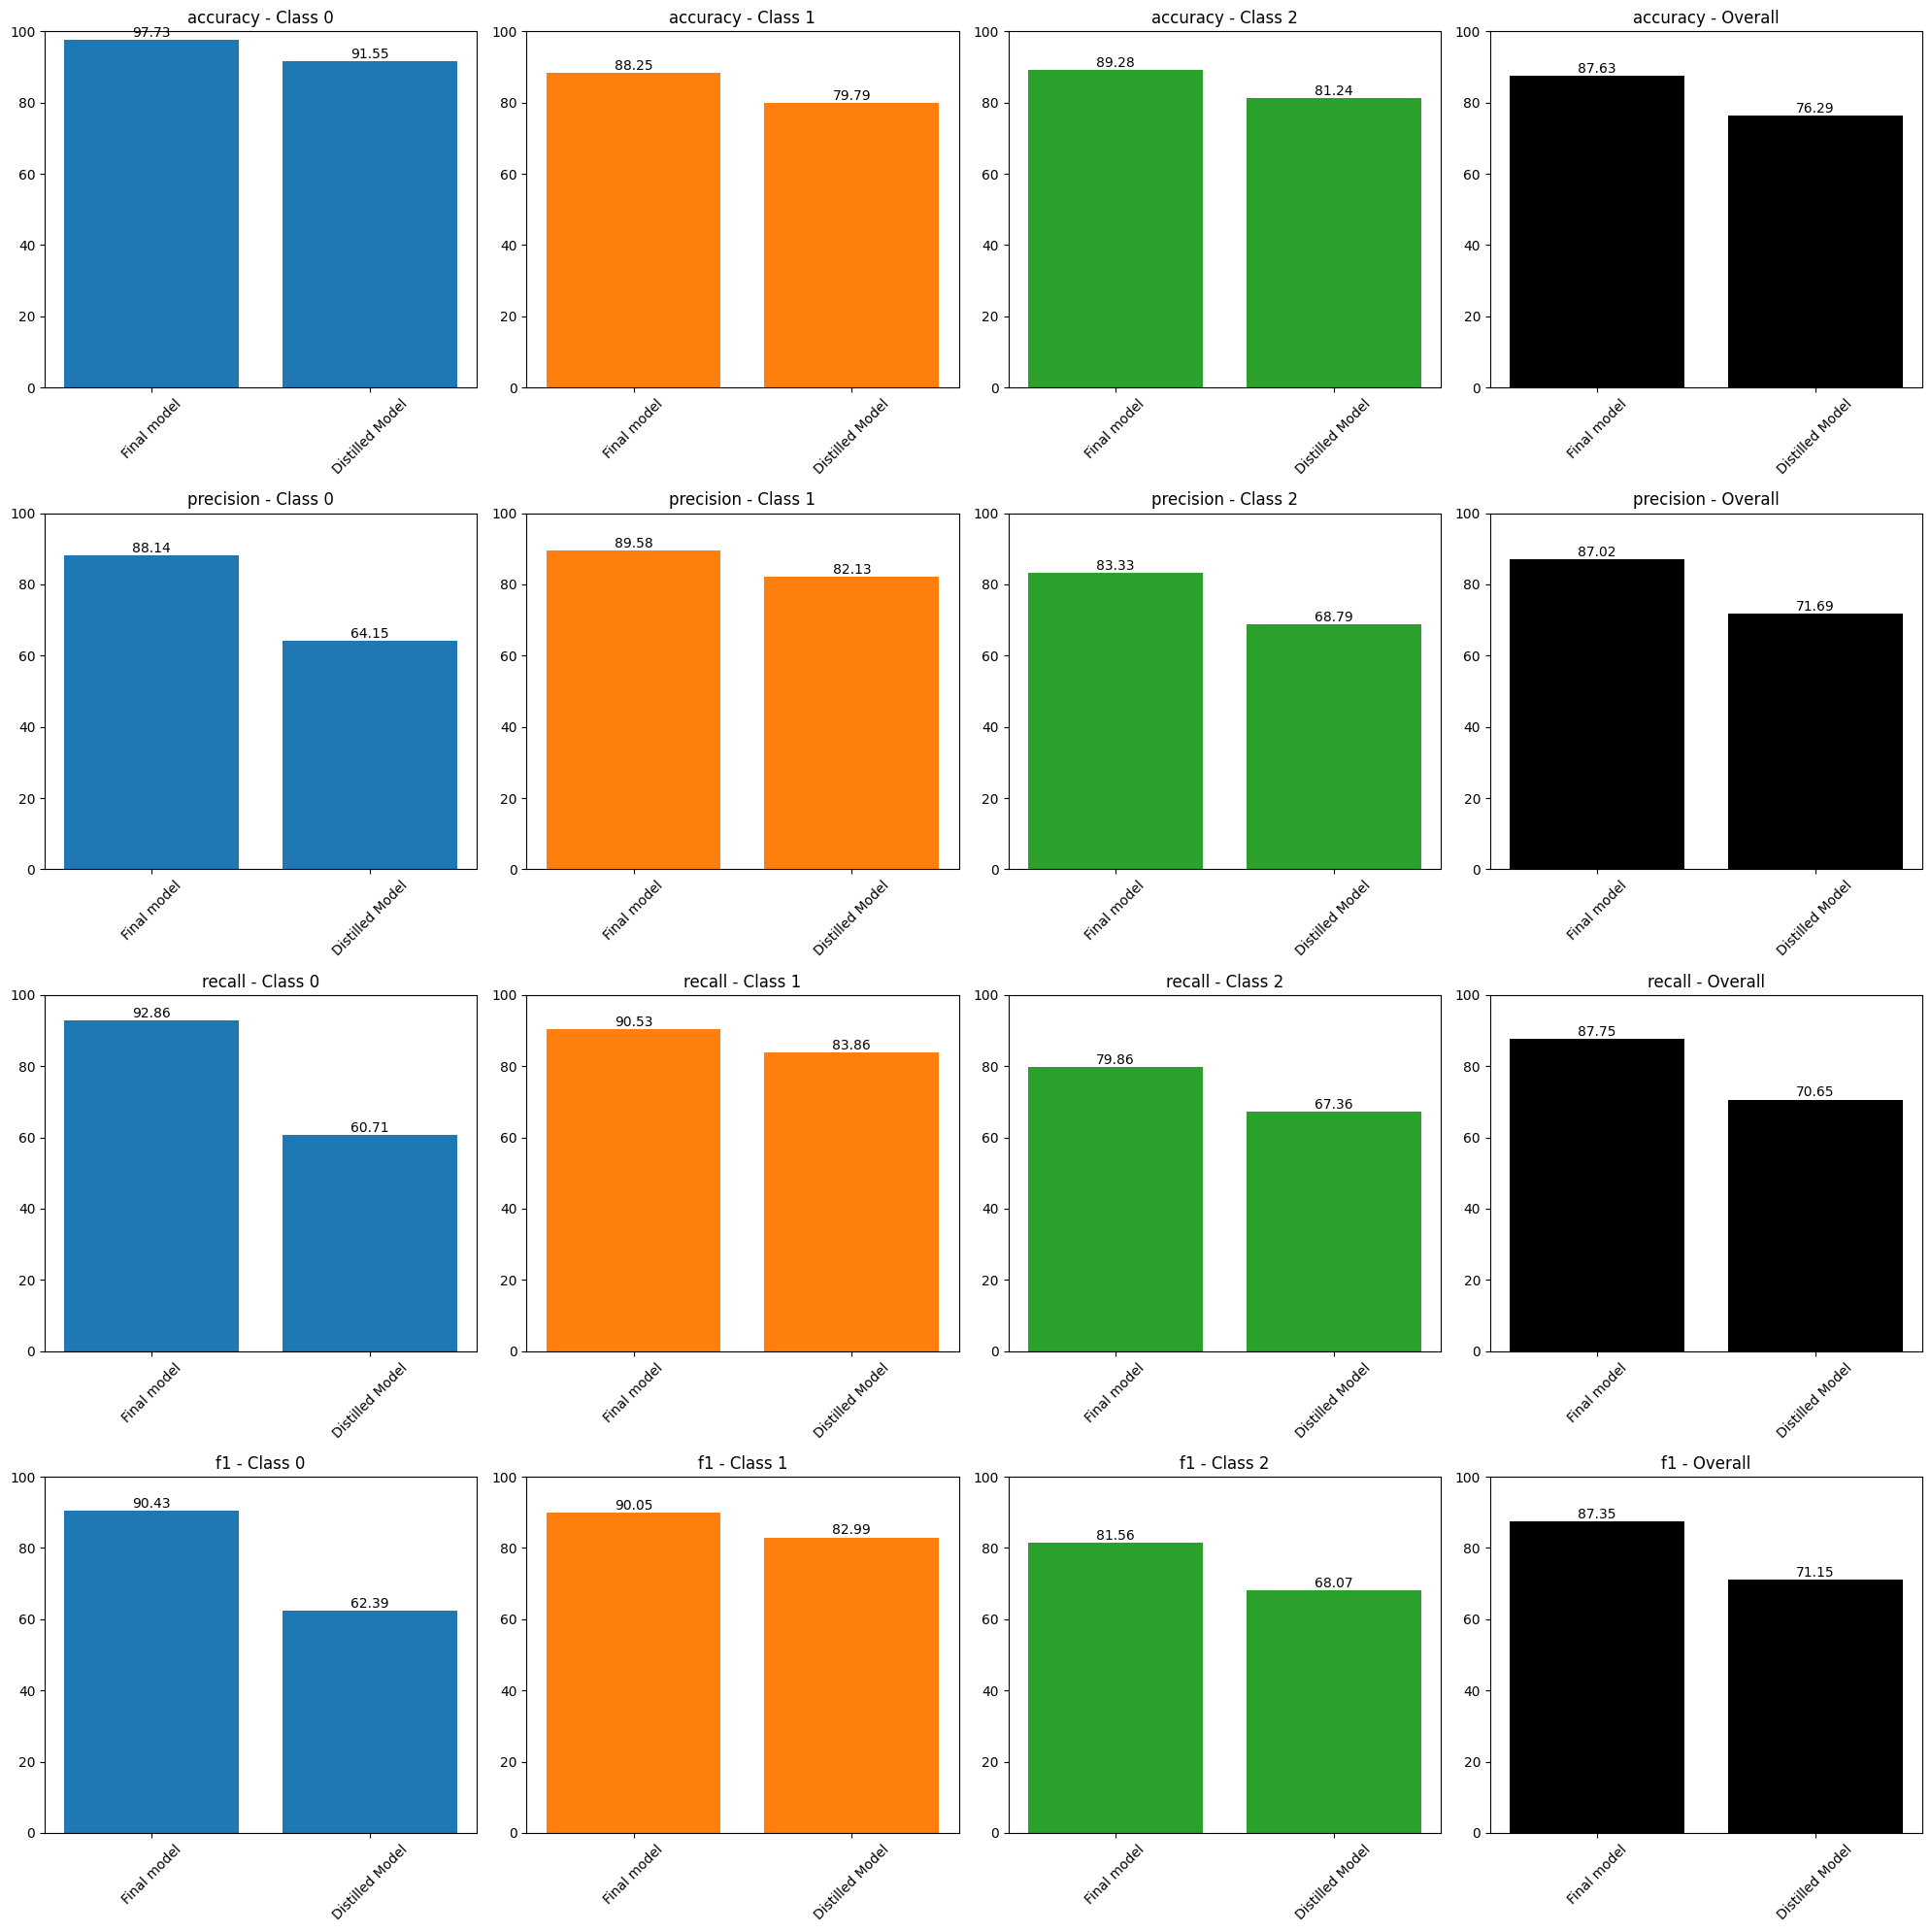

In [23]:
# Get the logits from the TFSequenceClassifierOutput object
logits = test_preds.logits
print(logits)

# Apply softmax to logits if you want probabilities (optional, as argmax can be directly applied on logits)
probabilities = tf.nn.softmax(logits).numpy()

# Use np.argmax to find the predicted class indices
predicted_class_indices = np.argmax(probabilities, axis=1)
print(predicted_class_indices)
# Now you can use these predicted class indices with your `metrics_test.run()` function
metrics_test.run(test_labels, predicted_class_indices, "Distilled Model")
metrics_test.plot()

We find that our student model is more than twice as fast than the teacher model, with an inference speed of 70ms/step compared to 142ms/step (ran on google colab GPU). This is comparable to distillBERT in Sanh et al. (2019) who decrease the speed by 60%. As we follow their approach and reduce our model size in the same way (109 to 66 million paramters) this was to be expected.

The student model achieves an F1 score of of 71.15 compared to 88 of the teacher model. Thus, we are mainting 81% of the performance. This would surely be improved by using a smaller pretrained BERT model like tinyBERT or distillBERT as these pretrained models are surely trained more carefully. However, we chose to decrease the size of our model manually by keeping only every second layer, following the approach of Sanh et al. (2019) since we wanted to fully distill the model ourselves.

### c. Analysis and Improvements

Partially answered in part 4a) to motivate the use of the double loss instead of the triple loss.

We found that the student model had a deficience in learning the under represented classes, the positive and especially the negative class. It seems as though the reduced model complexity of our distilled mdel was not able to learn the high level relationship that disentangled these classes from the neutral one. Thus, in our distillation process we tried to put more weight on the teachers predicted class probabilites, since the teacher model had learned these differences. By changing alpha and the temperature to help the student learn these relationships from the teacher model, we eventually managed to improve from a recall/precision/f1 of 0 for the negative class to around 60, which greatly improved the overall performance. For the positive class we also saw an improvement although not as drastic as the negative class.

As mentioned in b) an improvement would be to not manually reduce the model size but to use a pretrained, already distilled BERT model. Further, it is curious why the triple loss did not perfom well at all for the underrepresented classes. A fix could be to use a higher weight on the teachers predictions similar to increasing alpha in the double loss. However, since two of the three losses in the triple loss concern the teachers predictions, the weight is already 2/3. Further, we could upsample the underrepresented class or focus our data augmentation particularly on these lables and use the openai API to create more of the positive and negative classes.

## APPENDIX

### Implementation of Financial BERT with Pytorch

When we are deciding which BERT model to use we first started with the Financial Bert implementation but it was outputting very weak results. We investigated on it and apparently some weights of the model don't translante very well to the Tensorflow library. So, we decided to try to run FinancialBERT on pytorch and the Finbert on tensorflow to compare the outputs and decide which one we wanted to work with. With the full data FinBERT got a 88 F1 comparing to the 85.4 of Financial BERT. So we decided to stay on the model we knew and actually performed better (FinBERT on tensorflow).

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

# Assuming `train_data` and `train_labels` are defined
# Assuming `test_data` and `test_labels` are defined

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT")

# Parameters
max_length = 512
batch_size = 32

In [ ]:
class FinancialBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_dataset = FinancialBERTDataset(train_data, train_labels_encoded, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
num_labels = len(np.unique(train_labels_encoded))
model = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT", num_labels=num_labels).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ahmedrachid/FinancialBERT and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'classifier.bias', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()


/Users/arimichelangelo/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Tokenize test data
test_encodings = tokenizer(test_data, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

# Move to device
input_ids = test_encodings['input_ids'].to(device)
attention_mask = test_encodings['attention_mask'].to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1).numpy()

# Encode test labels
test_labels_encoded = label_encoder.transform(test_labels)

# Evaluation (You can use metrics like accuracy from scikit-learn)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels_encoded, predictions)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8639175257731959


/var/folders/f_/gyff9ggs4m3g21vhrwp_rk200000gn/T/ipykernel_5364/1071064952.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
/var/folders/f_/gyff9ggs4m3g21vhrwp_rk200000gn/T/ipykernel_5364/1071064952.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
/var/folders/f_/gyff9ggs4m3g21vhrwp_rk200000gn/T/ipykernel_5364/1071064952.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(self.results[j].keys(), rotation=45)
/var/folders/f_/gyff9ggs4m3g21vhrwp_rk200000gn/T/ipykernel_5364/1071064952.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a 

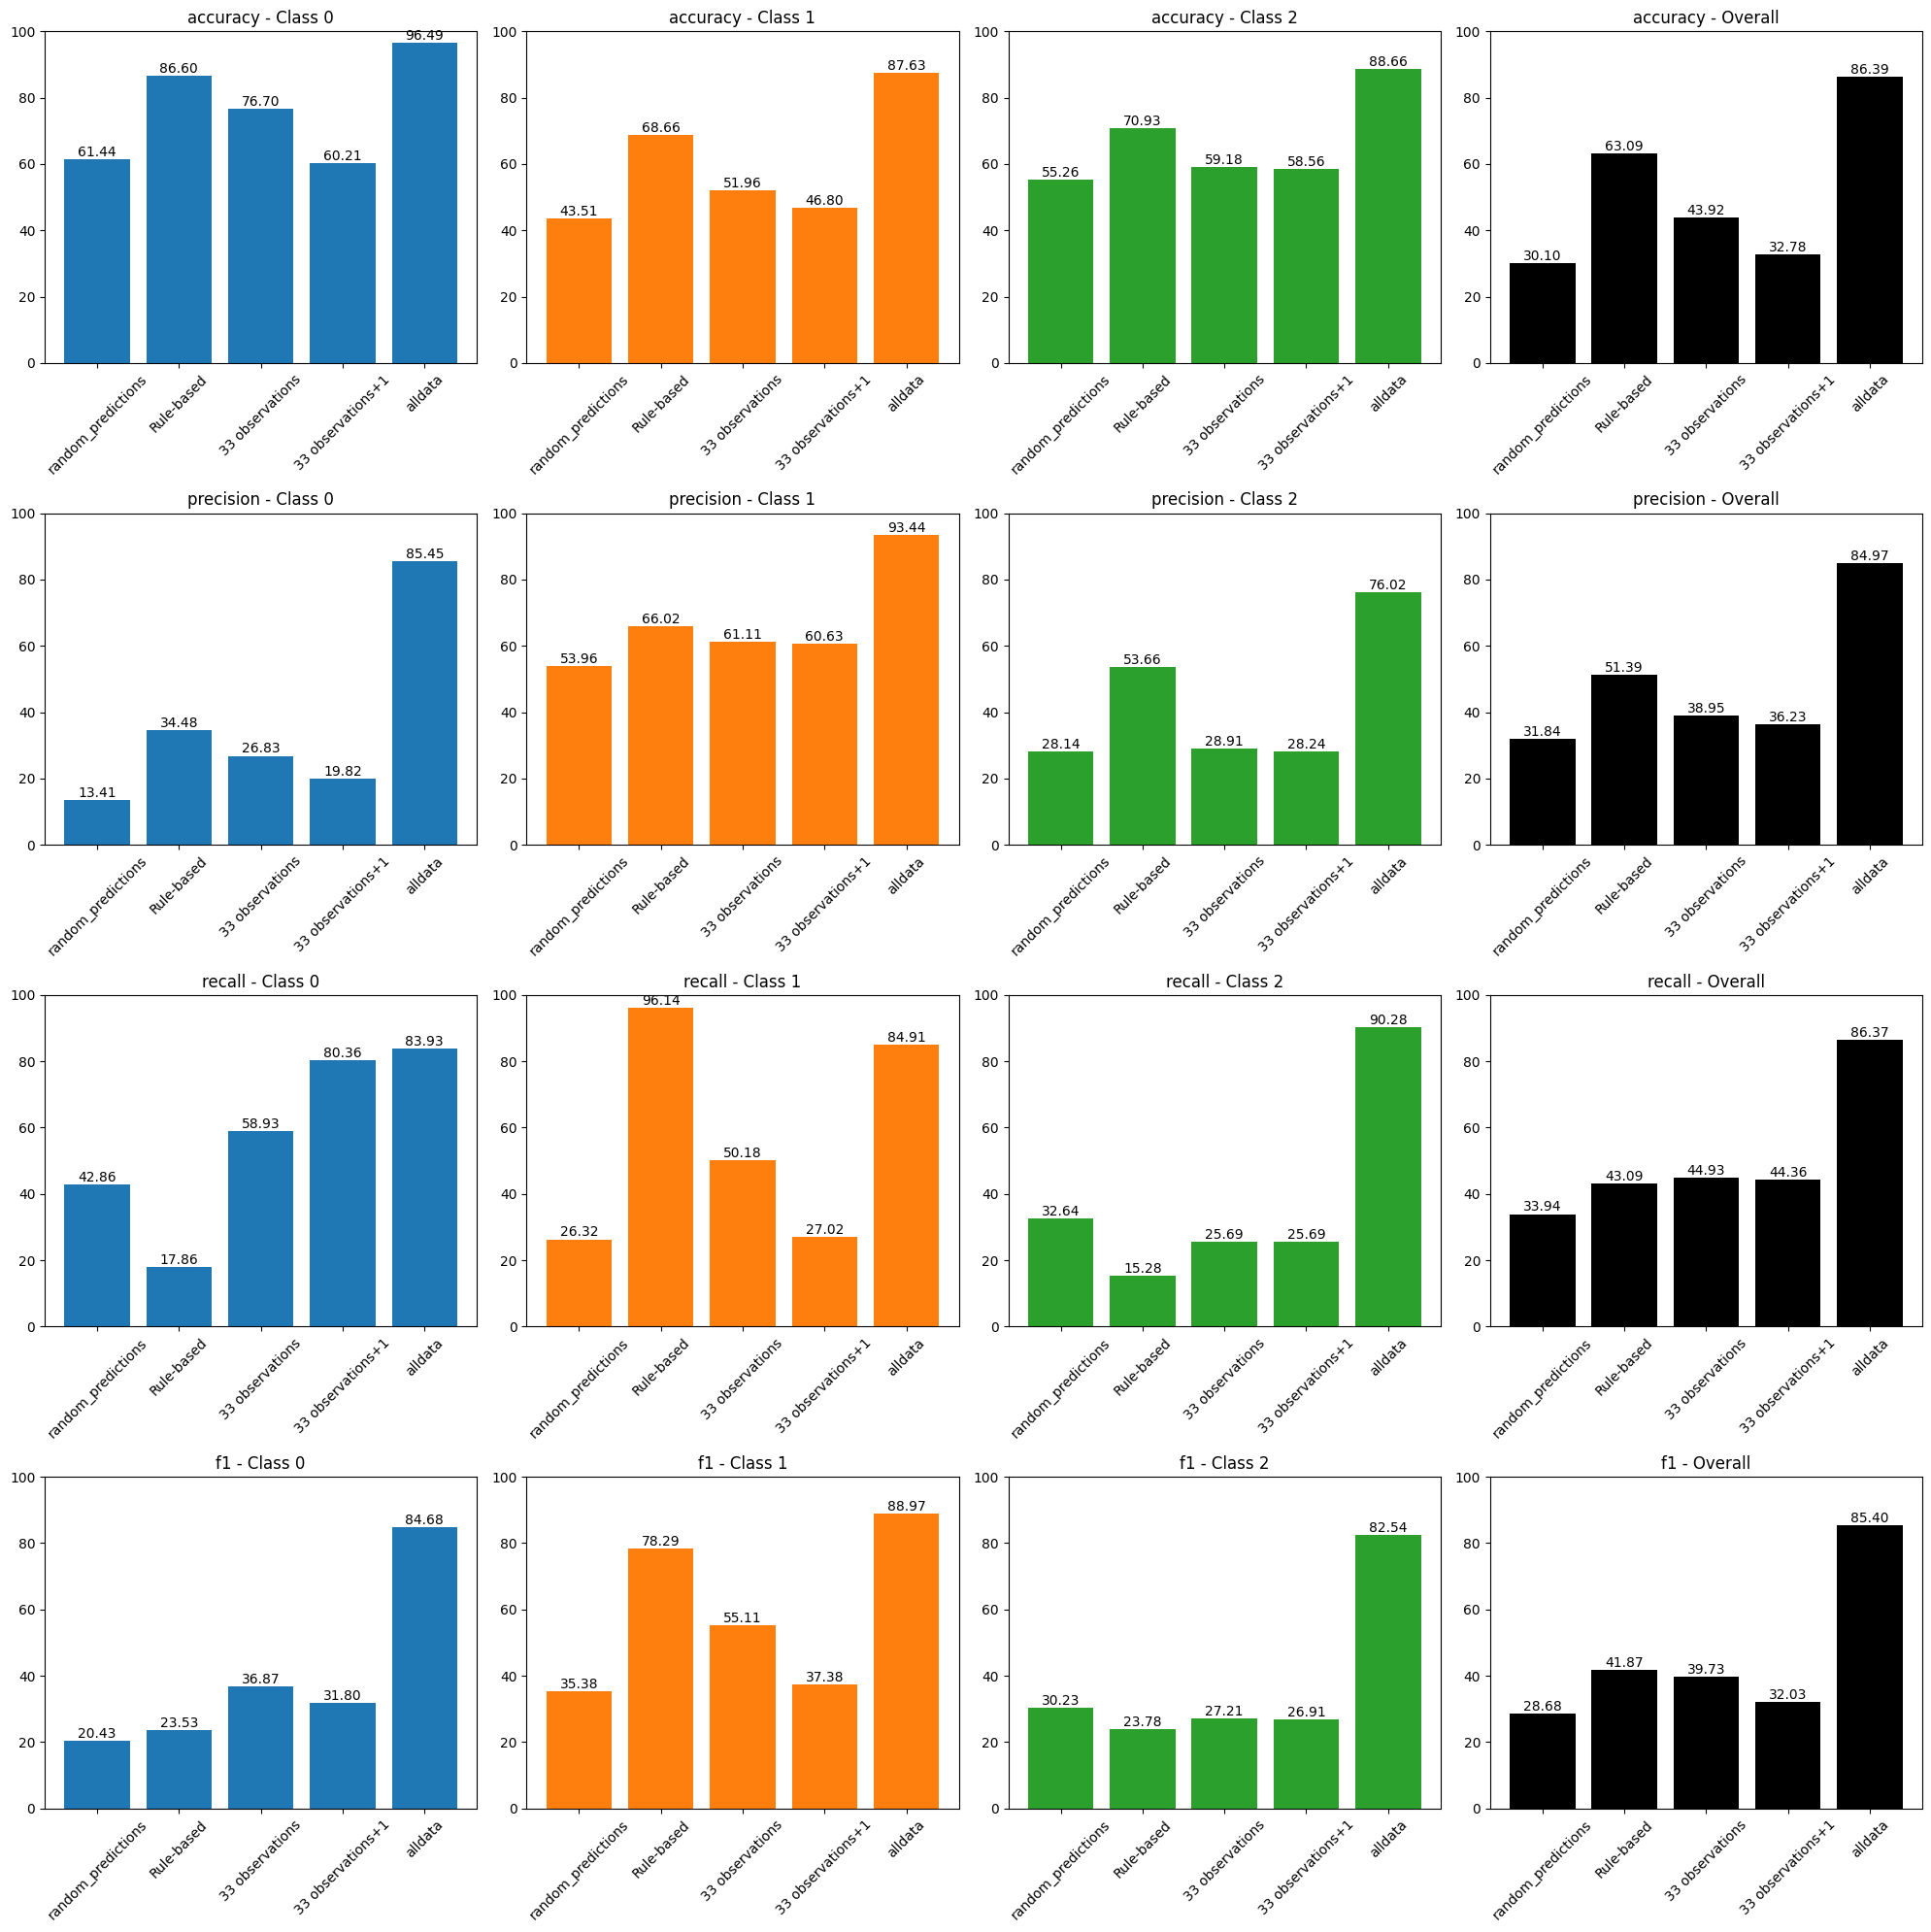

In [ ]:

# get the final metrics
metrics_test.run(test_labels_encoded, predictions, "alldata")
metrics_test.plot()